## Comparative run
Sample THEx data so that it is consistent with the filtered PLASTICCS data. THEN run the model on this data and see if there is a difference between this and the original model with the original data.

Sample THEx data

In [1]:
from estimate.get_data import *
import numpy as np
import matplotlib.pyplot as plt

import math

def plot_z_dists(data1, data2, label1, label2, bins):
    """
    Plot z distribution of two sets
    """
    fig, ax = plt.subplots(tight_layout=True, sharex=True,  sharey=True)  
    b = ax.hist(data1, density=True, bins=bins, label=label1, fill=False, edgecolor='blue')
    a = ax.hist(data2, density=True, bins=bins, label=label2, fill=False, edgecolor='red')
    plt.legend()
    plt.title("Filtered THEx versus LSST")
    plt.xlabel("Redshift")
    plt.ylabel("Density")

def get_THEx_sampled_data(class_name, max_rmag, num_samples):
    """
    Sample THEx class data to have the same redshift distribution as LSST cut to a certain r_first_mag
    """
    feature_name = "r_first_mag"
    
    # Pull down THEx data
    thex_dataset = get_data('g_W2')
    thex_class_data = get_thex_class_data(class_name, thex_dataset)

    thex_z_vals = thex_class_data['redshift'].values

    # Pull down LSST data
    lsst_class_data = get_lsst_class_data(class_name, feature_name)
 
    # Get histogram and per bar frequencies of LSST cut data
    # 1. get LSST data cut to certain r first mag range
    filt_lsst_class_data = lsst_class_data[lsst_class_data[feature_name] <= max_rmag]

    # 2. Get hist of redshift values, and frequencies 
    lsst_z_vals = filt_lsst_class_data['true_z'].values
    Z_bins = np.linspace(0, 1, 50)
    hist, bins = np.histogram(lsst_z_vals, bins=Z_bins)
    z_dist = hist/len(lsst_z_vals) # proportion of total in each bin
    
    # Sample THEx data at these rates
    new_data = []
    for index, freq in enumerate(z_dist):
        samples = num_samples * freq
        min_feature = Z_bins[index]
        max_feature = Z_bins[index+1]
        # Filter by redshift
        f_df = thex_class_data[(thex_class_data['redshift'] >= min_feature) & (thex_class_data['redshift'] <= max_feature)]
        if  f_df.shape[0] >= samples:
            f_df = f_df.sample(n=int(samples))
            new_data.append(f_df)
        else:
            new_data.append(f_df)
    df = pd.concat(new_data)
    df = df.reset_index(drop=True)
    lsst_label = "LSST, " + feature_name + " <= " + str(max_rmag)
    thex_label = "Filtered THEx"
    plot_z_dists(lsst_z_vals, df['redshift'].values, lsst_label, thex_label, Z_bins )

    return df





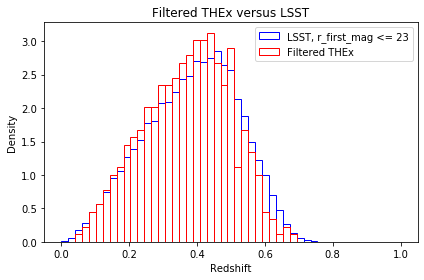

In [2]:
Ia_sampled_data = get_THEx_sampled_data(class_name = "Ia", max_rmag = 23, num_samples = 500)

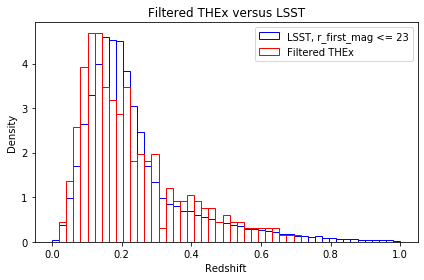

In [3]:
II_sampled_data = get_THEx_sampled_data(class_name = "II", max_rmag = 23, num_samples = 500)

In [4]:
II_sampled_data.shape

(324, 12)

In [5]:
Ia_sampled_data.shape

(439, 12)

In [6]:
list(Ia_sampled_data)

['z_mag',
 'J_mag',
 'W2_mag',
 'W1_mag',
 'r_mag',
 'g_mag',
 'H_mag',
 'y_mag',
 'redshift',
 'K_mag',
 'i_mag',
 'transient_type']

## Original run
Run model on THEx data as-is - be sure to use the same NUMBER of class samples as above.

In [7]:
from models.multi_model.multi_model import MultiModel
%matplotlib inline
# mags = ["g_mag", "r_mag", "i_mag", "z_mag", "y_mag",
#         "W1_mag", "W2_mag", "H_mag", "K_mag", 
#        "redshift"]
mags = ['z_mag',
 'J_mag',
 'W2_mag',
 'W1_mag',
 'r_mag',
 'g_mag',
 'H_mag',
 'y_mag',
 'redshift',
 'K_mag',
 'i_mag']


/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.kde module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [8]:
# Set up data for testing
import pandas as pd
sampled_data = pd.concat([Ia_sampled_data, II_sampled_data])
#Shuffle
sampled_data = sampled_data.sample(frac=1).reset_index(drop=True)
# Split
y_test_LSST_like = sampled_data[['transient_type']] 
X_test_LSST_like = sampled_data.drop(labels=['transient_type'], axis =1 )

In [12]:
# Rearrange to have same order as THEx data pulled into model
X_test_LSST_like=X_test_LSST_like[['K_mag',
 'i_mag',
 'W1_mag',
 'W2_mag',
 'H_mag',
 'redshift',
 'J_mag',
 'r_mag',
 'z_mag',
 'g_mag',
 'y_mag']] 

## Train on original data

In [11]:
model = MultiModel(cols = mags,
#            data = [X, y],
           class_labels = ['Ia', 'II'],
           transform_features = False,
           folds=20,
           min_class_size = 40
          )
list(model.X)

['K_mag',
 'i_mag',
 'W1_mag',
 'W2_mag',
 'H_mag',
 'redshift',
 'J_mag',
 'r_mag',
 'z_mag',
 'g_mag',
 'y_mag']

## Test on new, Z sampled data - for several trials

In [15]:
results = []
N = 5
for i in range(N):
    X_train, y_train, X_test, y_test = model.manually_stratify(model.X, model.y, .8)
    model.train_model(X_train, y_train)

    # Test model 
    probabilities = model.get_all_class_probabilities(X_test_LSST_like, model.normalize)
    # Add labels as column to probabilities, for later evaluation
    label_column = y_test_LSST_like['transient_type'].values.reshape(-1, 1)
    probabilities = np.hstack((probabilities, label_column))
    results.append(probabilities)


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWar

In [19]:
# import numpy as np
# concat_results = np.concatenate(results)
model.results = results

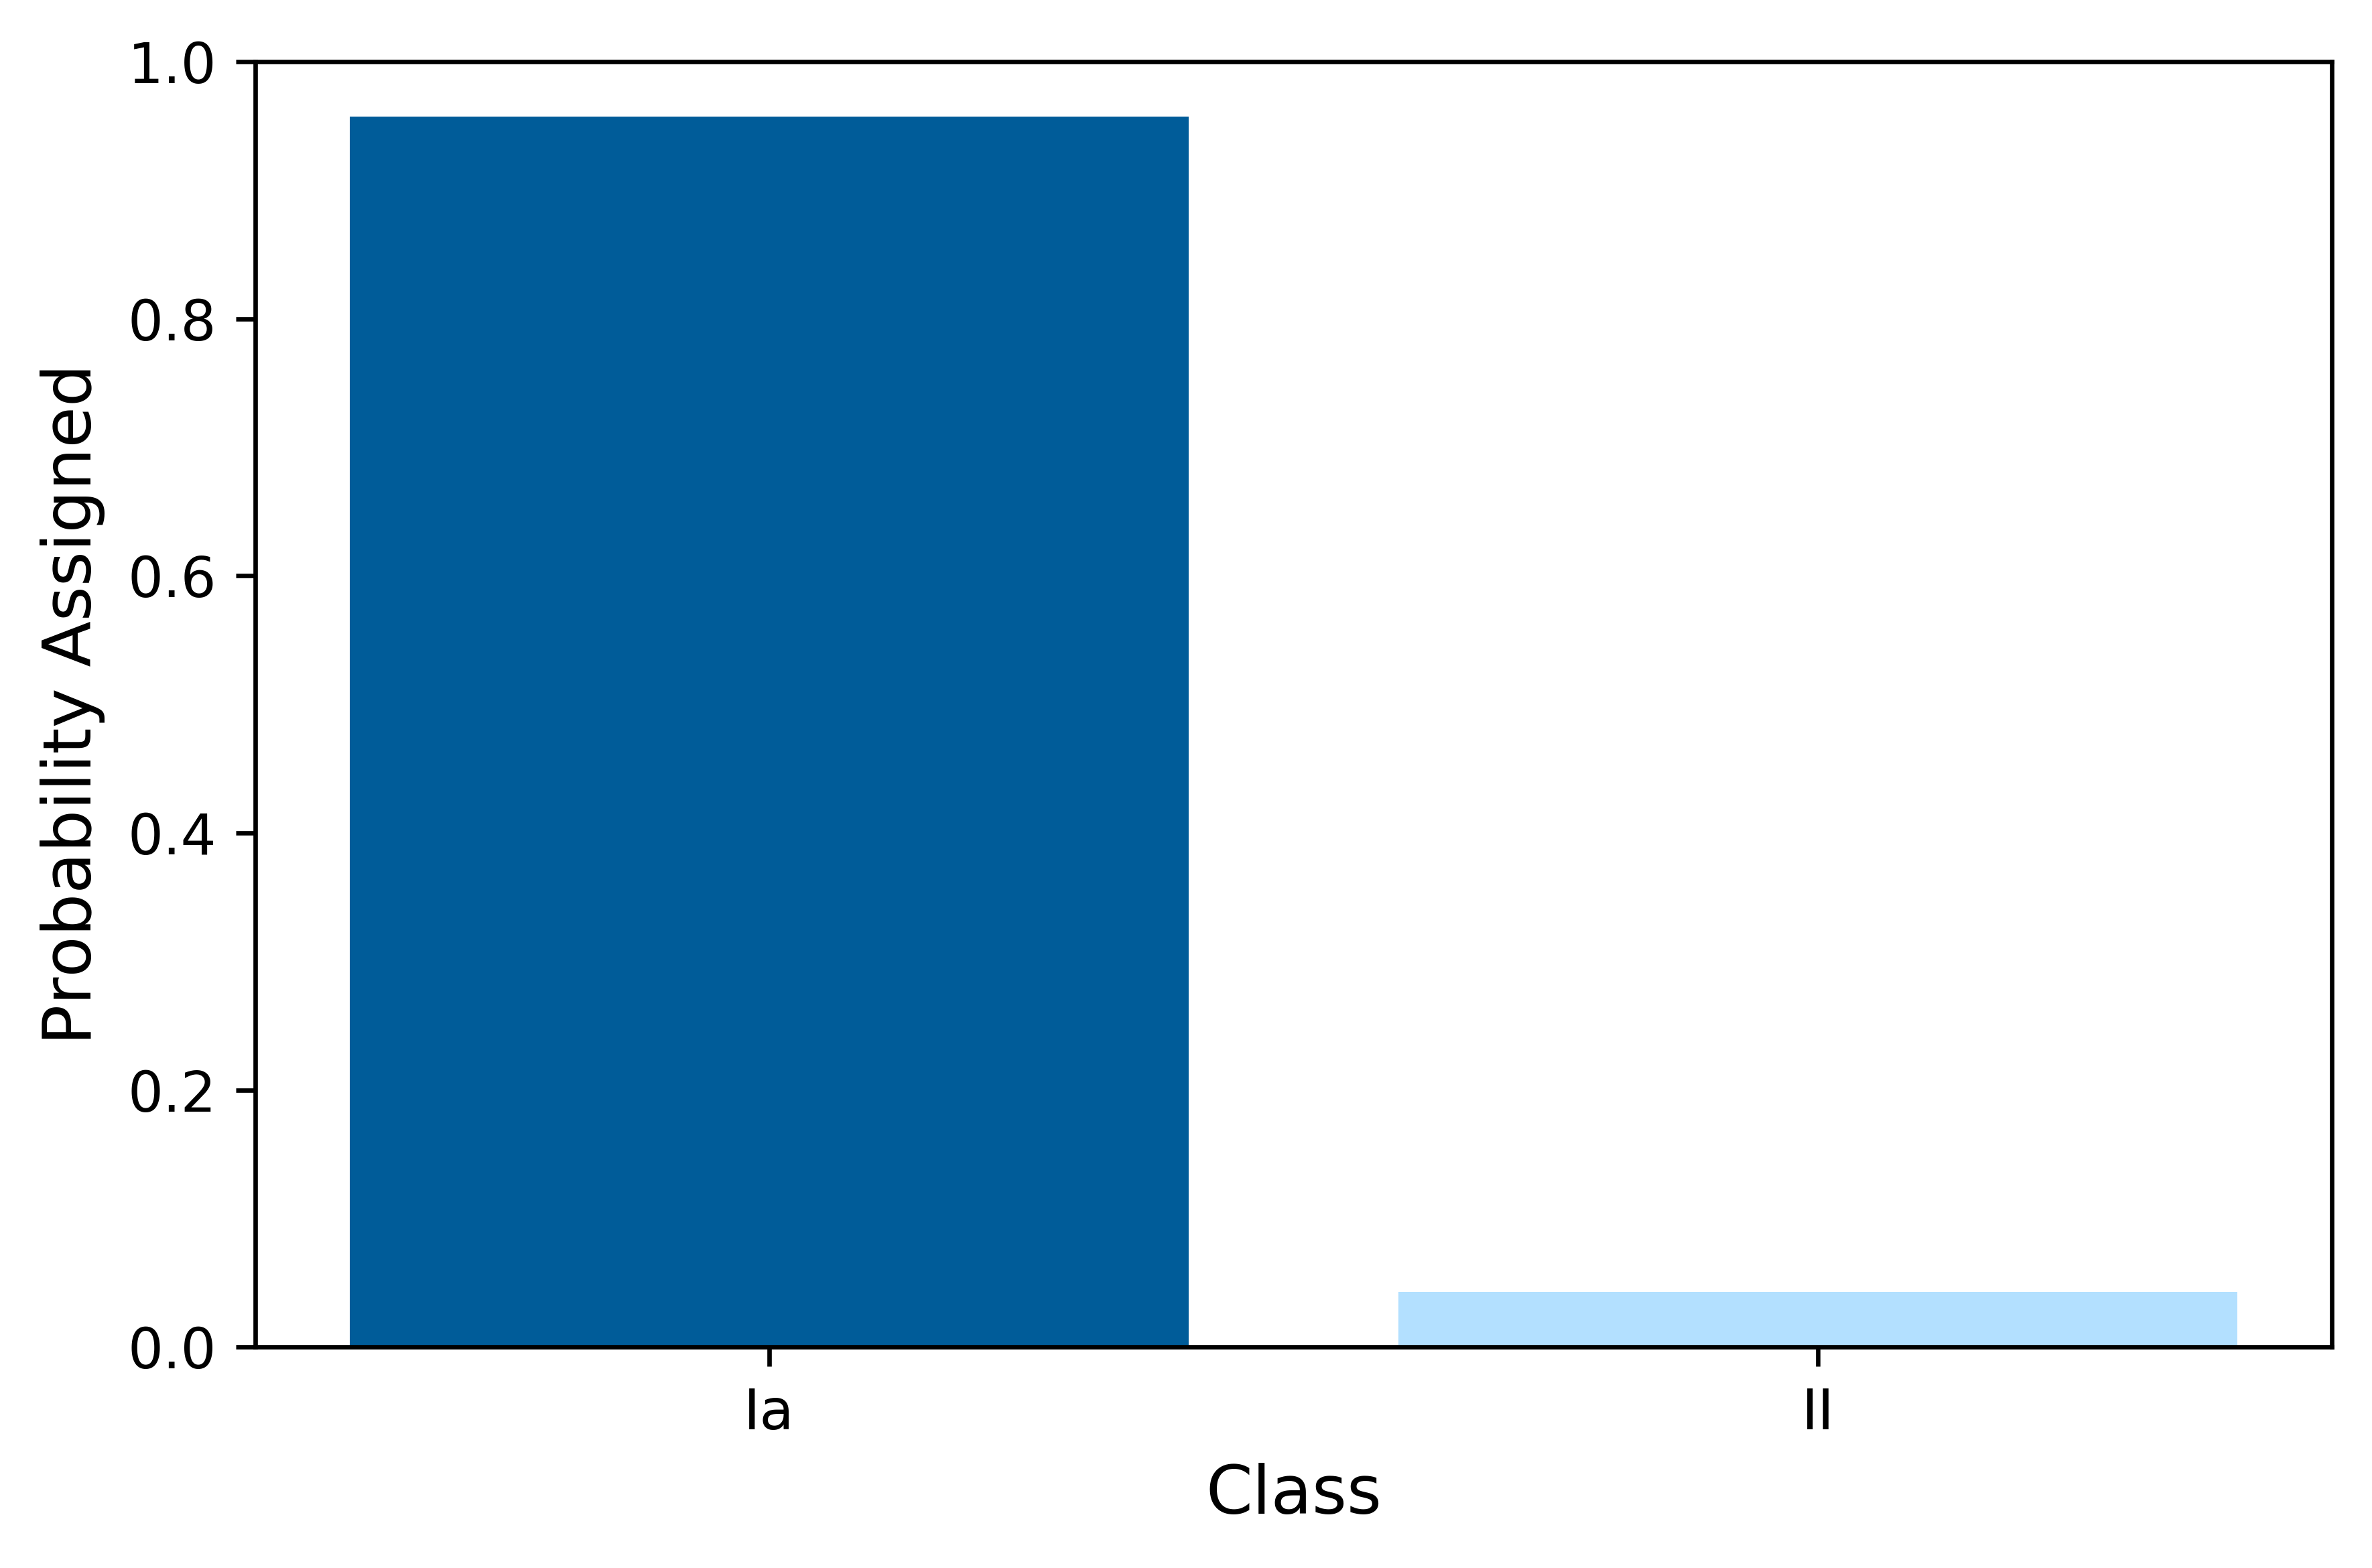

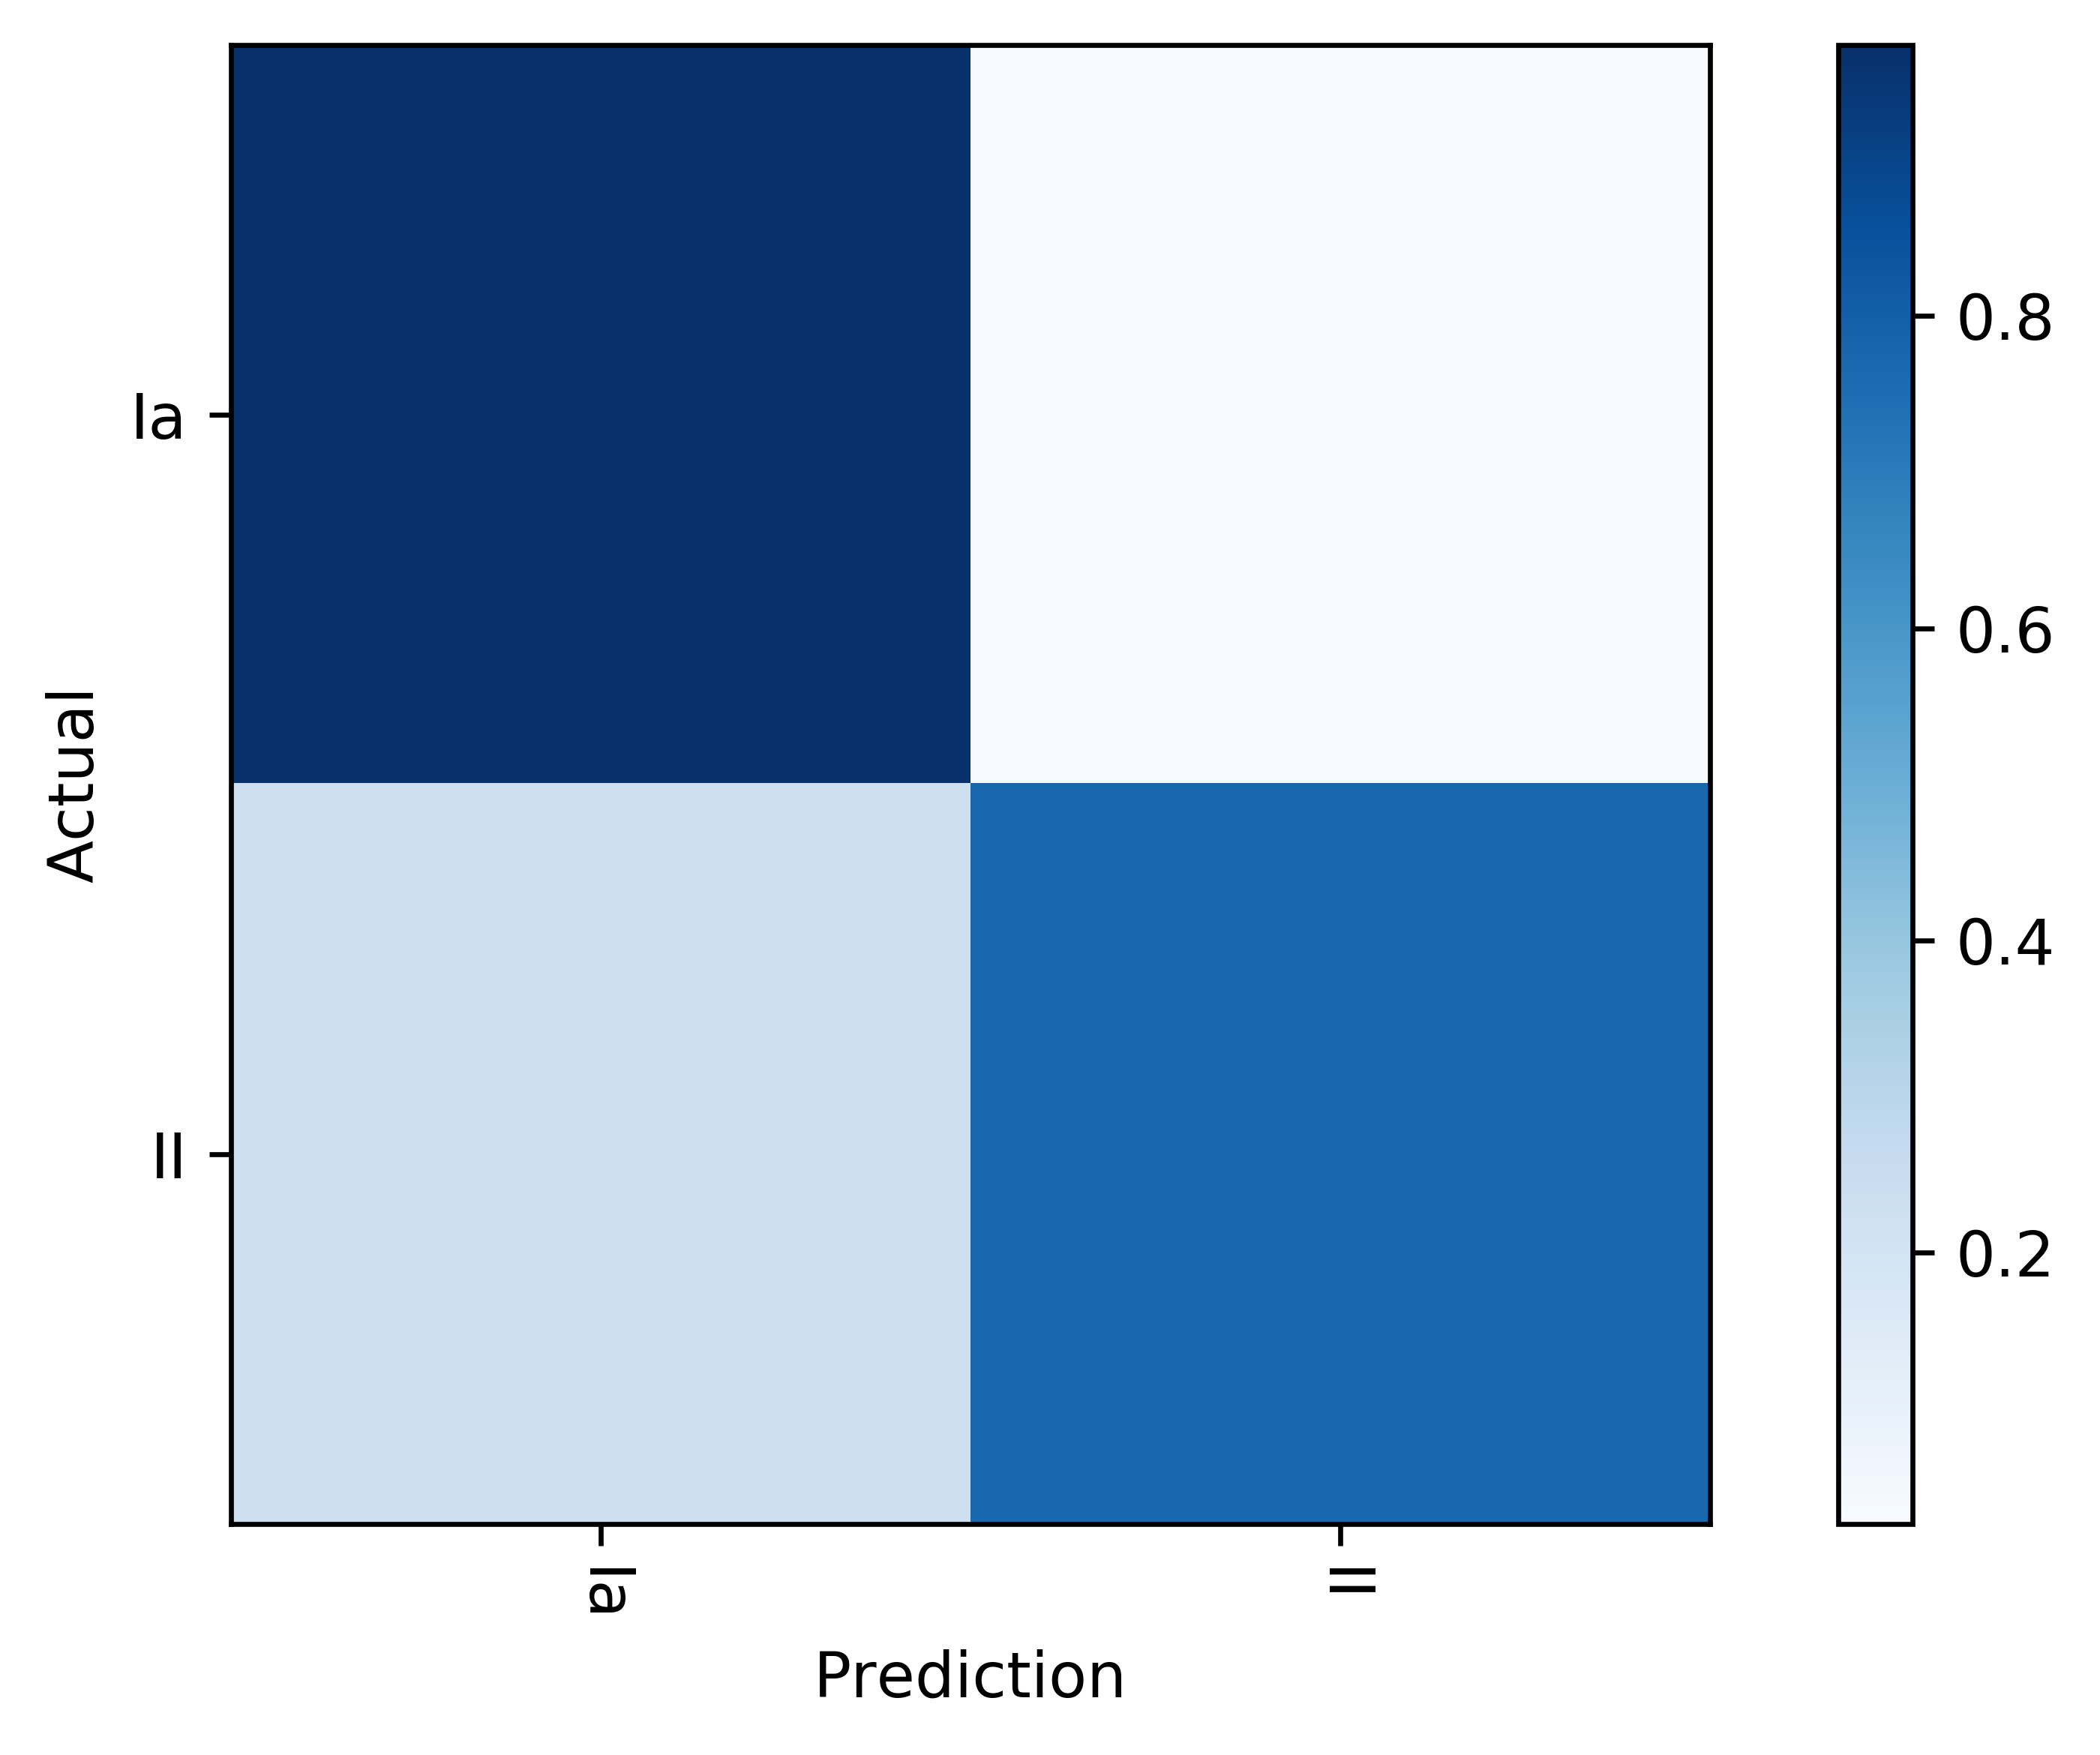

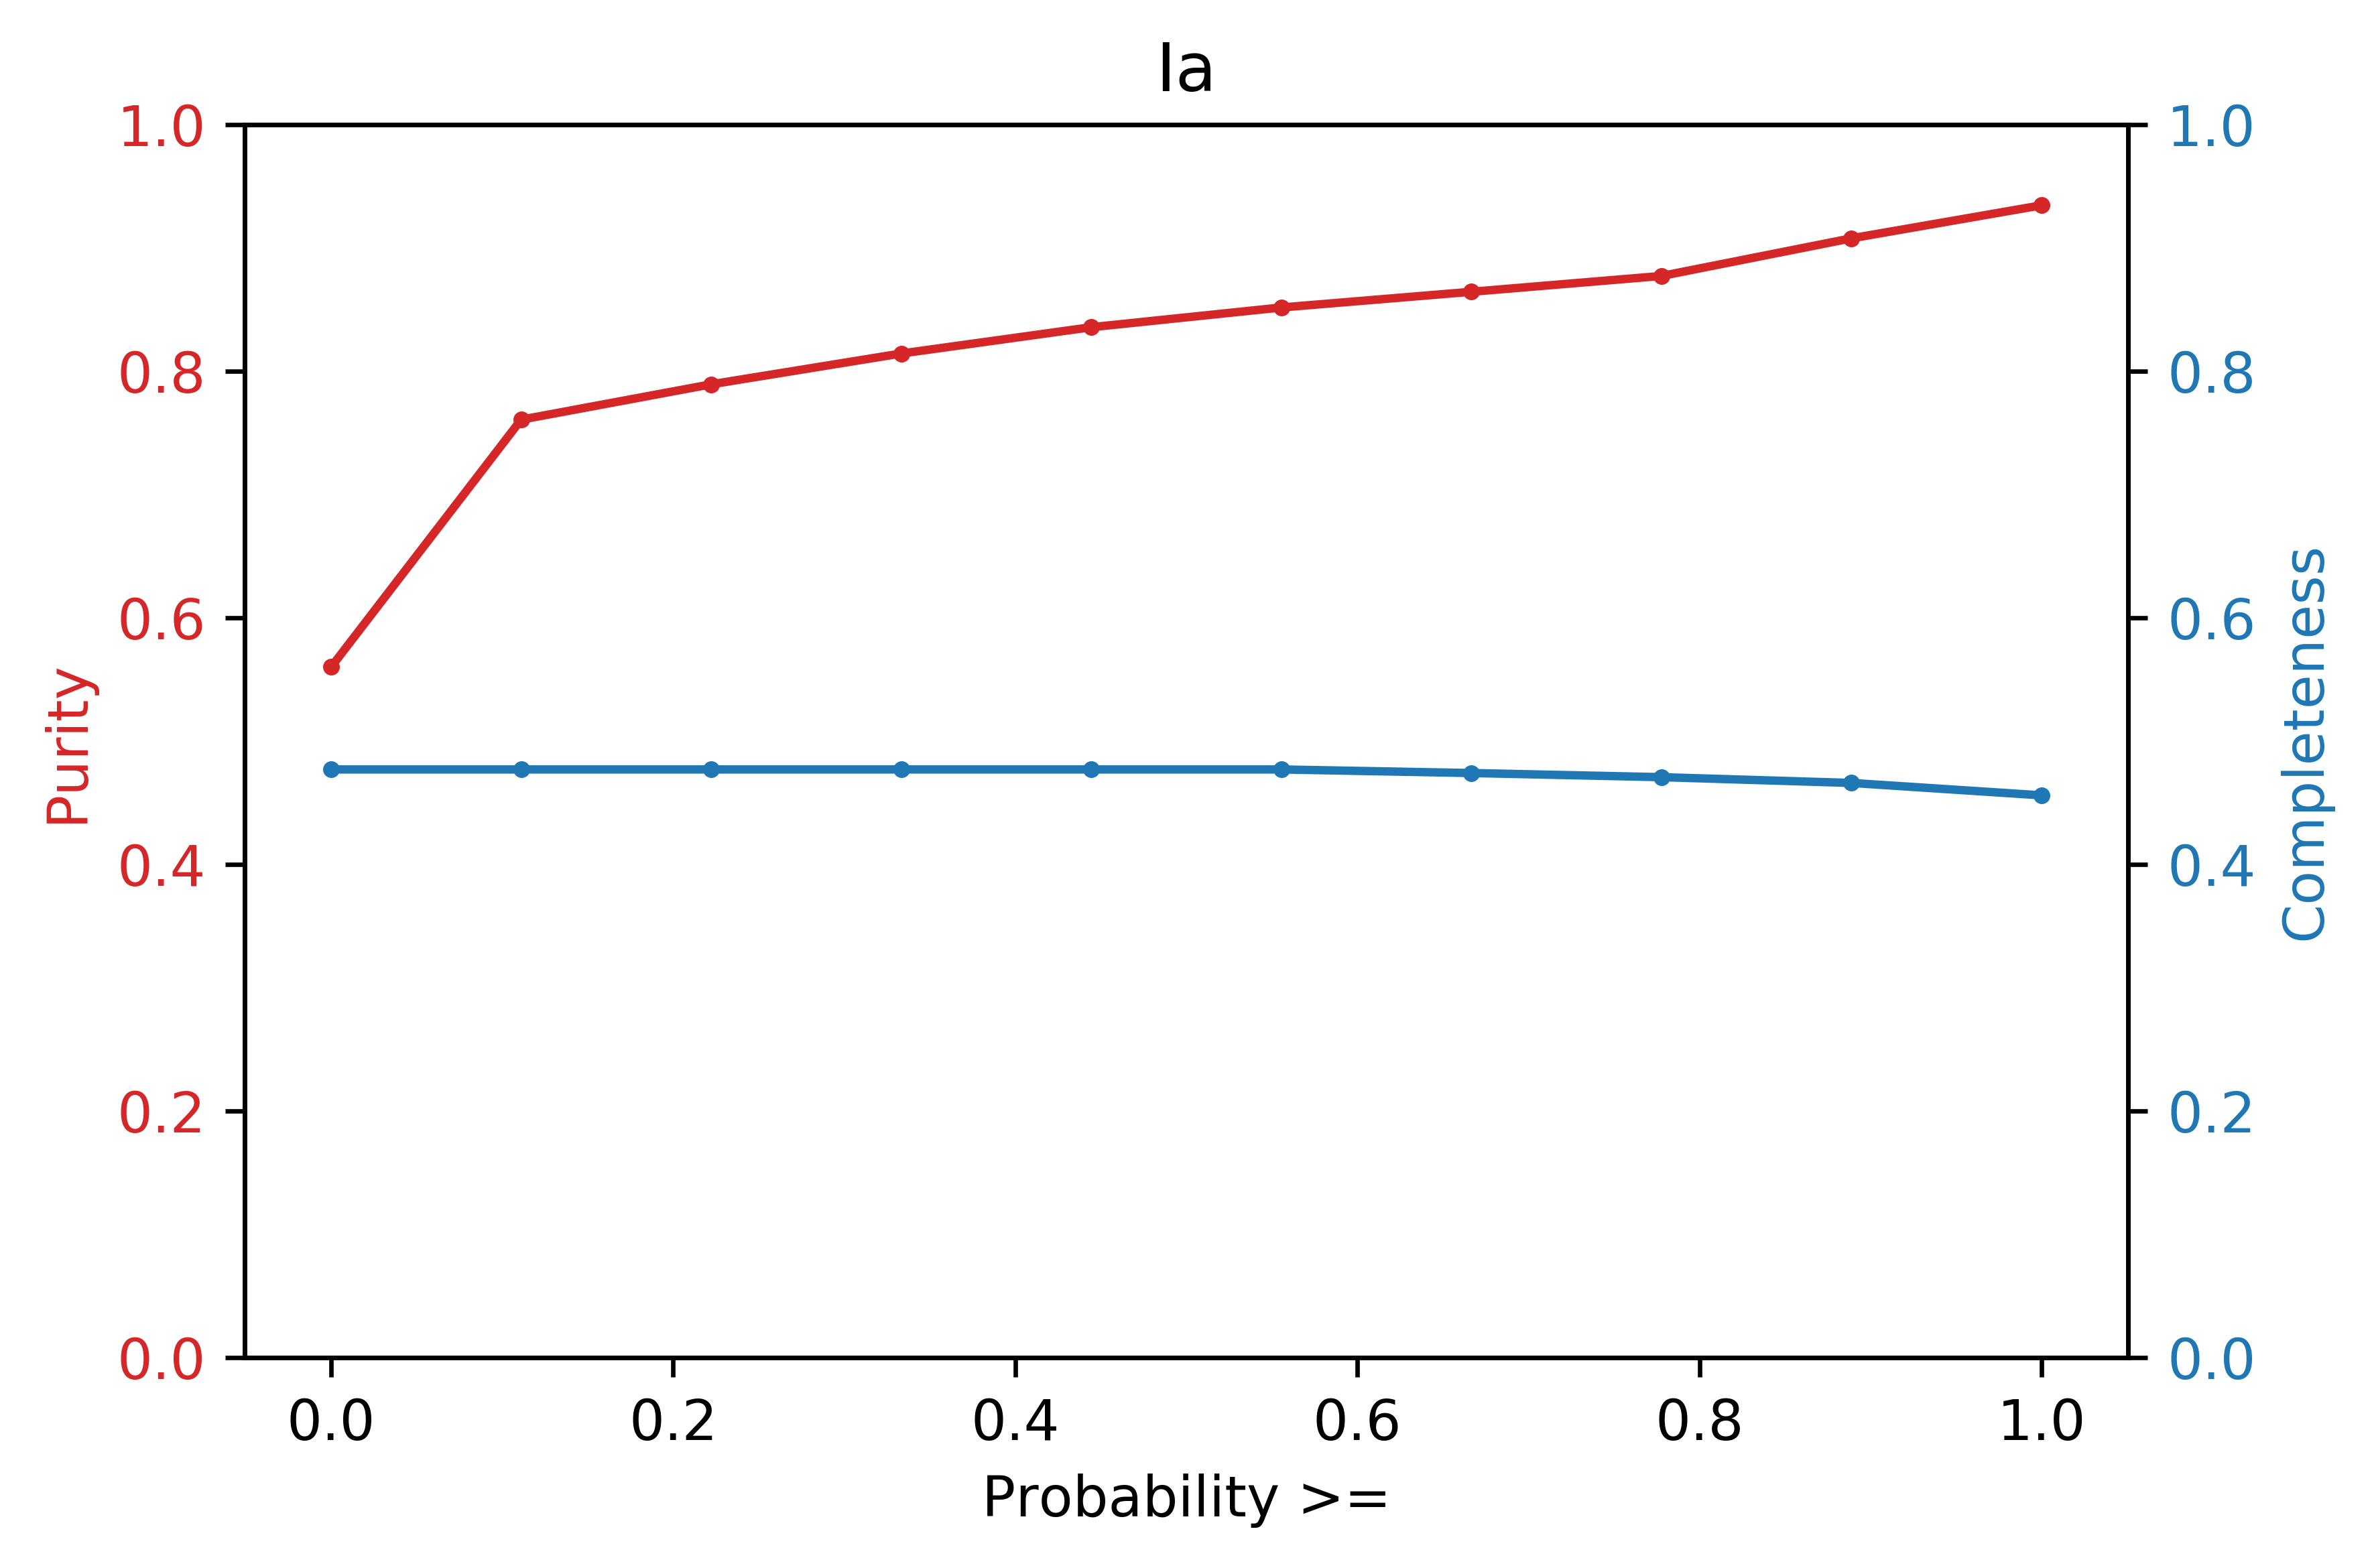

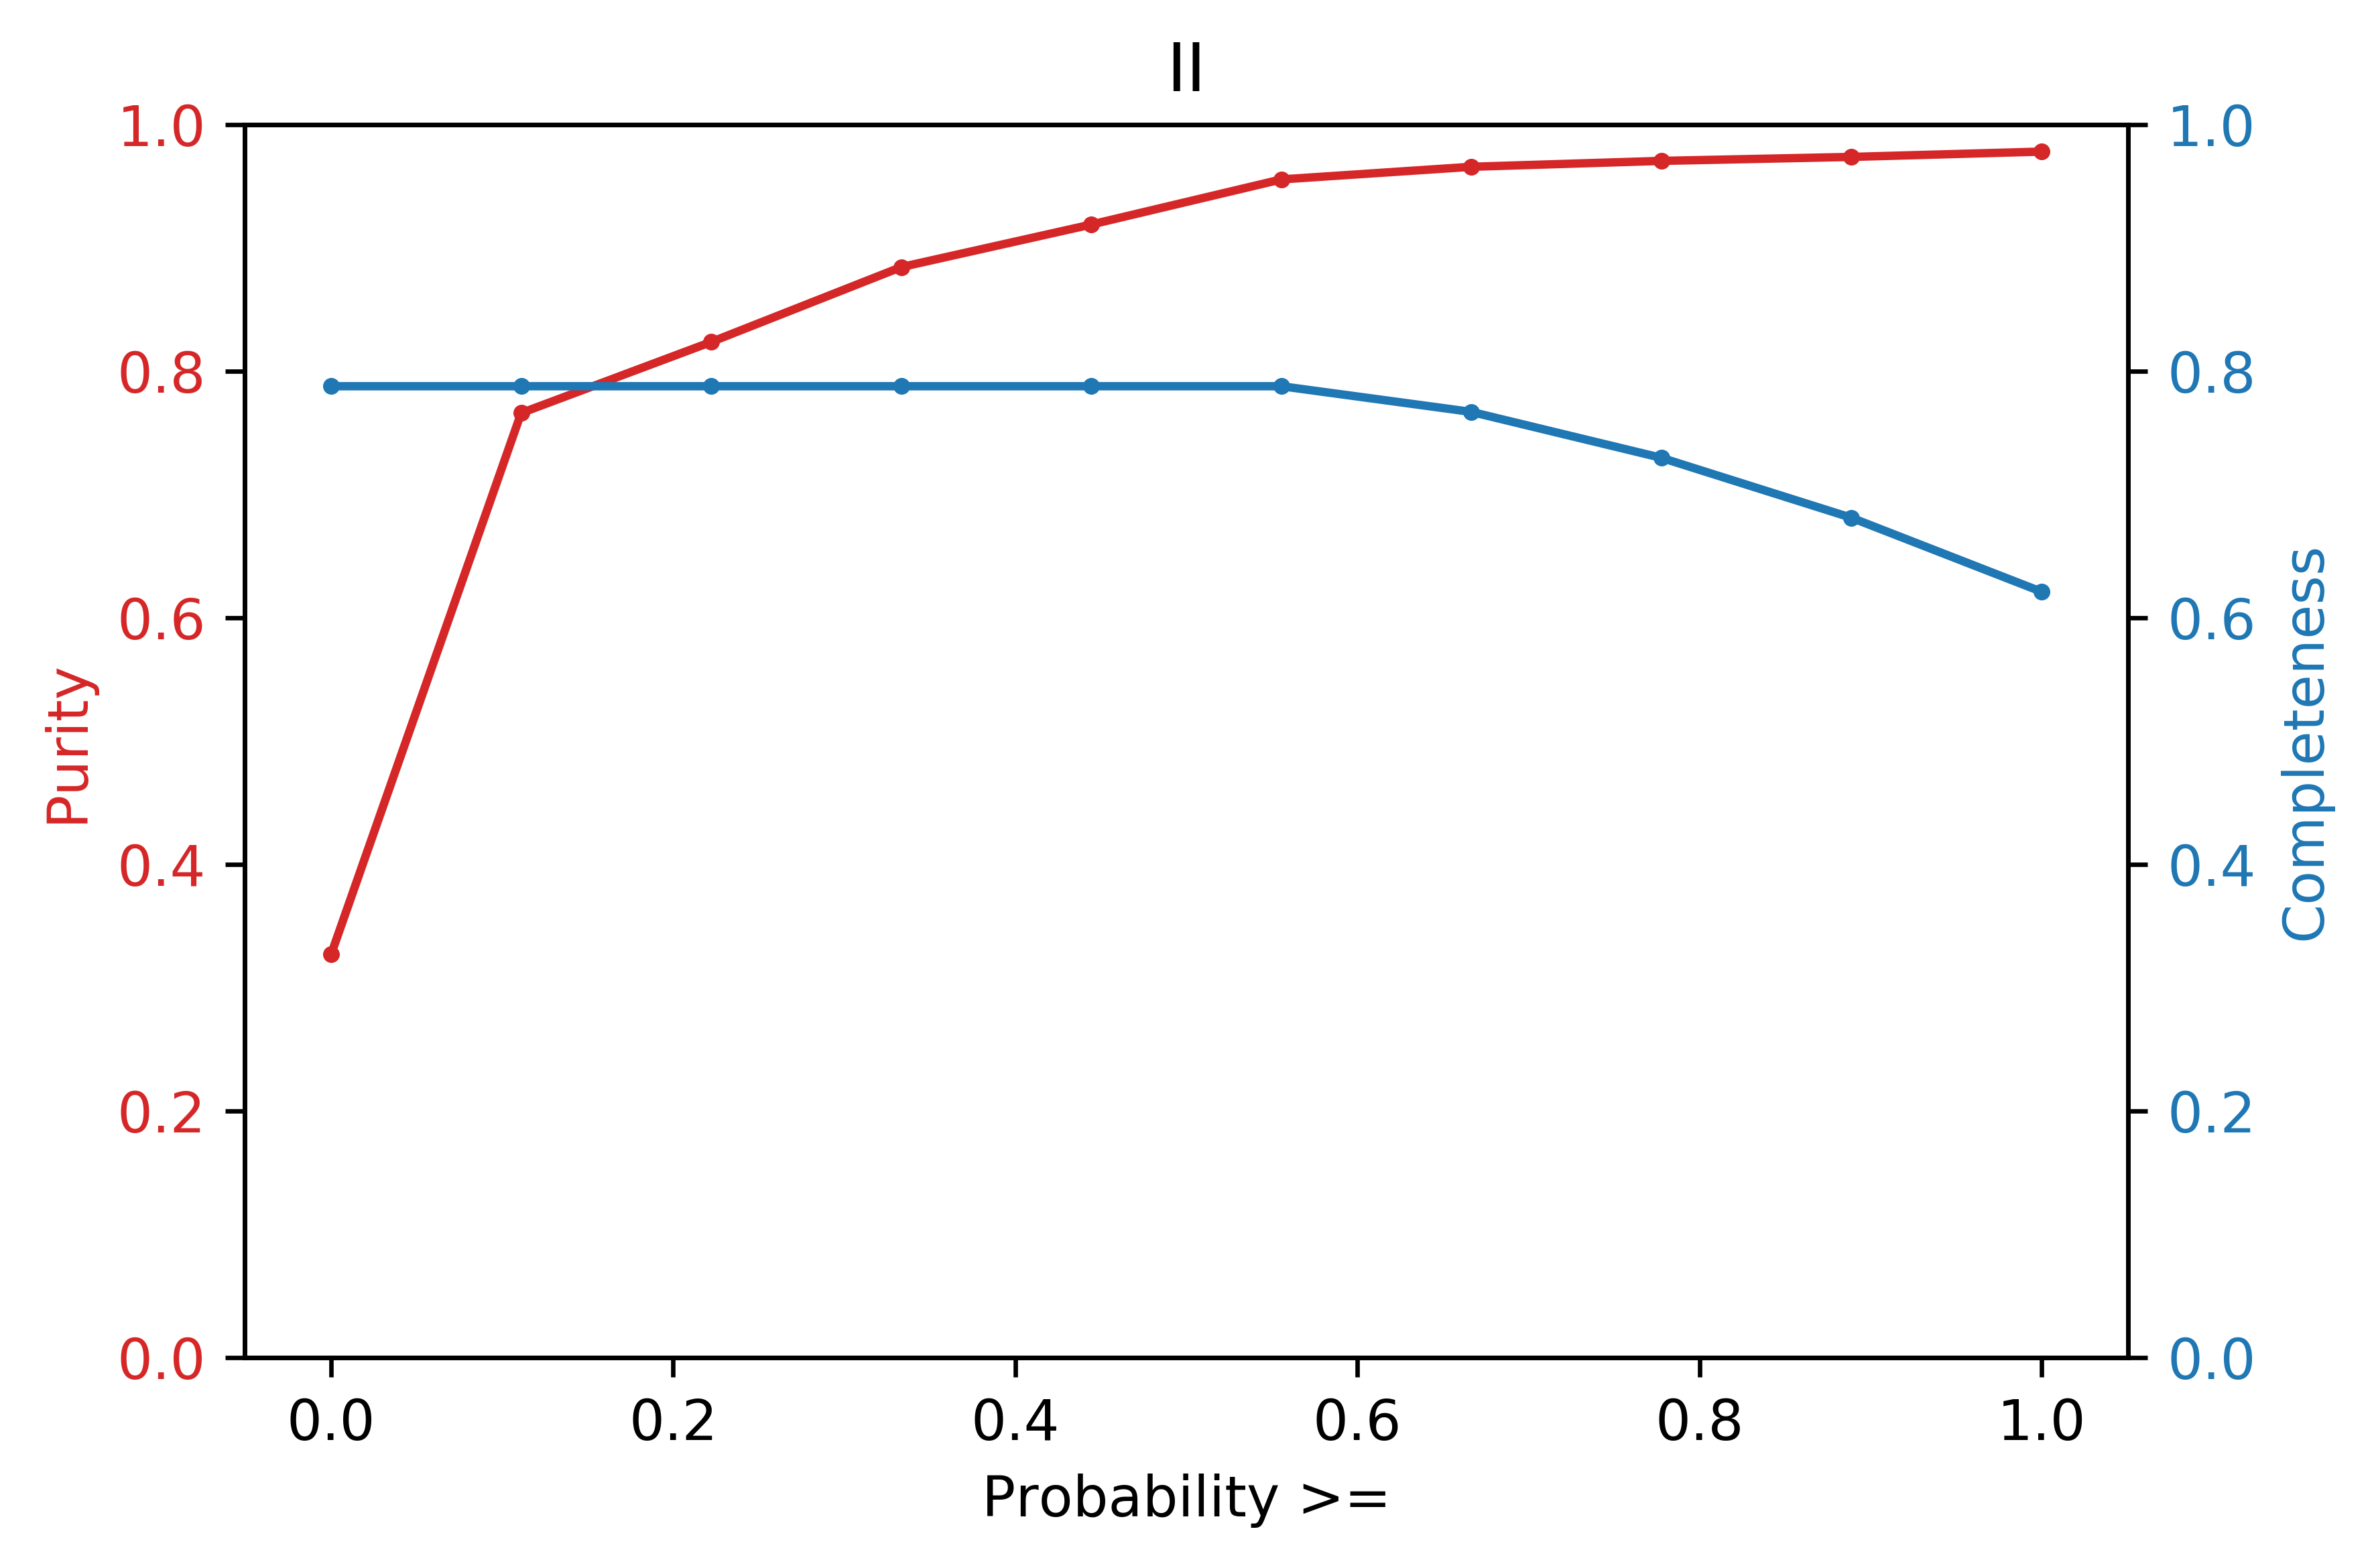

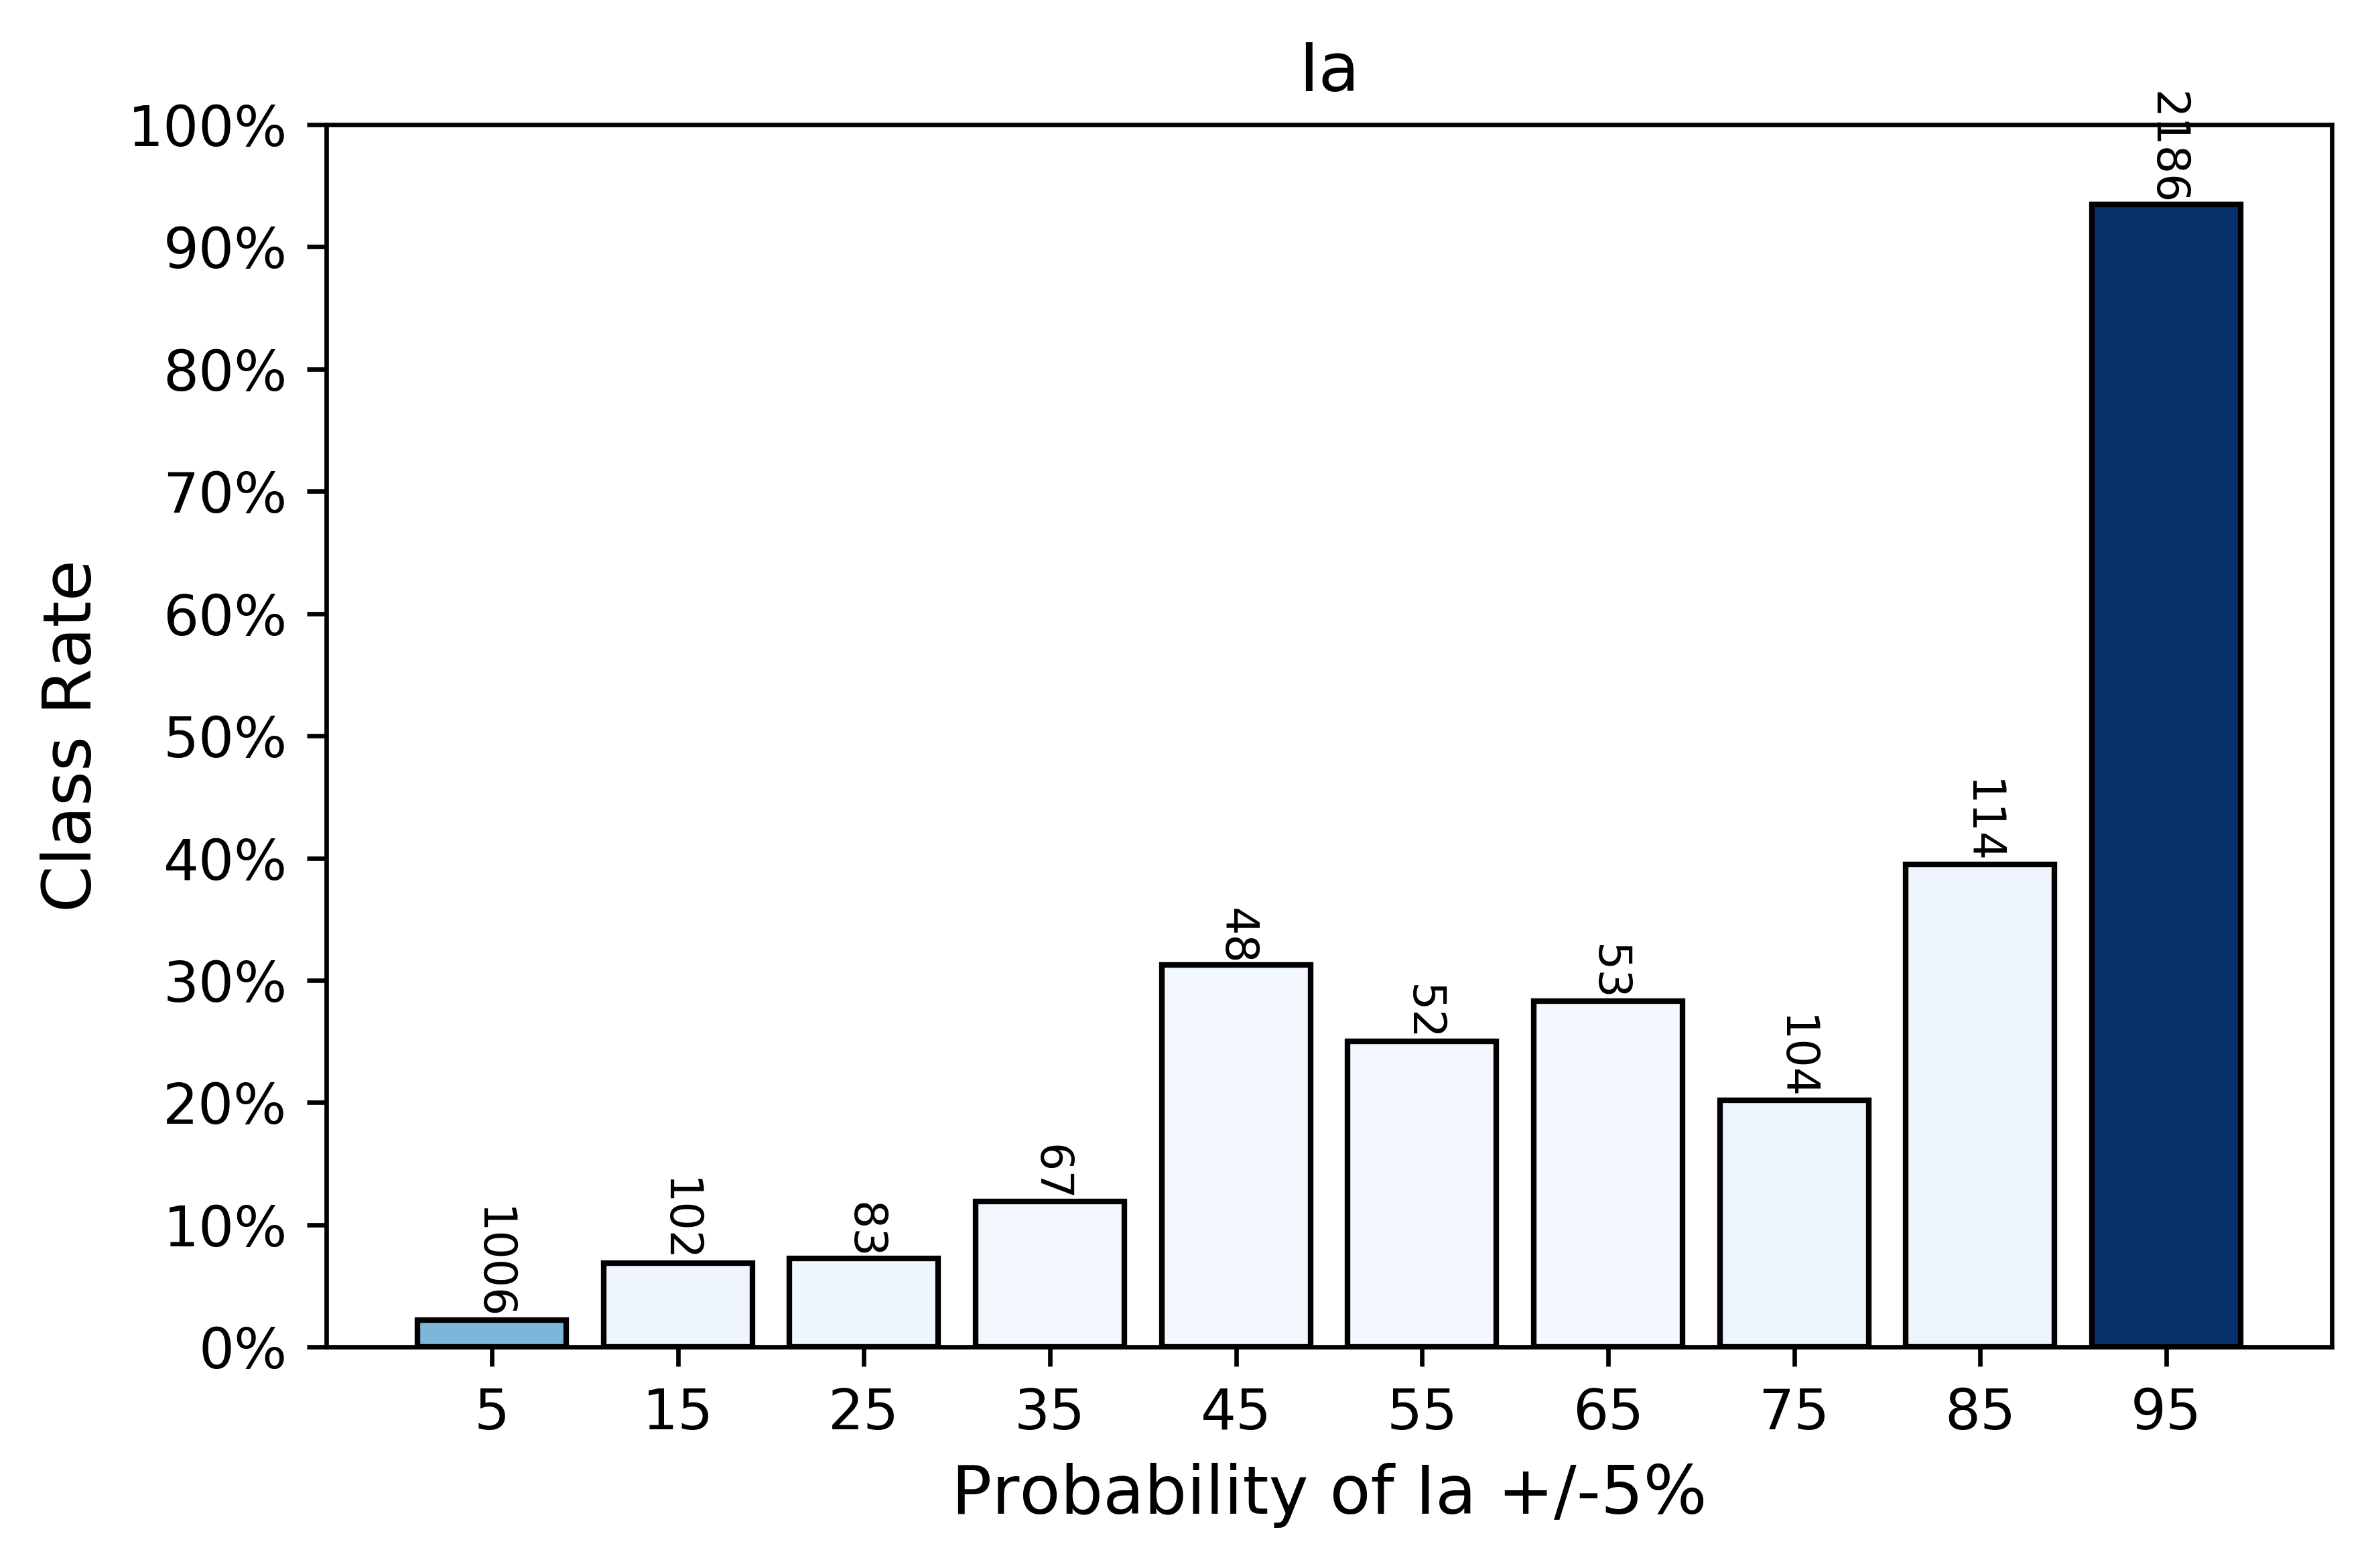

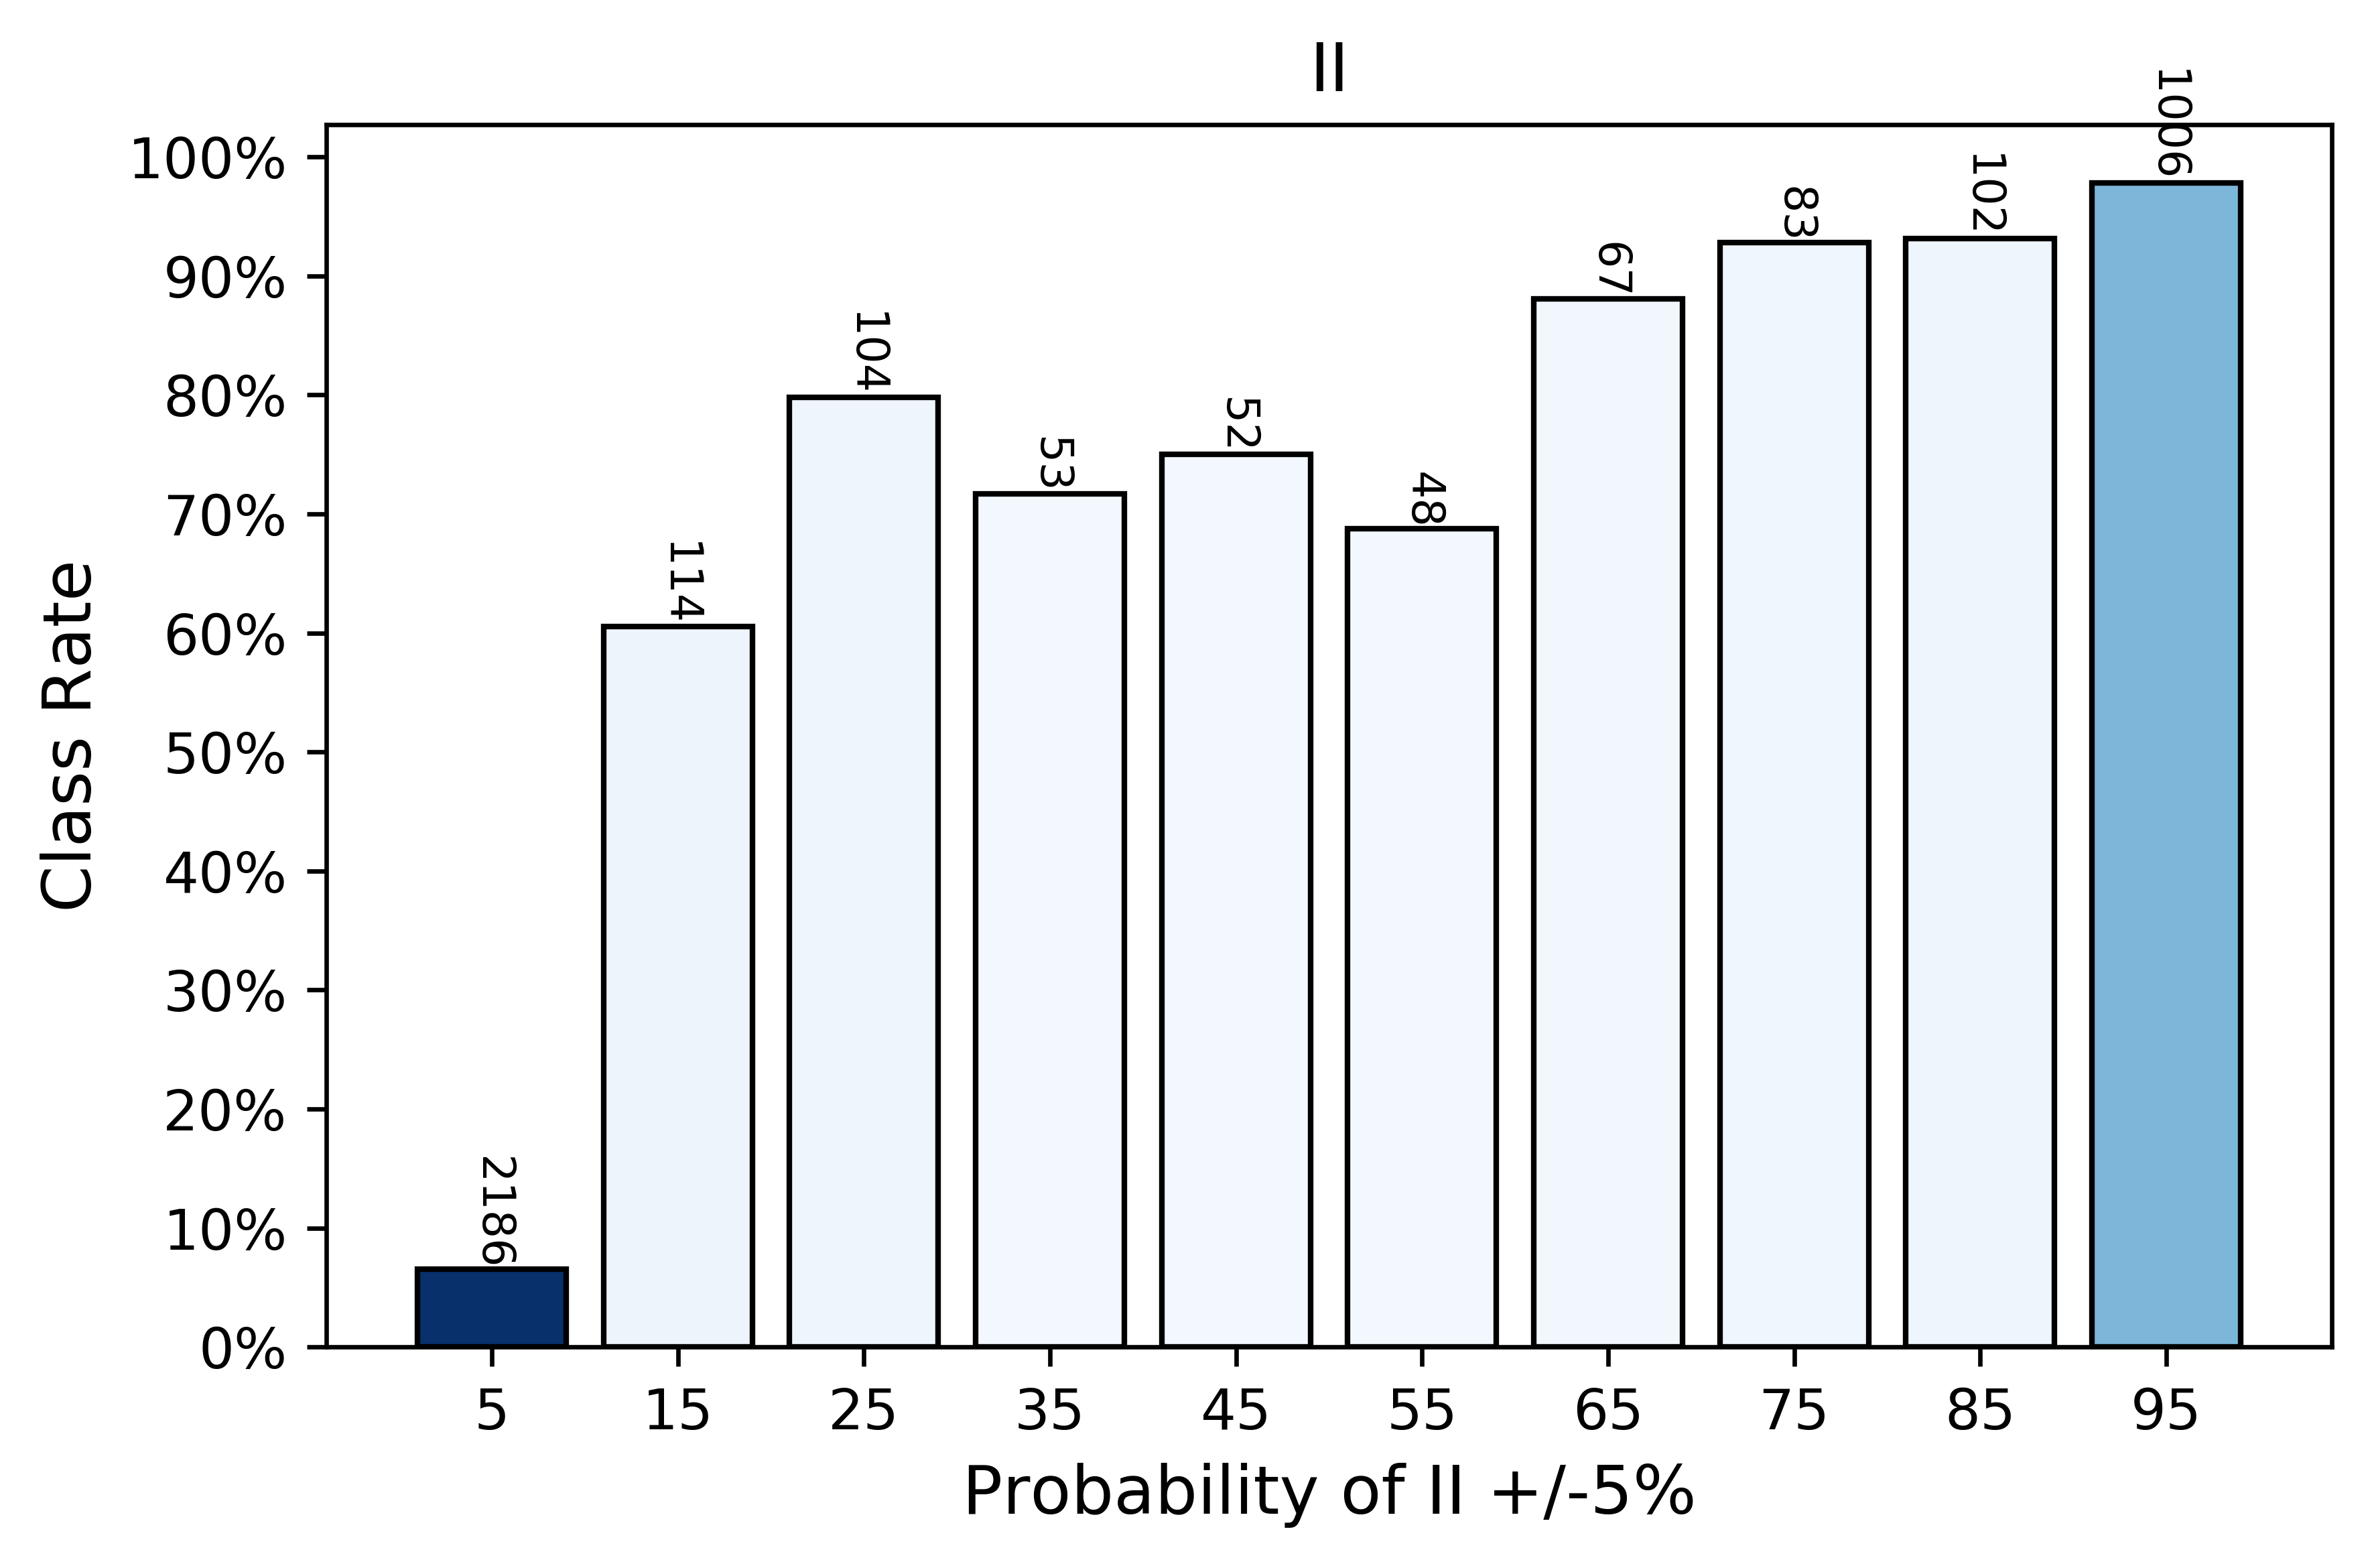

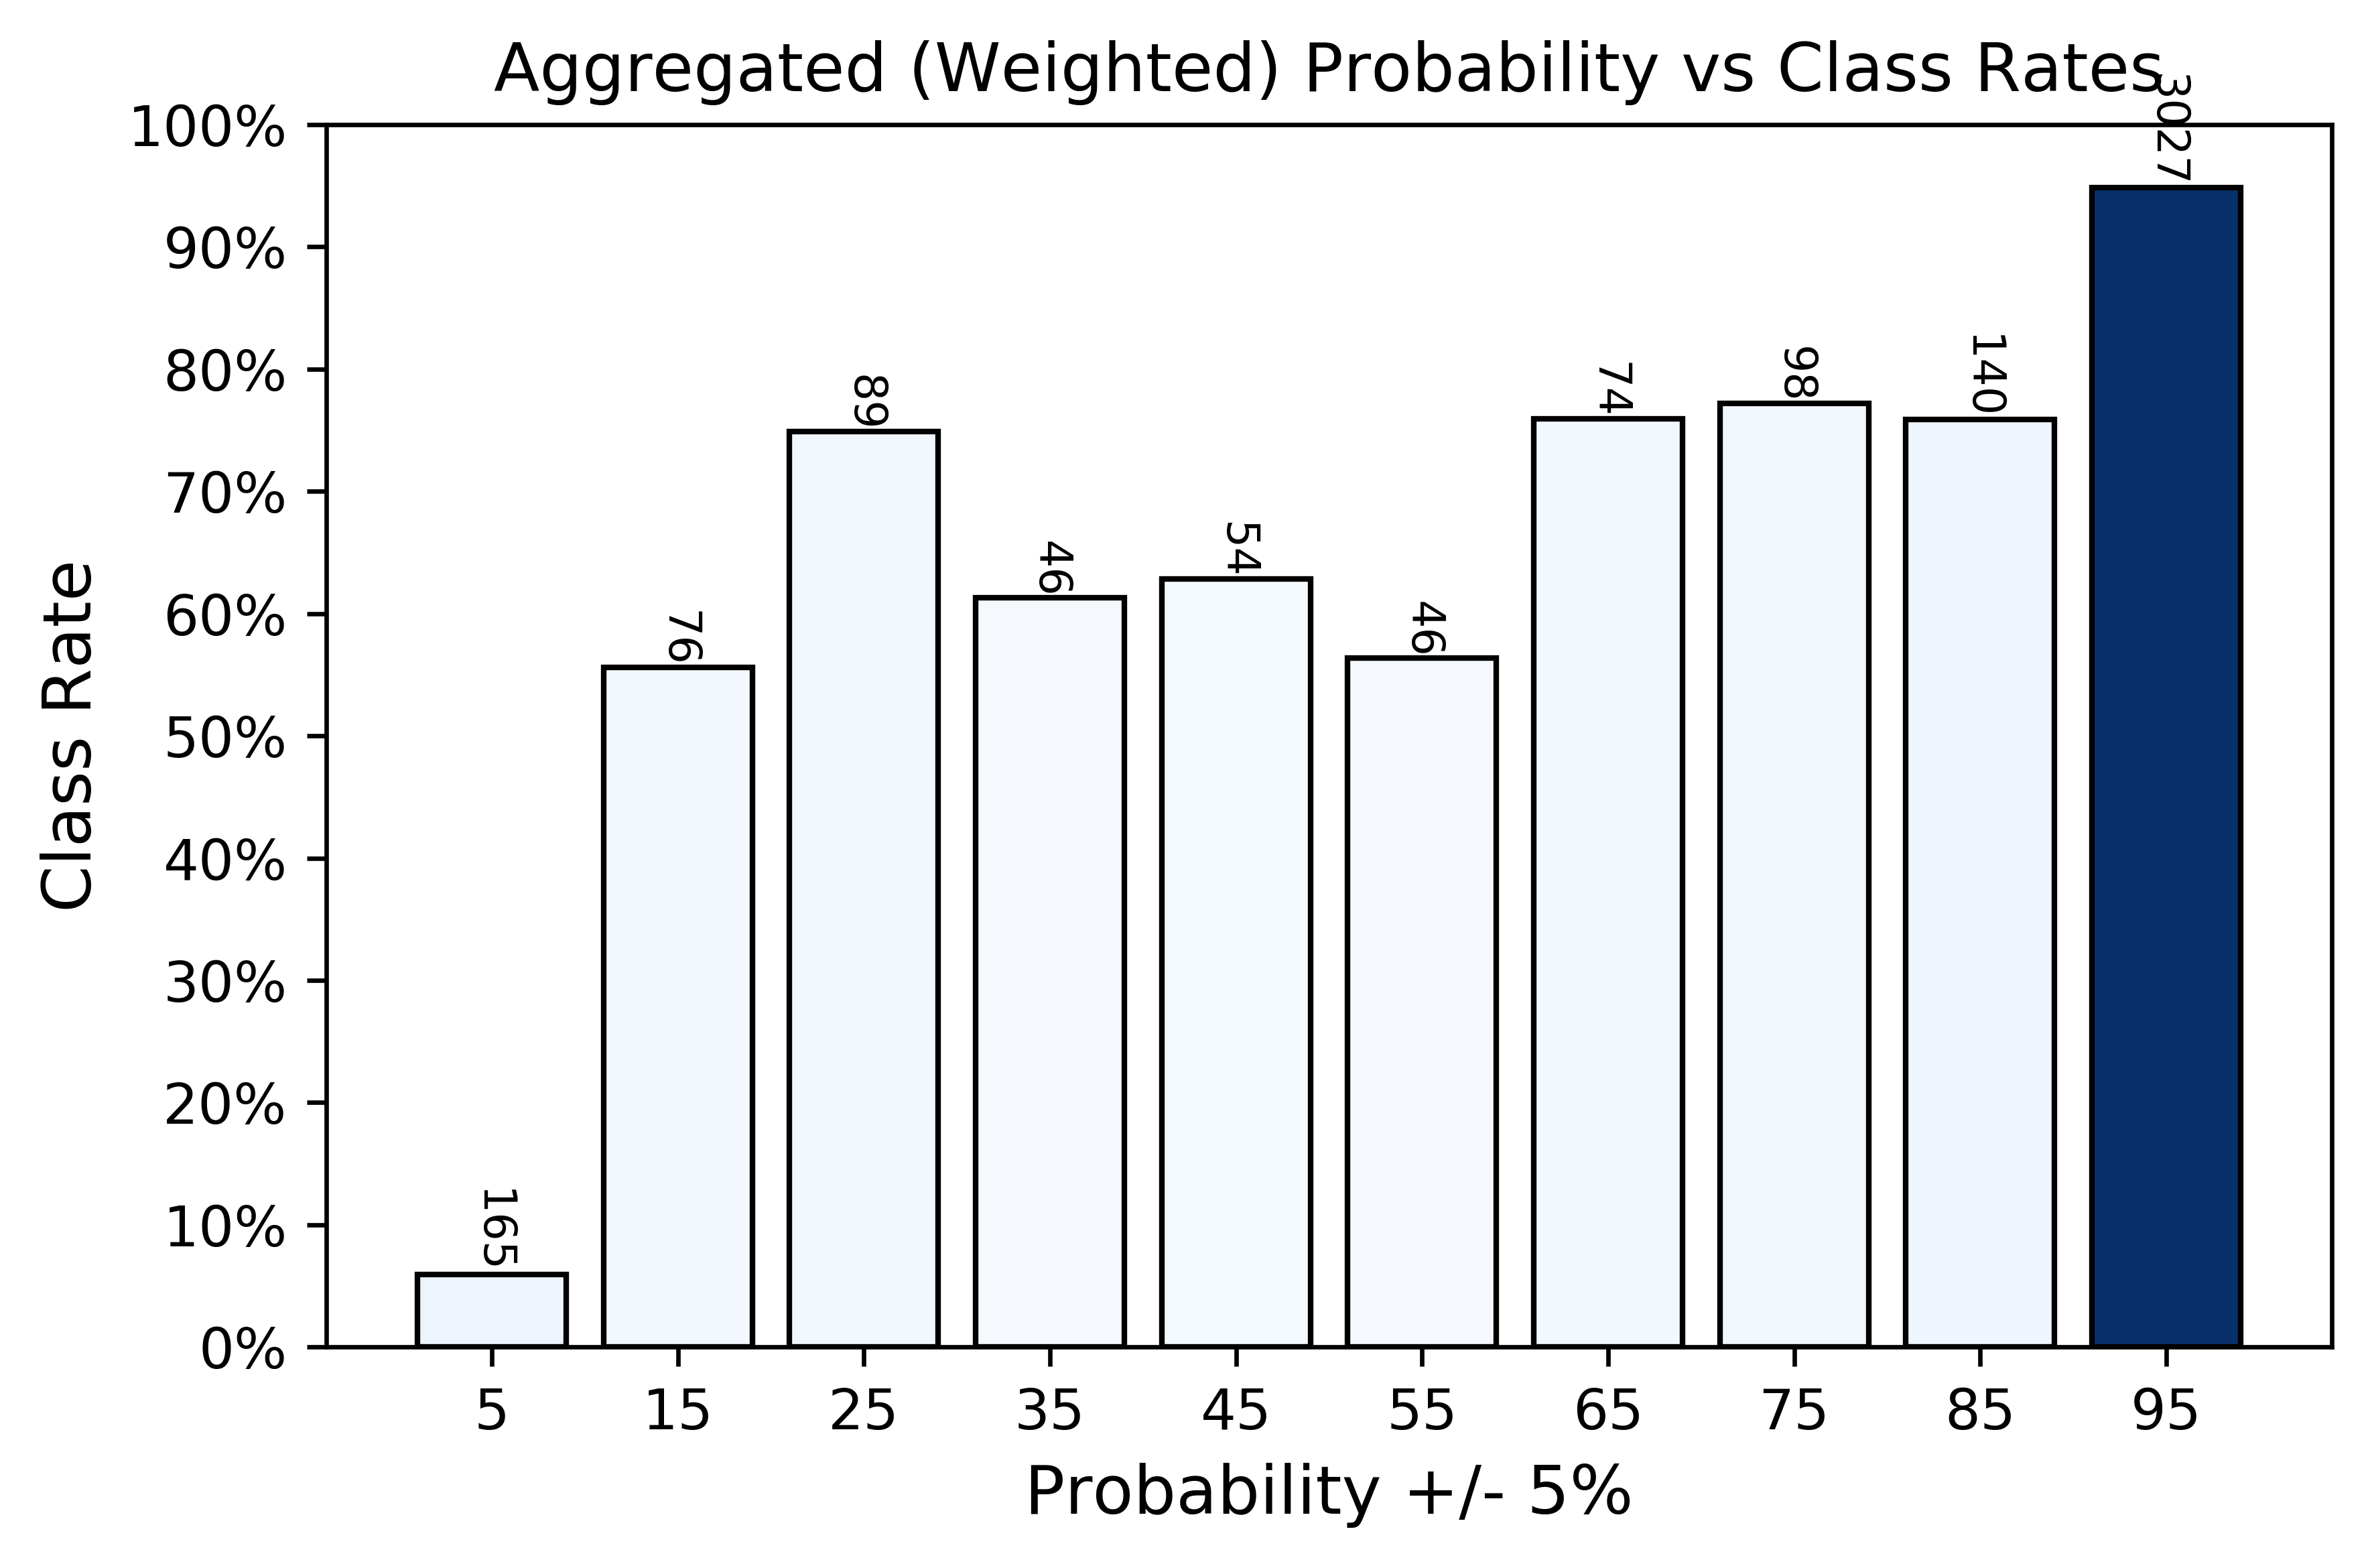

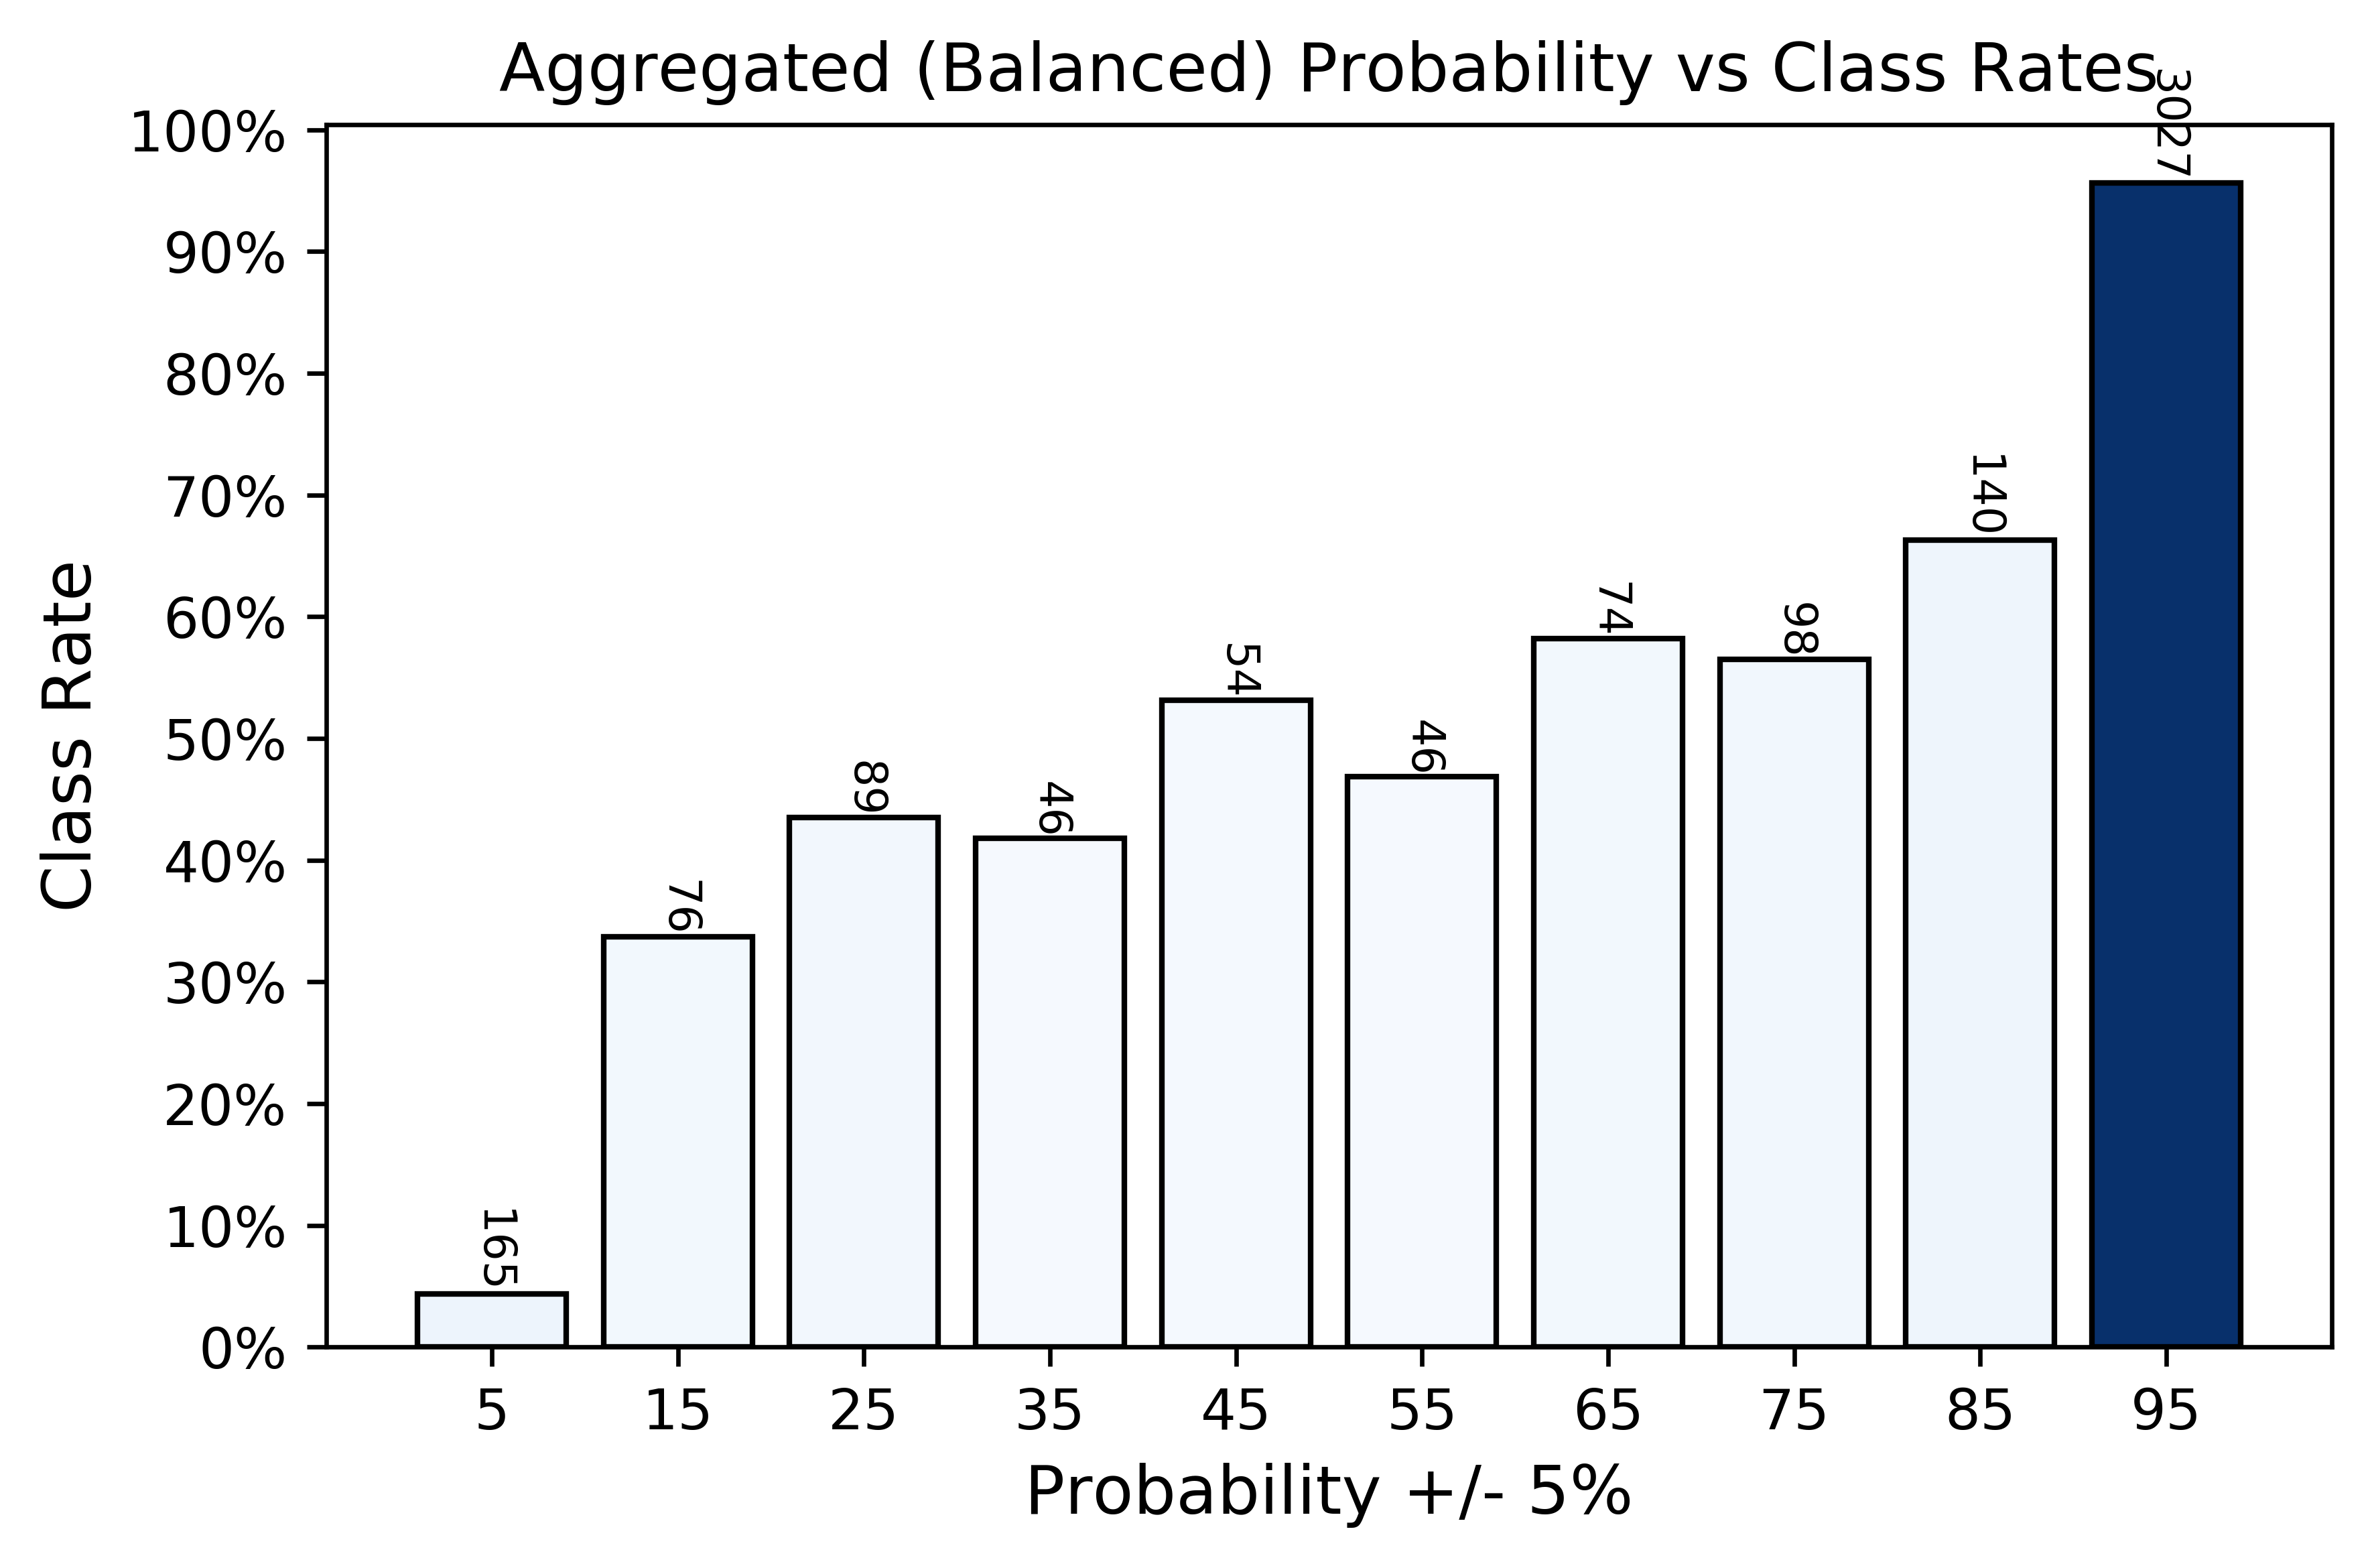

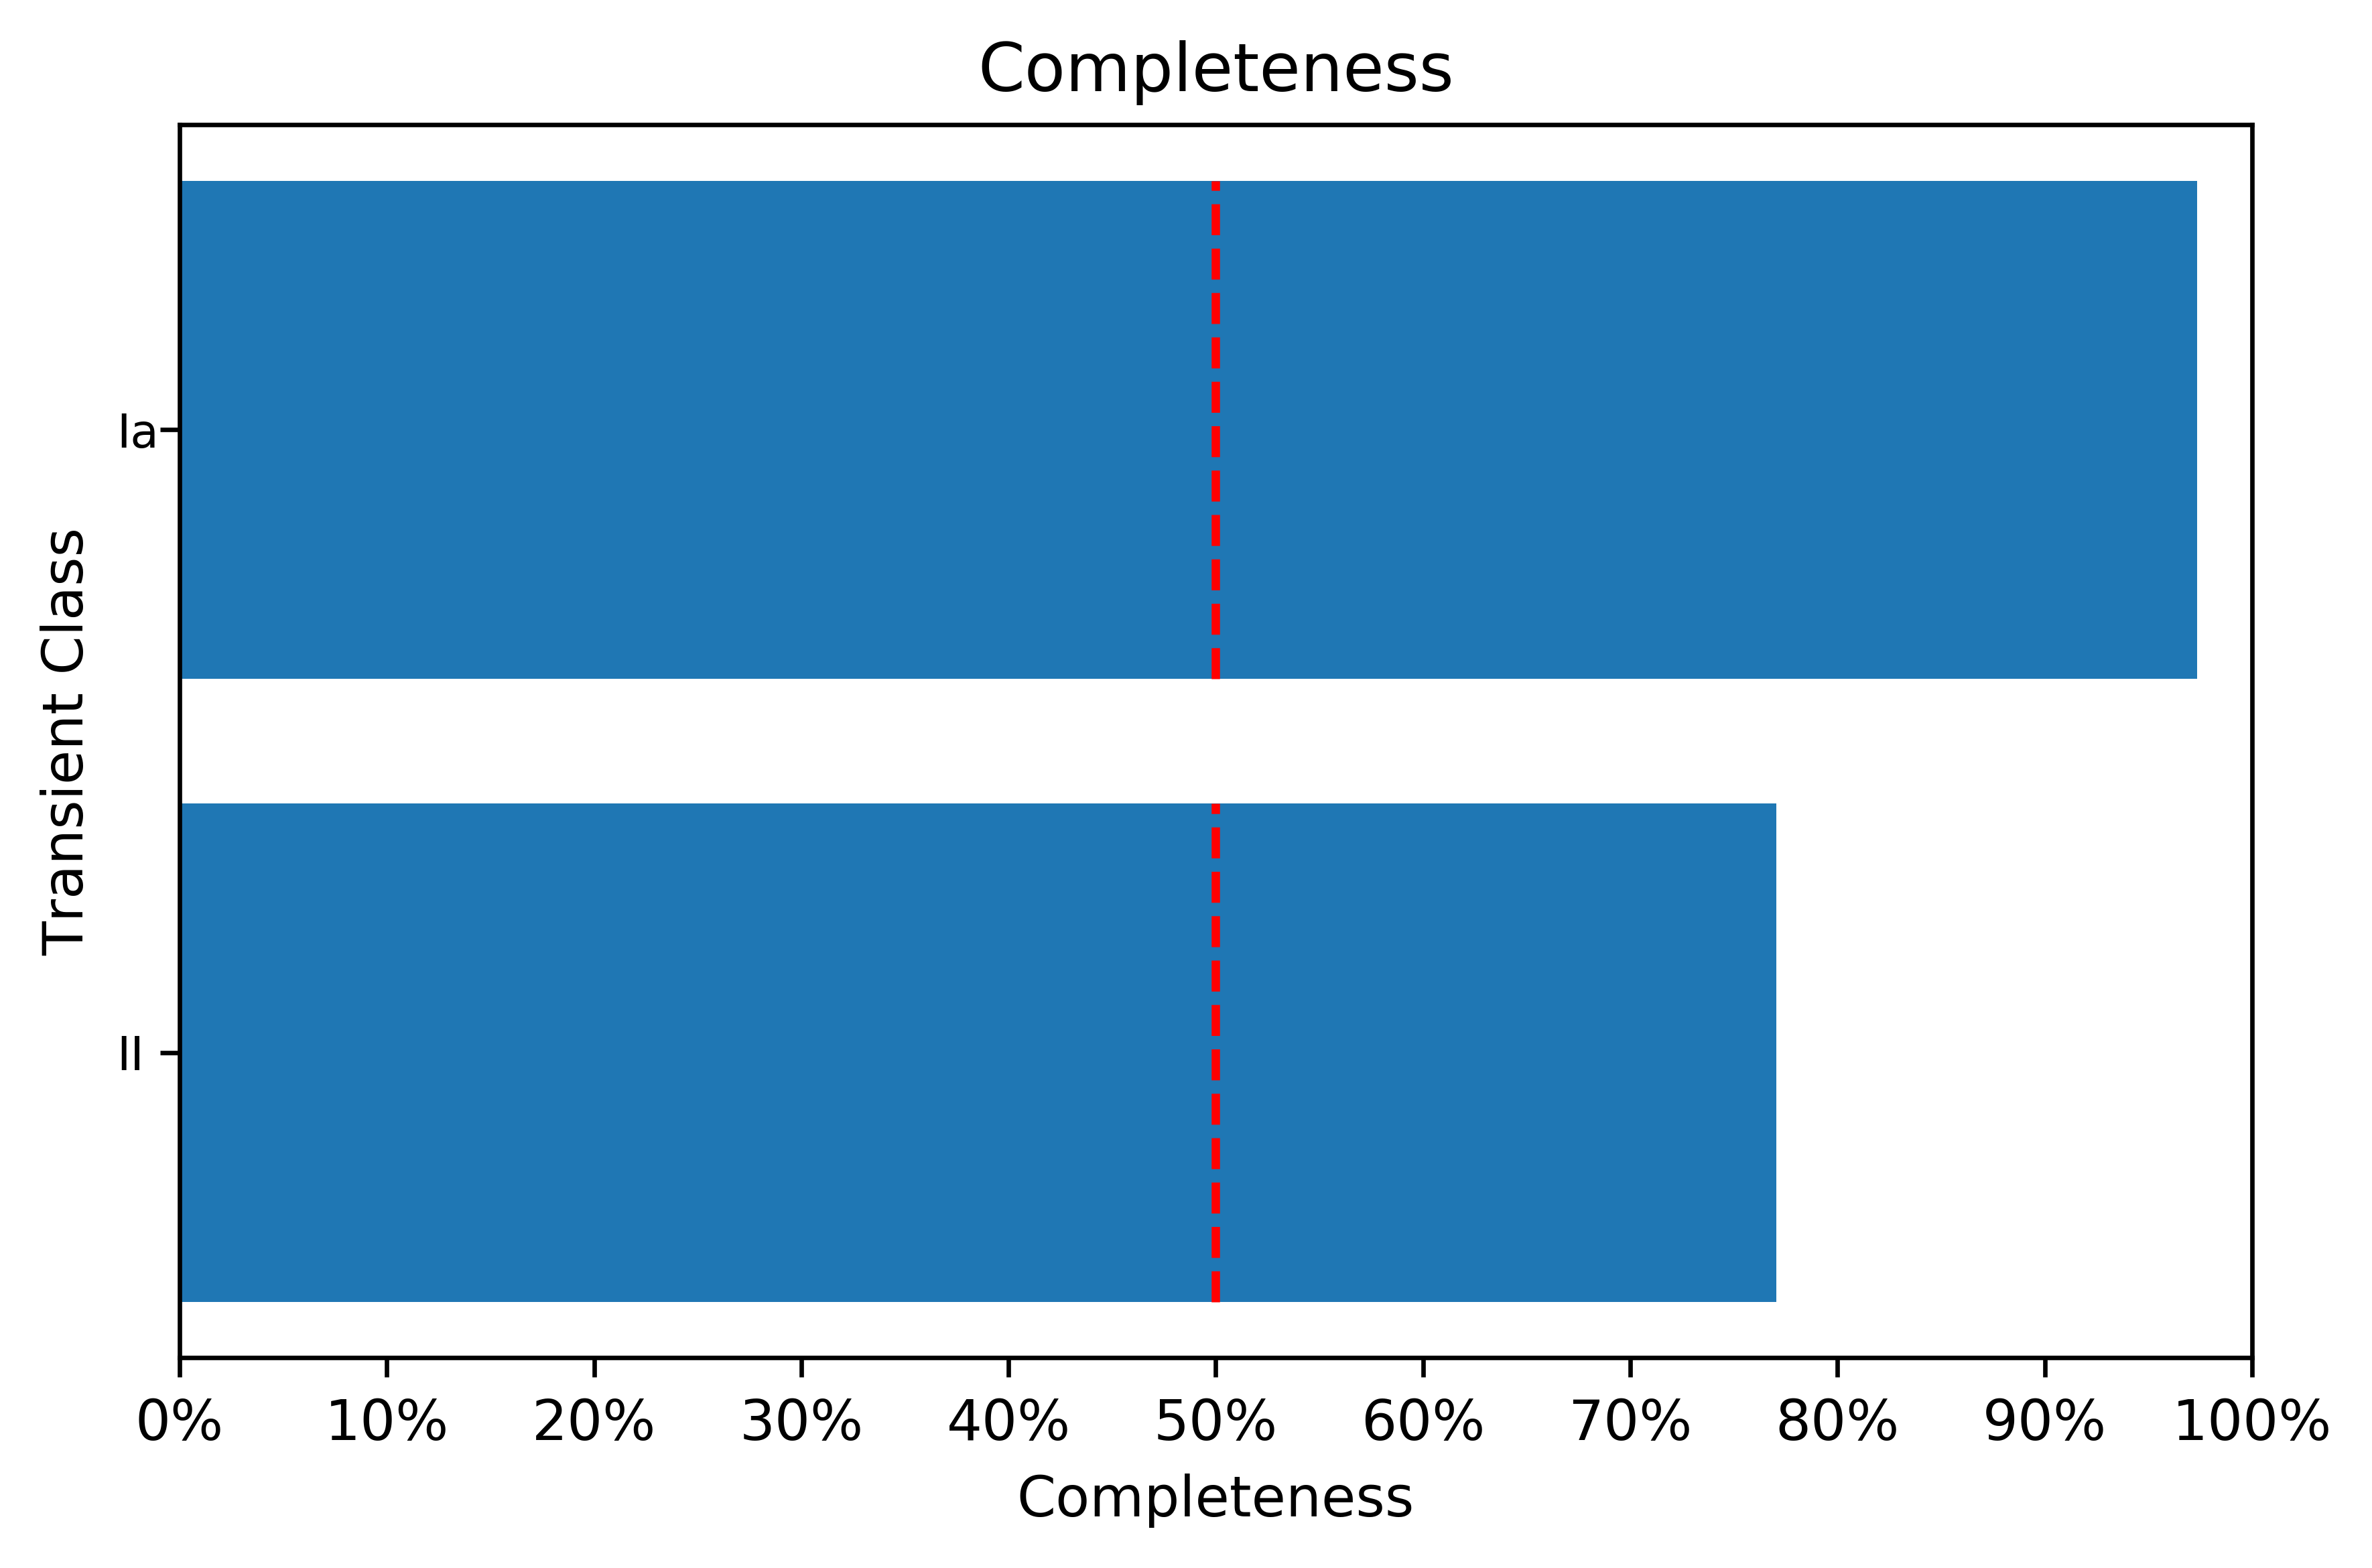

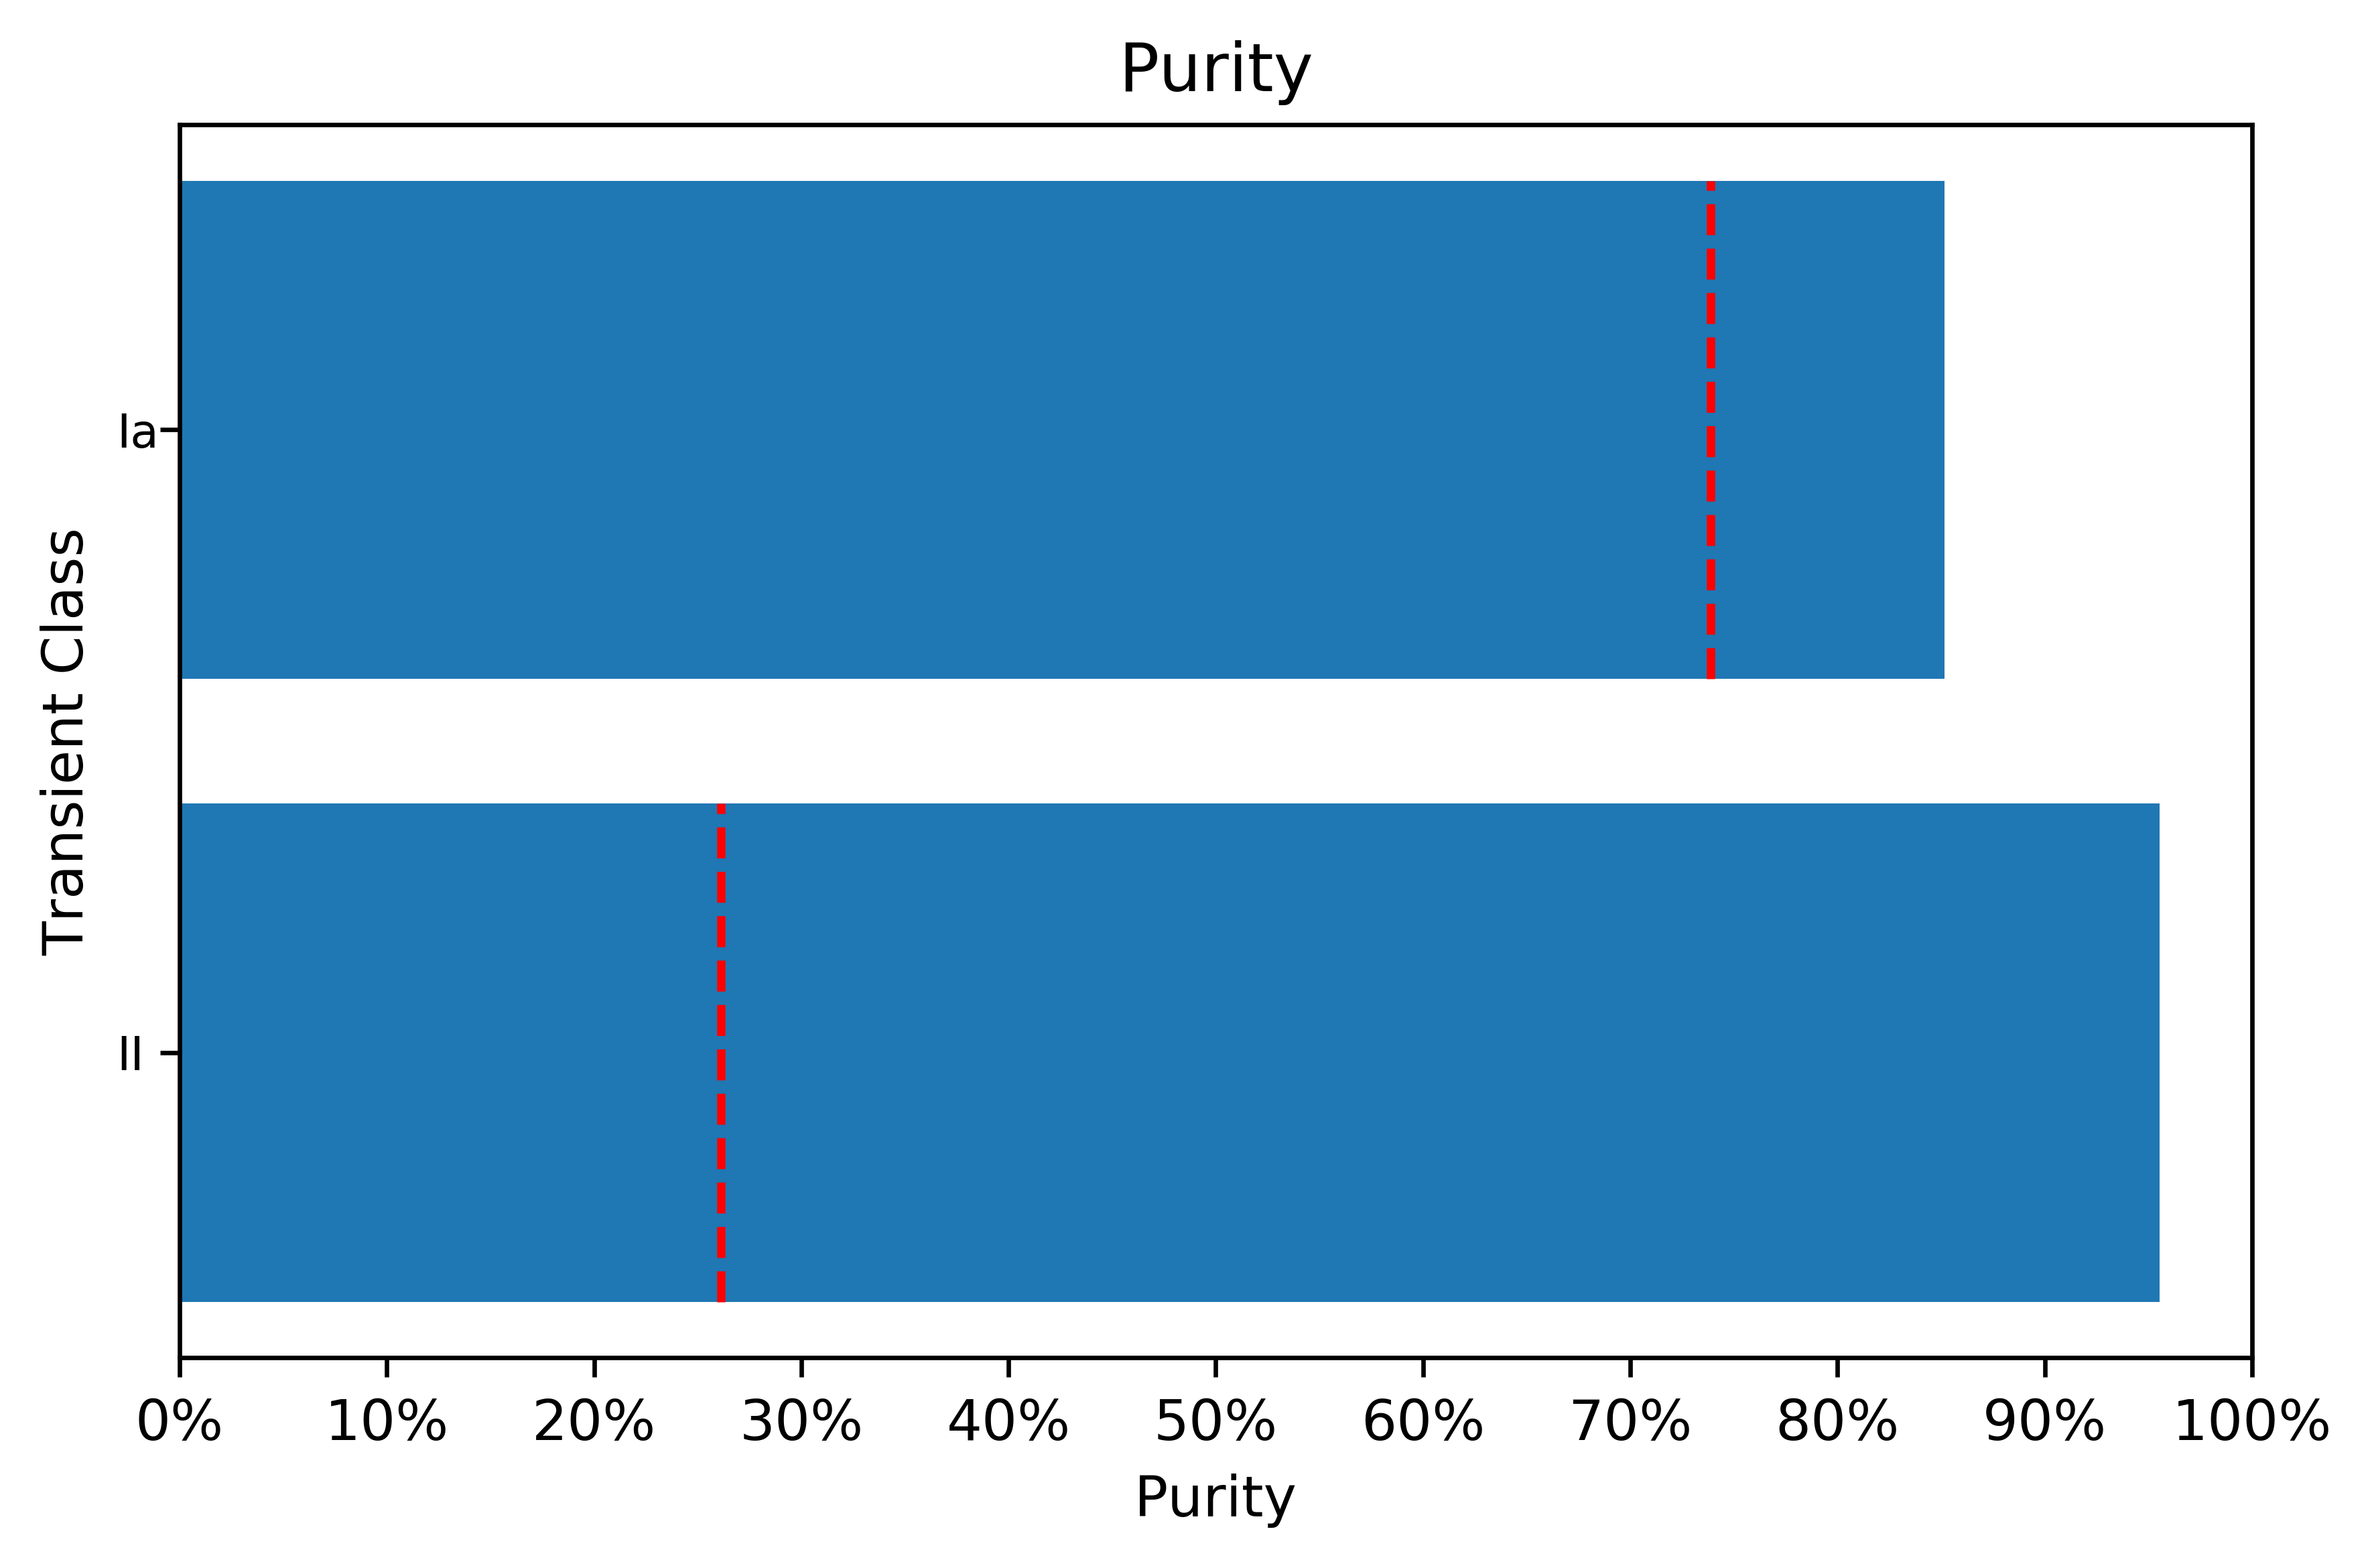

In [20]:
model.visualize_performance()

### Test with original data randomly sampled

In [21]:
# Sample randomly to have same number as in other run, 
# 324 II
# 439 Ia
thex_dataset = get_data('g_W2')
Ia_data = get_thex_class_data("Ia", thex_dataset)
Ia_data = Ia_data.sample(439).reset_index(drop=True)
II_data = get_thex_class_data("II", thex_dataset)
II_data = II_data.sample(324).reset_index(drop=True)
combined_df = pd.concat([Ia_data, II_data])
combined_df = combined_df.sample(frac=1).reset_index(drop=True)
y_orig_sampled = combined_df[['transient_type']] 
X_orig_sampled = combined_df.drop(labels=['transient_type'], axis=1 )

In [29]:
# Rearrange columns to be in same order as X used by model for training. 
X_orig_sampled = X_orig_sampled[['K_mag',
 'i_mag',
 'W1_mag',
 'W2_mag',
 'H_mag',
 'redshift',
 'J_mag',
 'r_mag',
 'z_mag',
 'g_mag',
 'y_mag']]

In [30]:
model = MultiModel(cols = mags,
#            data = [X, y],
           class_labels = ['Ia', 'II'],
           transform_features = False,
           min_class_size = 40,
           folds=20
          )
# model.run_model()




In [31]:
results = []
N = 5
for i in range(N):
    X_train, y_train, X_test, y_test = model.manually_stratify(model.X, model.y, .8)
    model.train_model(X_train, y_train)

    # Test model 
    probabilities = model.get_all_class_probabilities(X_orig_sampled, model.normalize)
    # Add labels as column to probabilities, for later evaluation
    label_column = y_orig_sampled['transient_type'].values.reshape(-1, 1)
    probabilities = np.hstack((probabilities, label_column))
    results.append(probabilities)

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWar

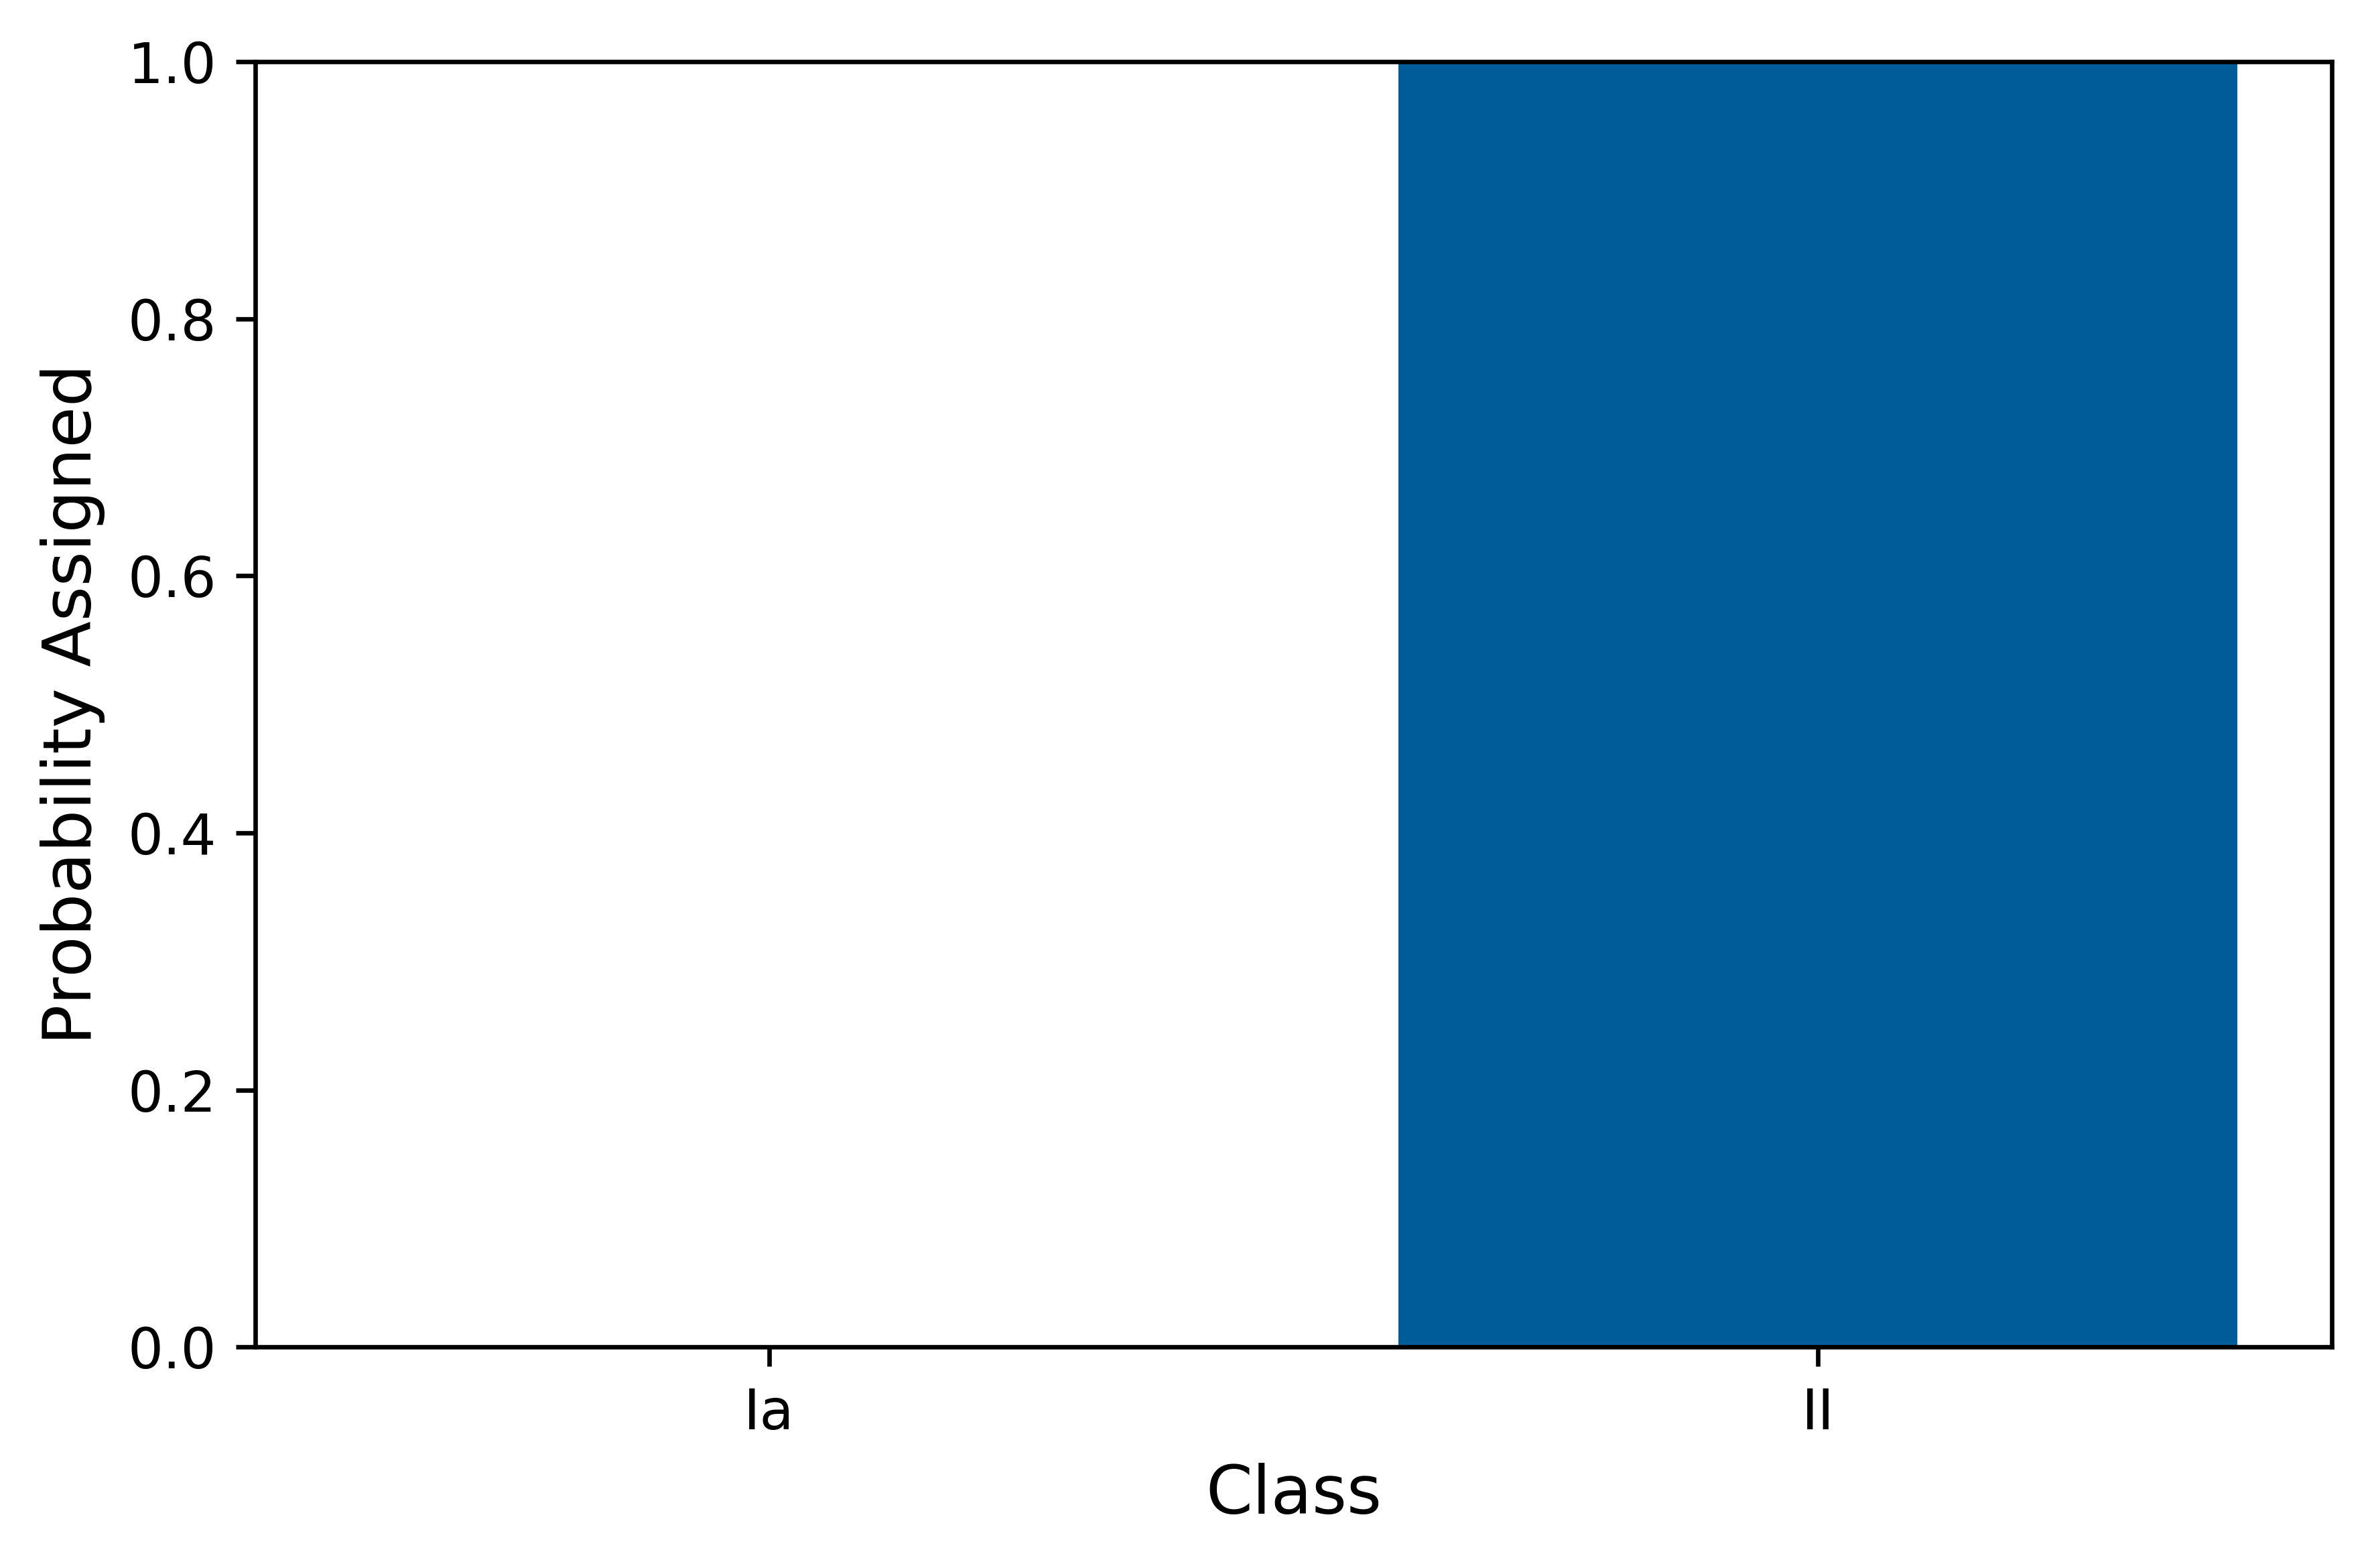

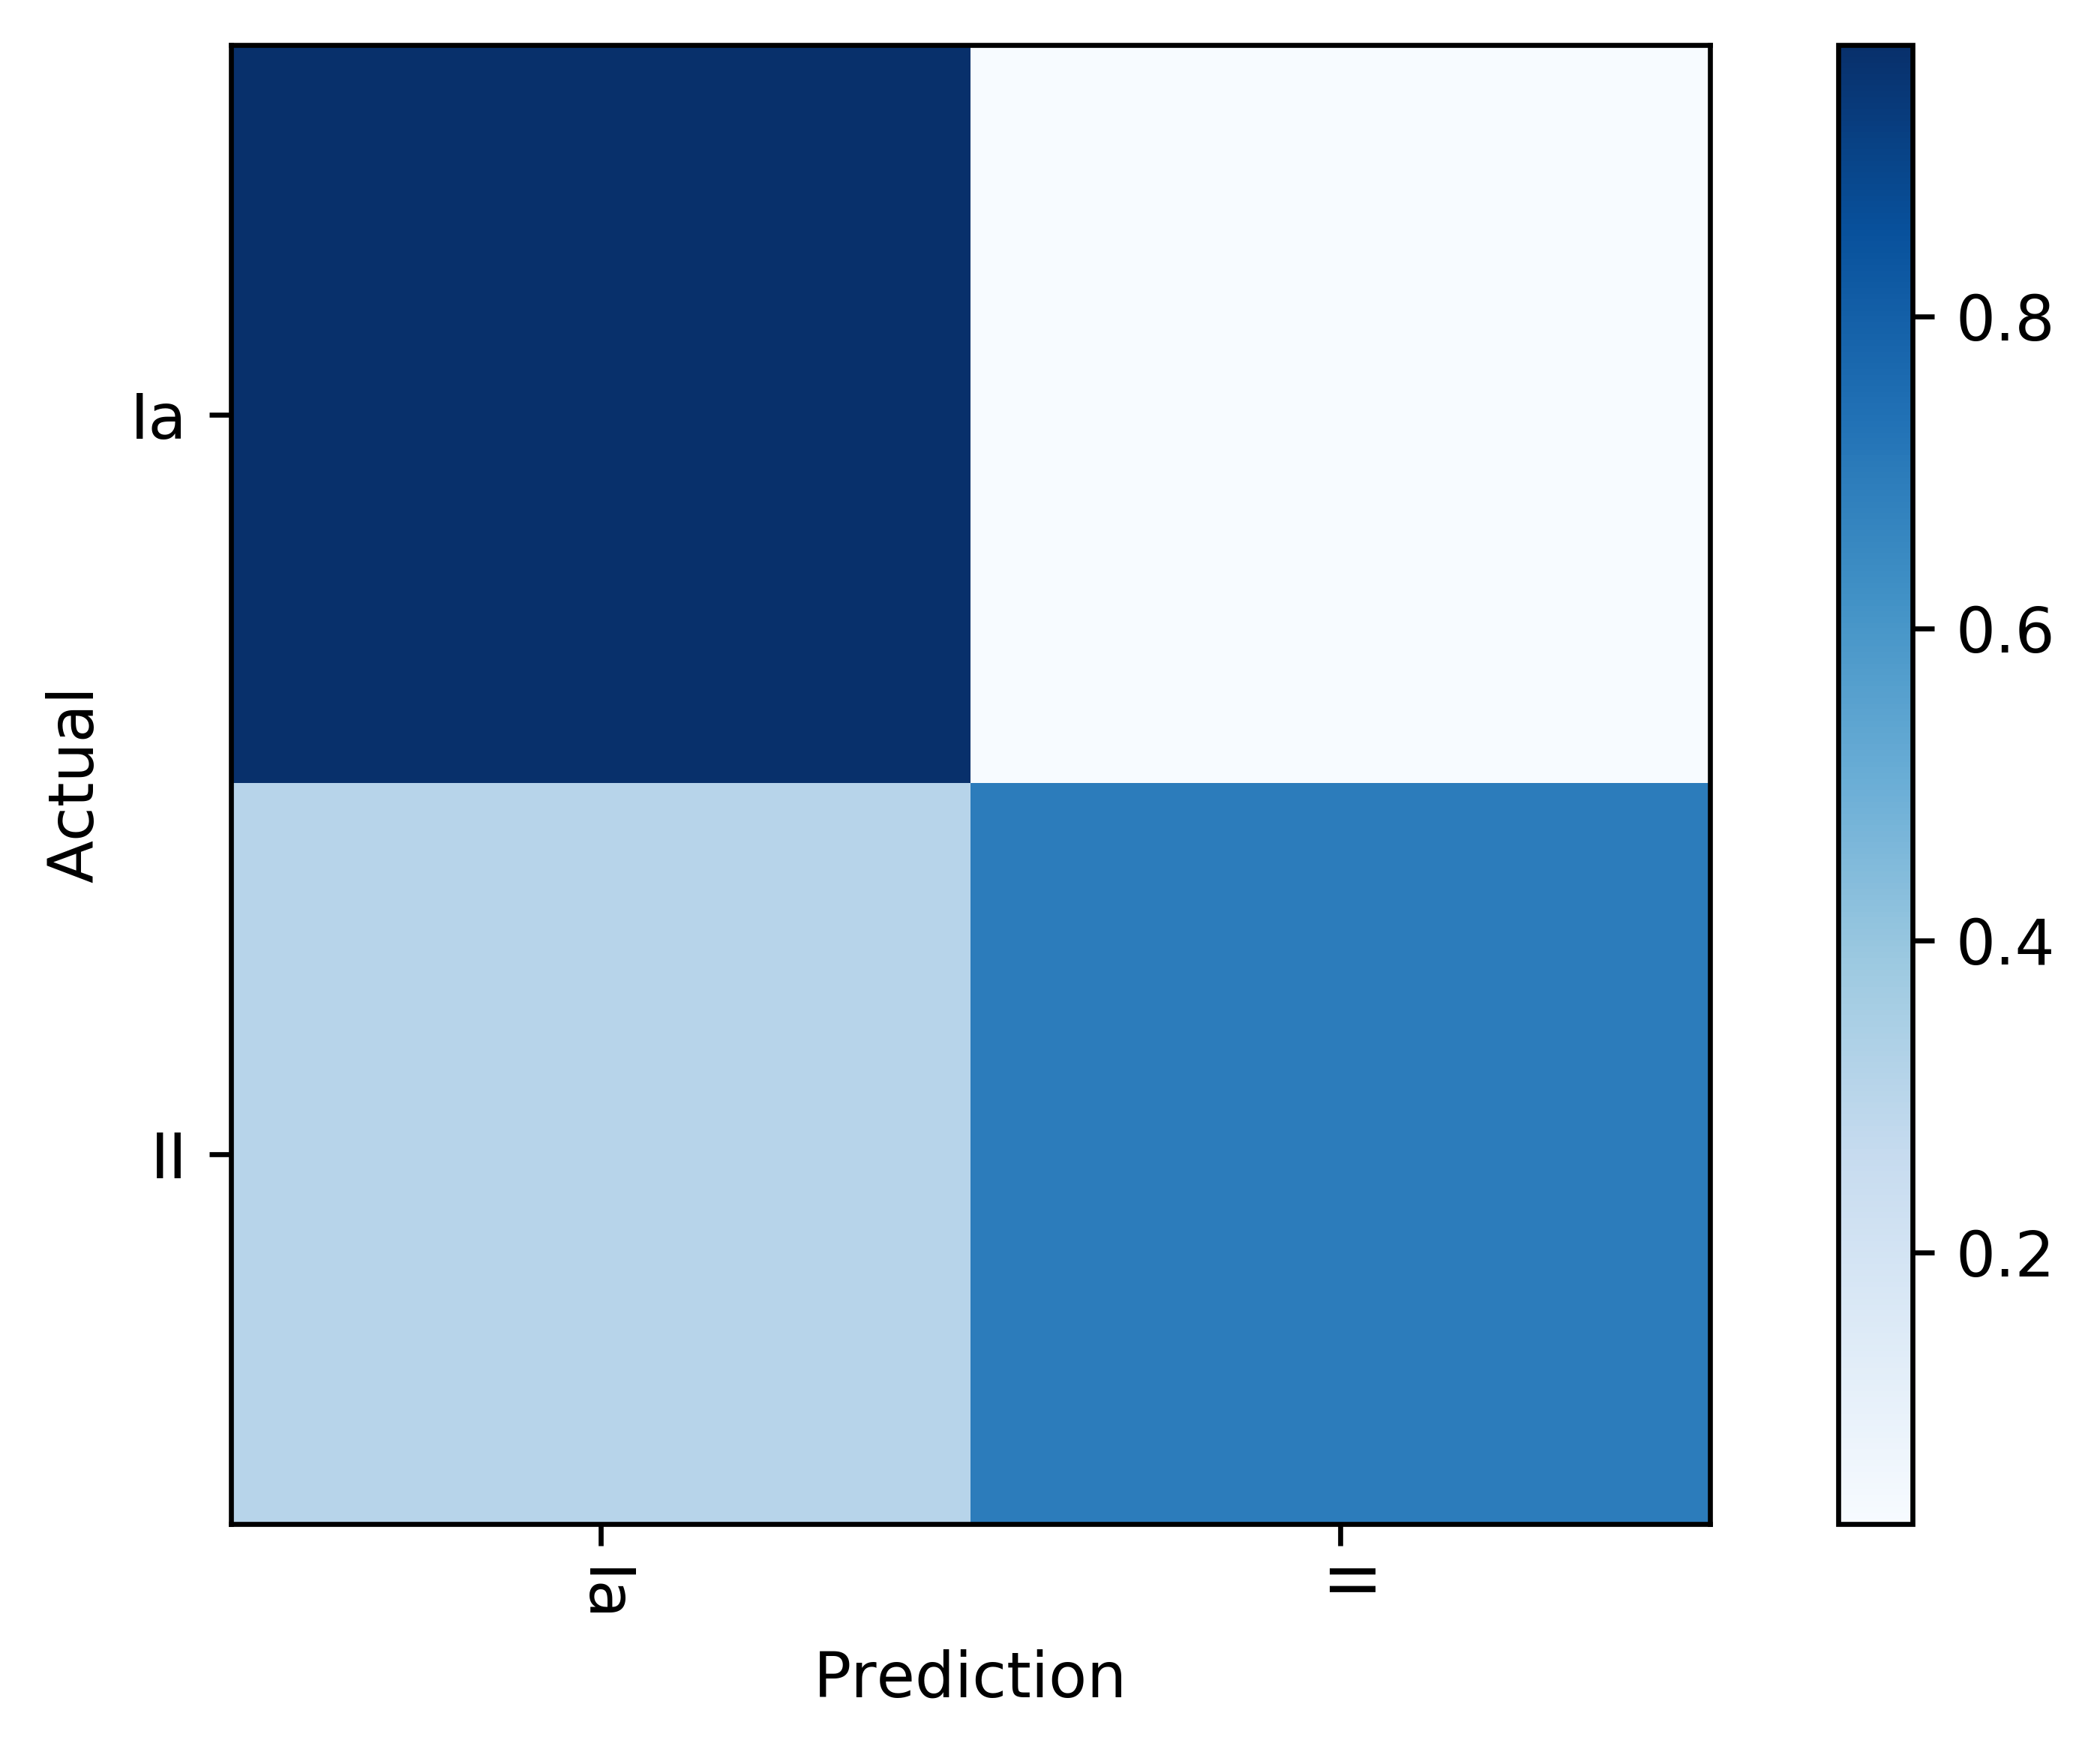

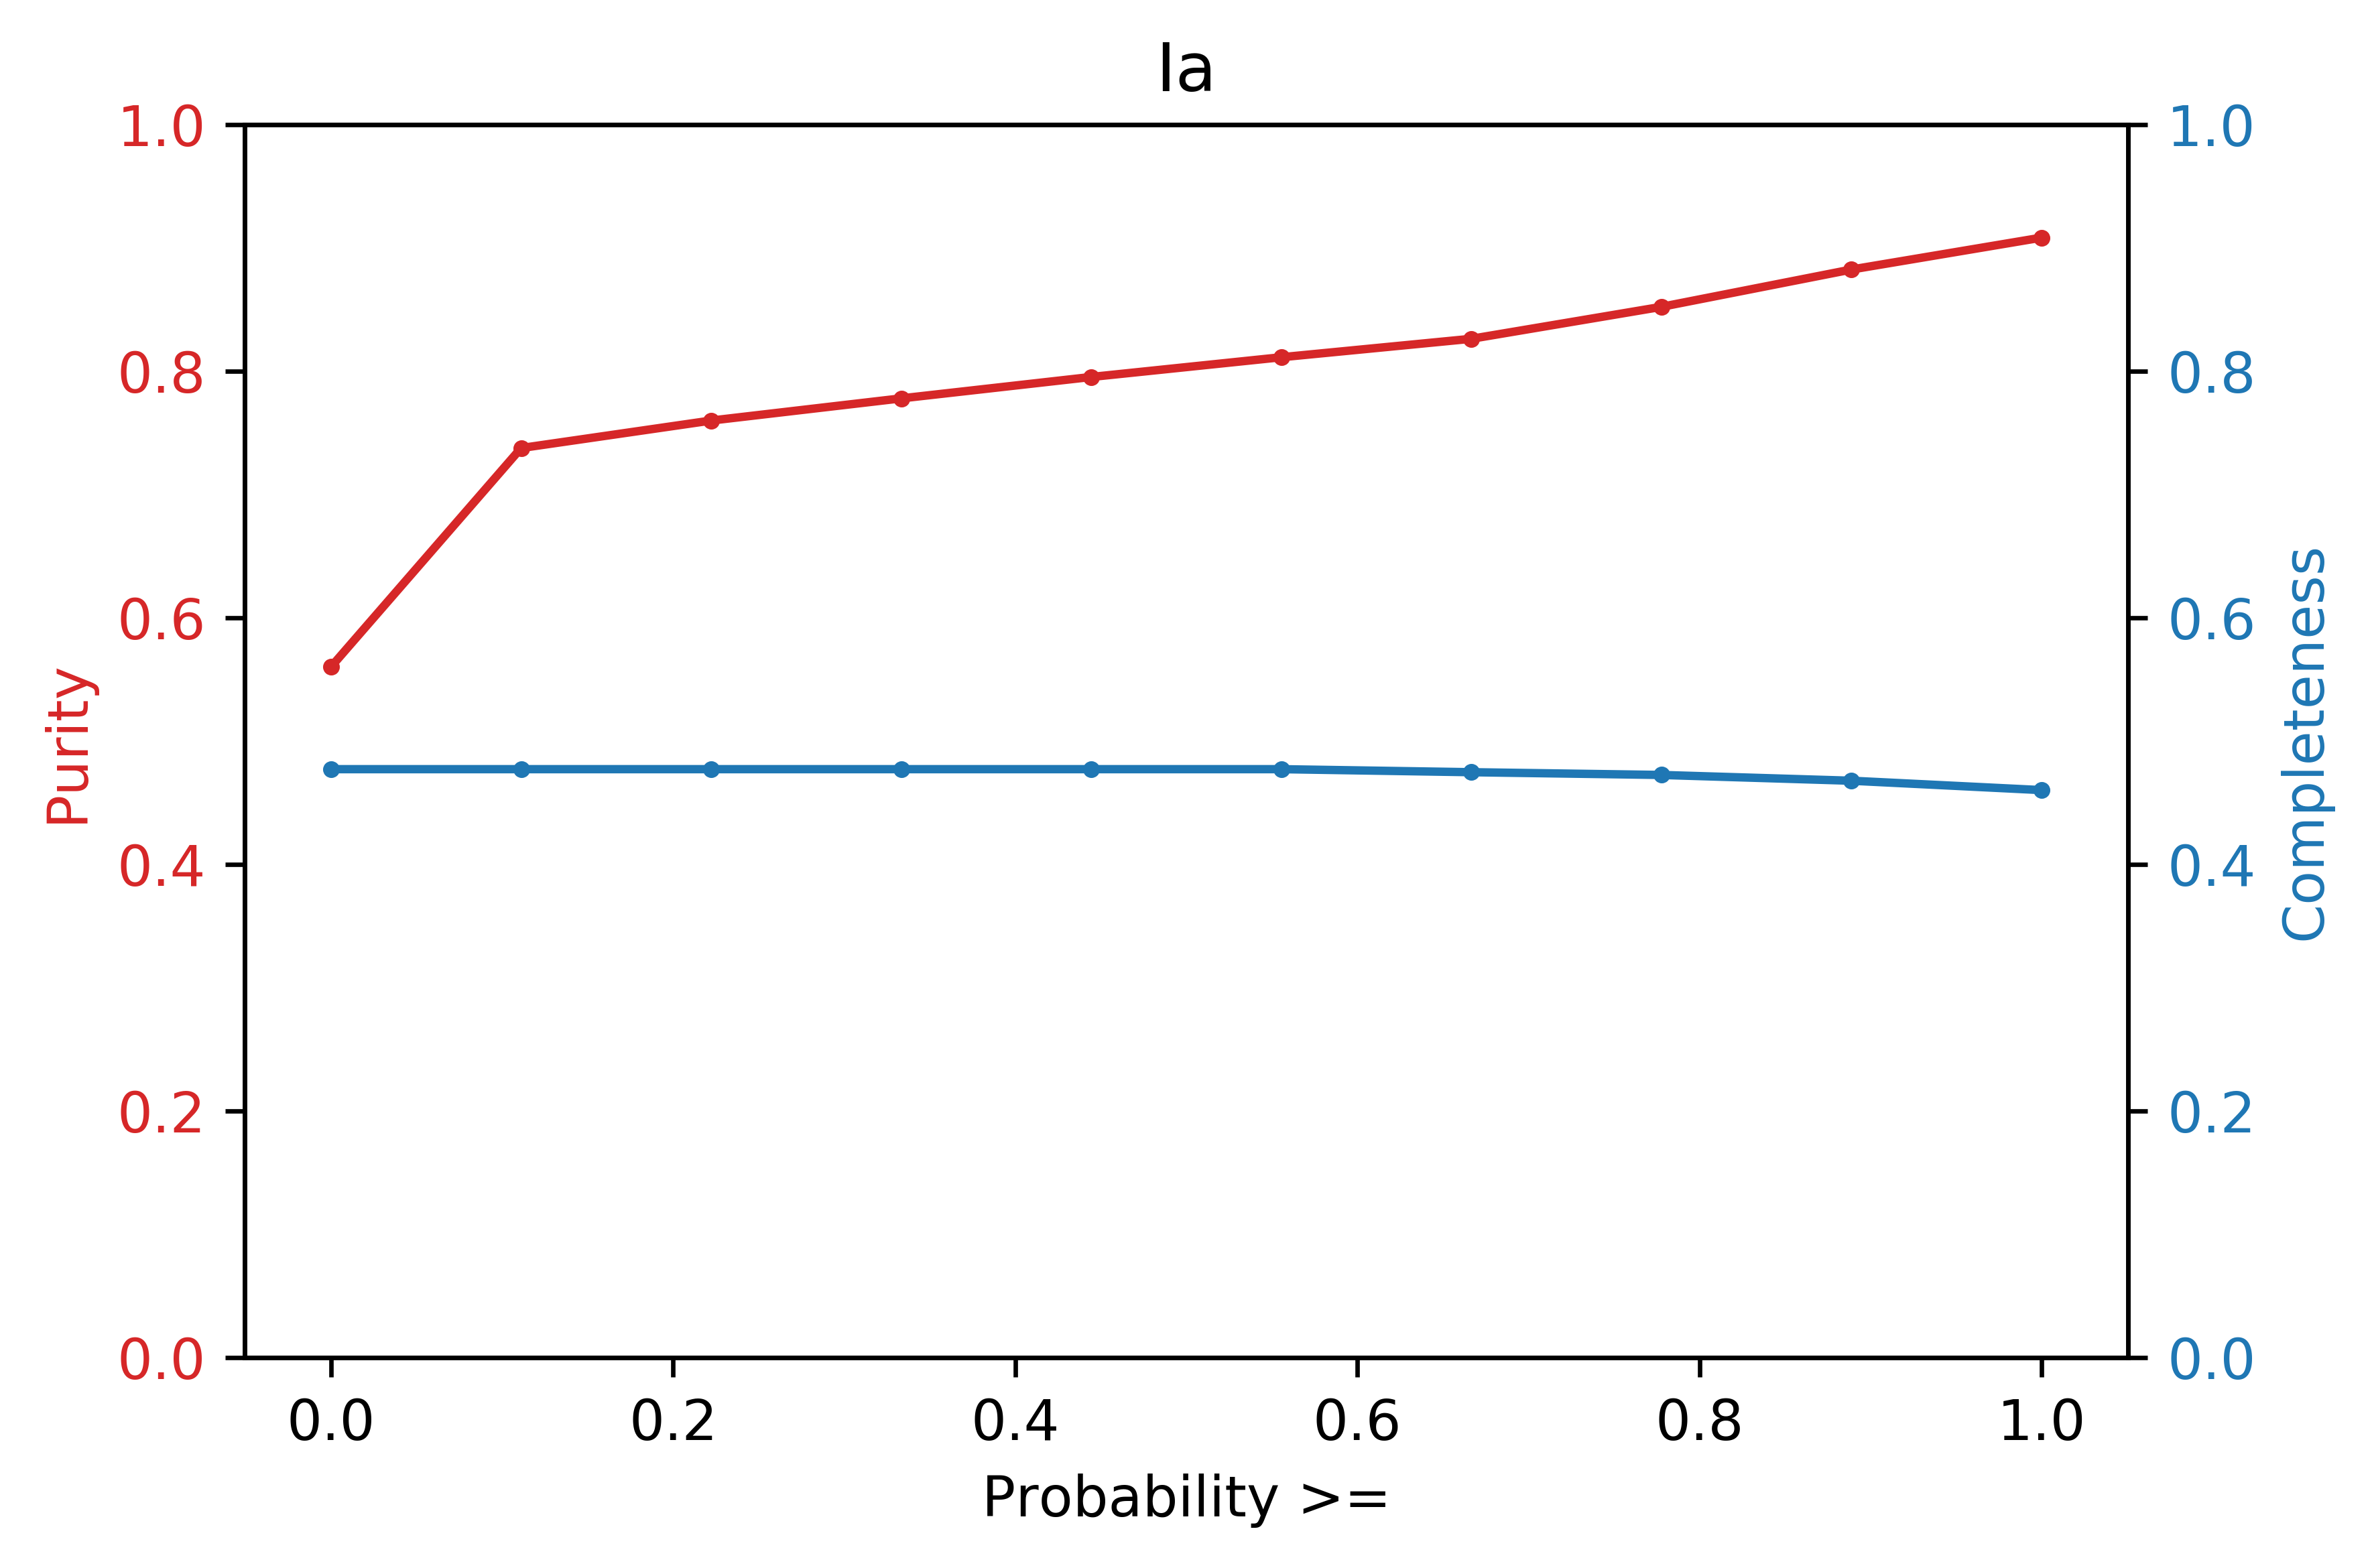

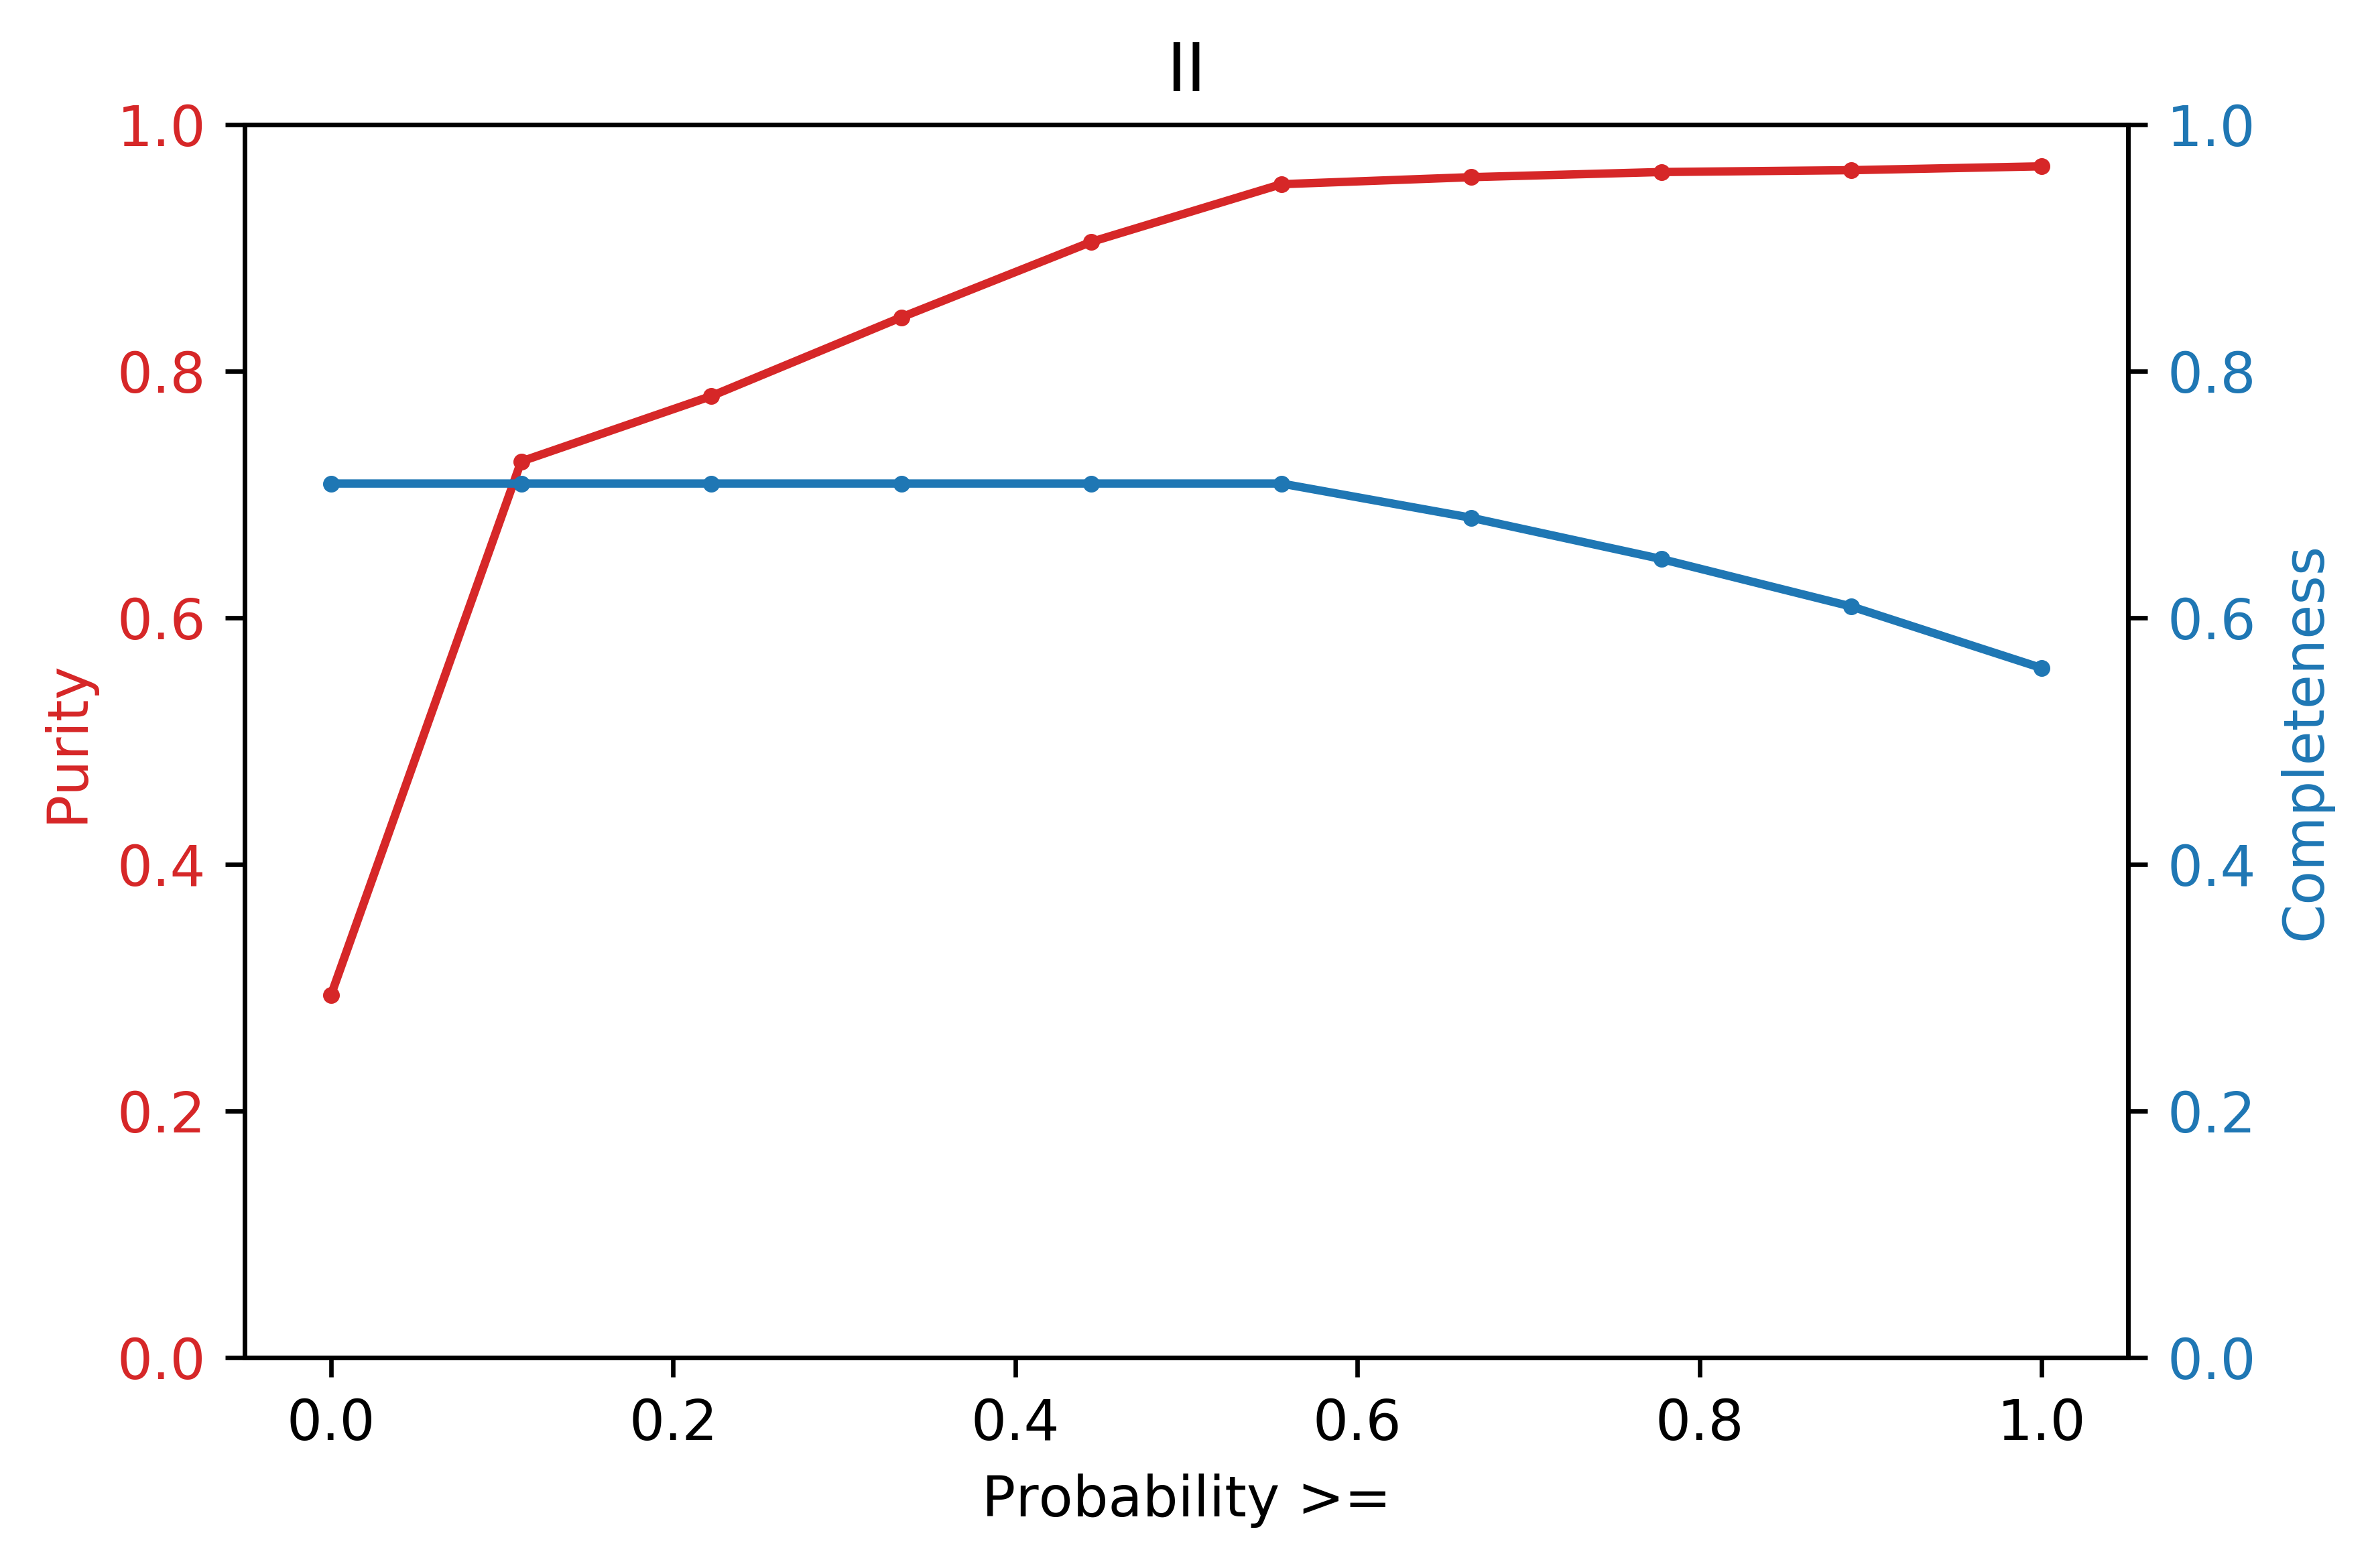

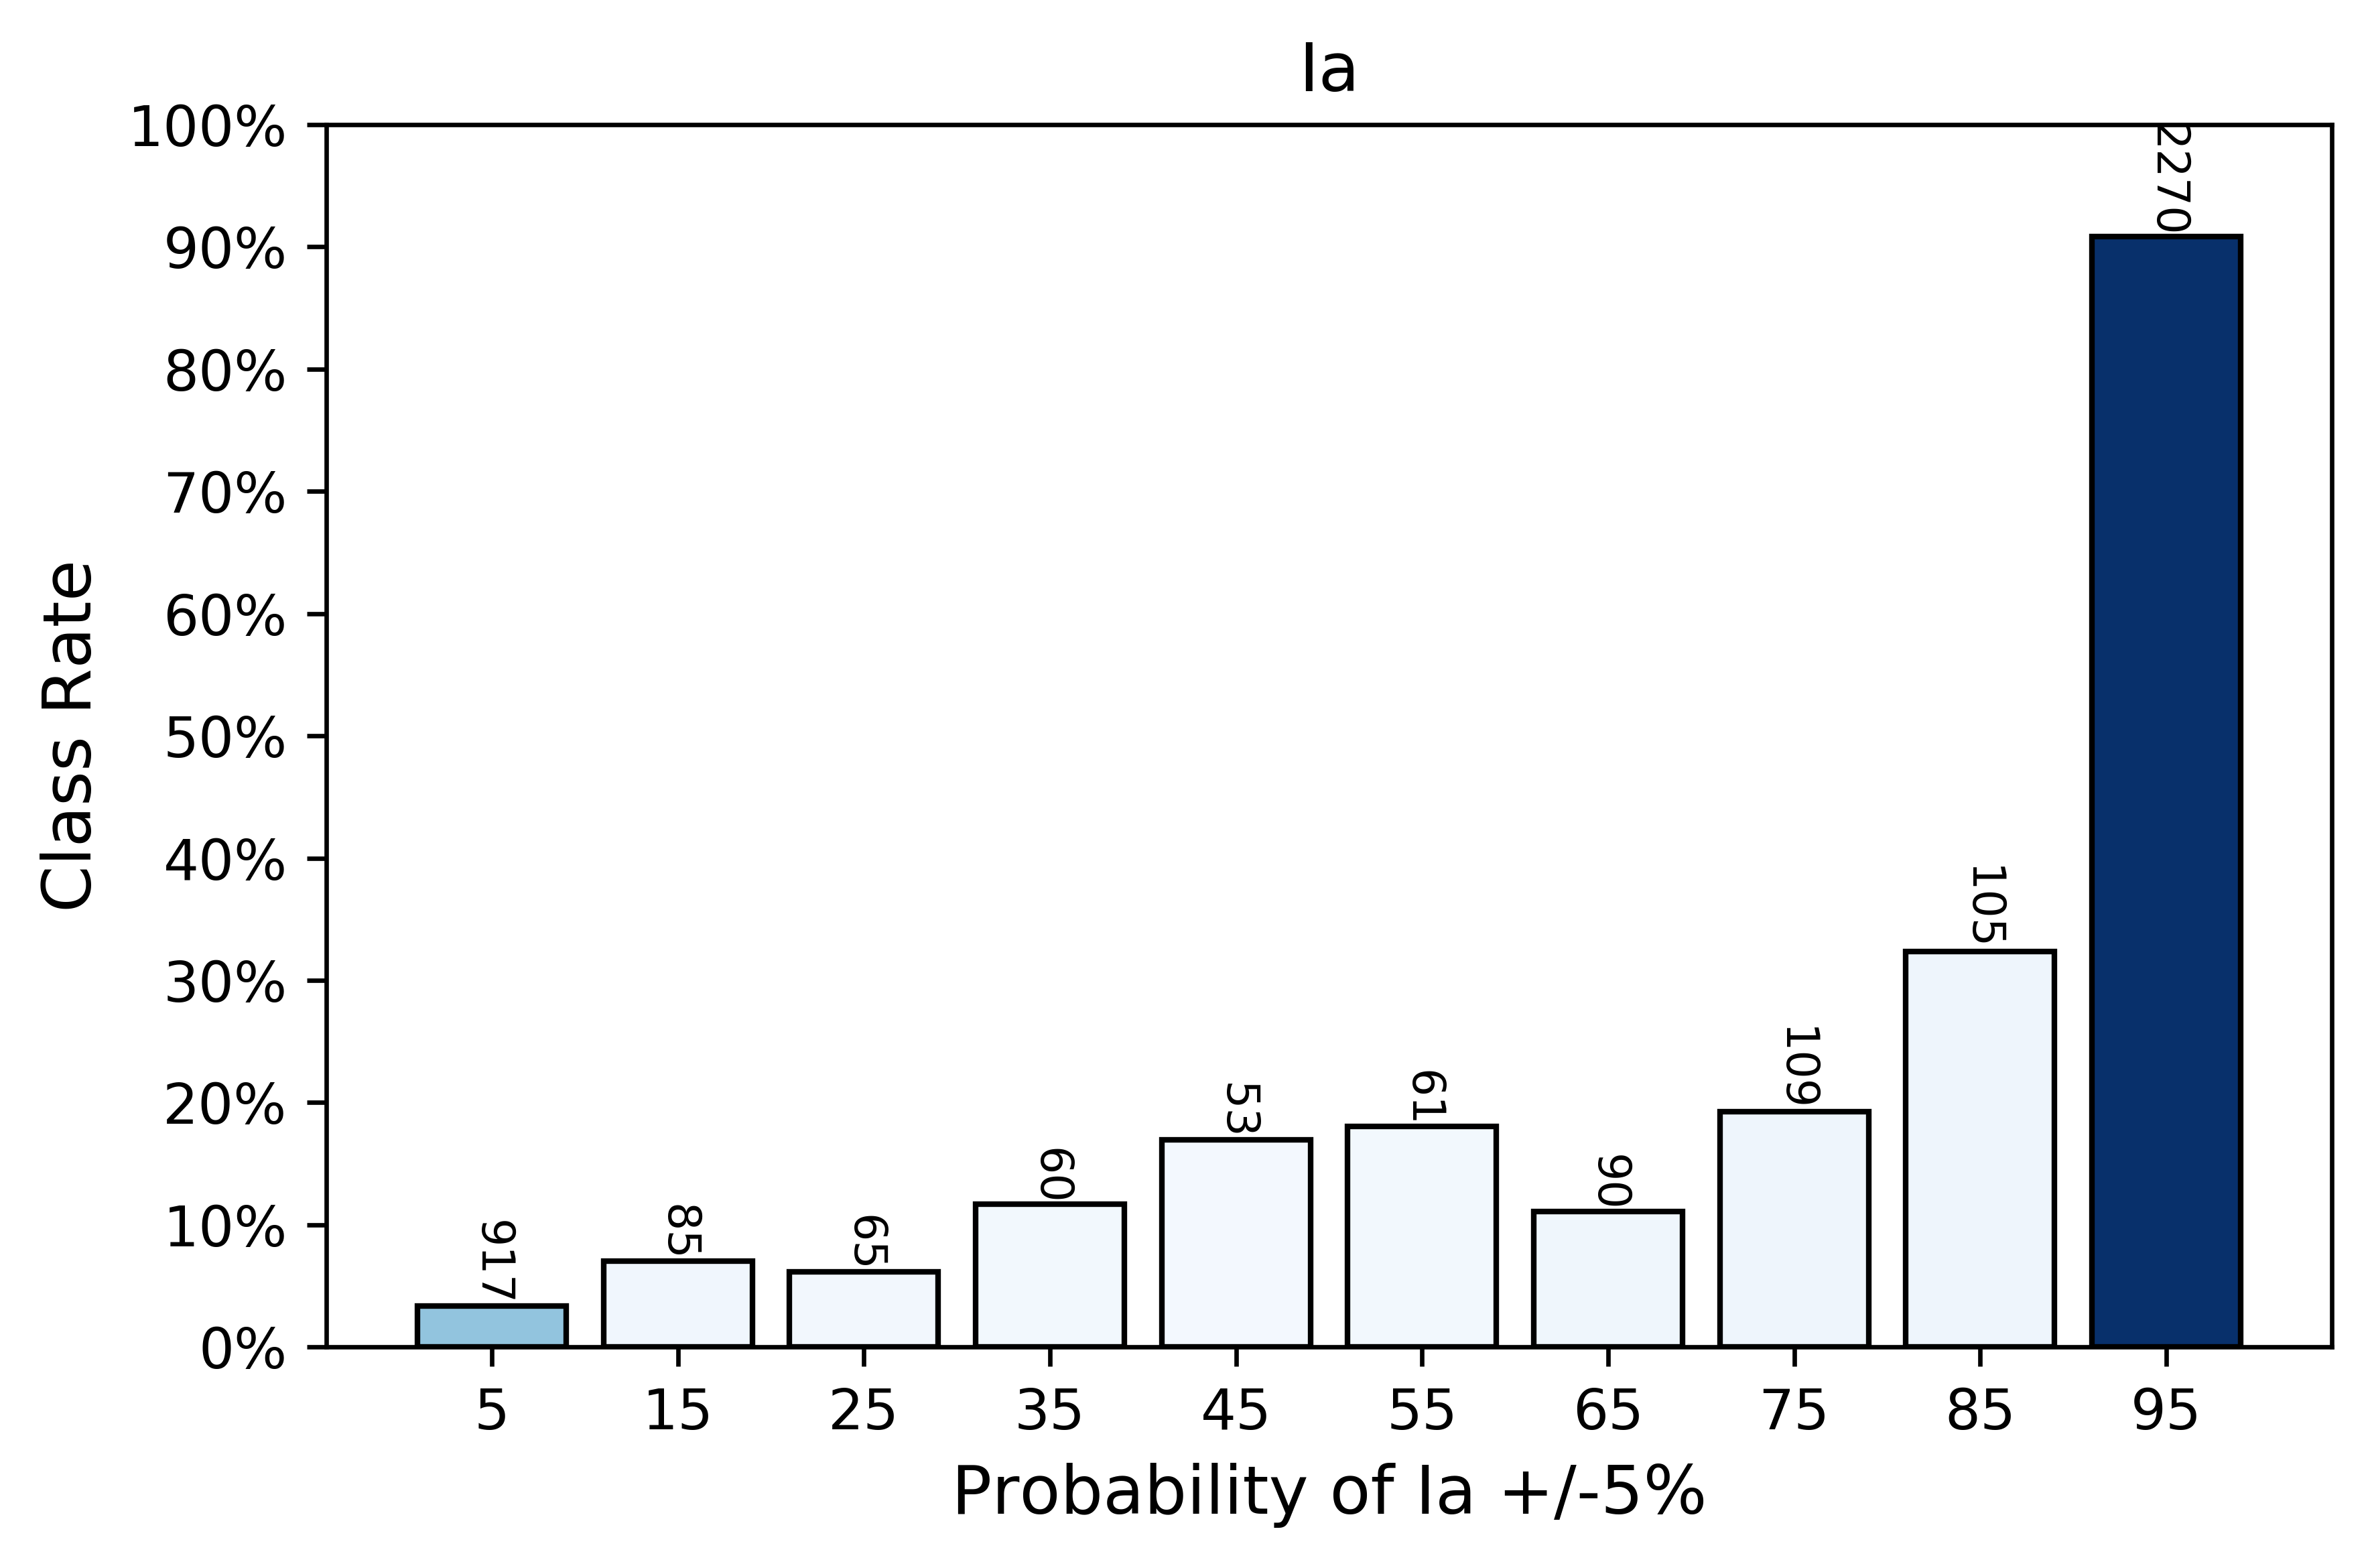

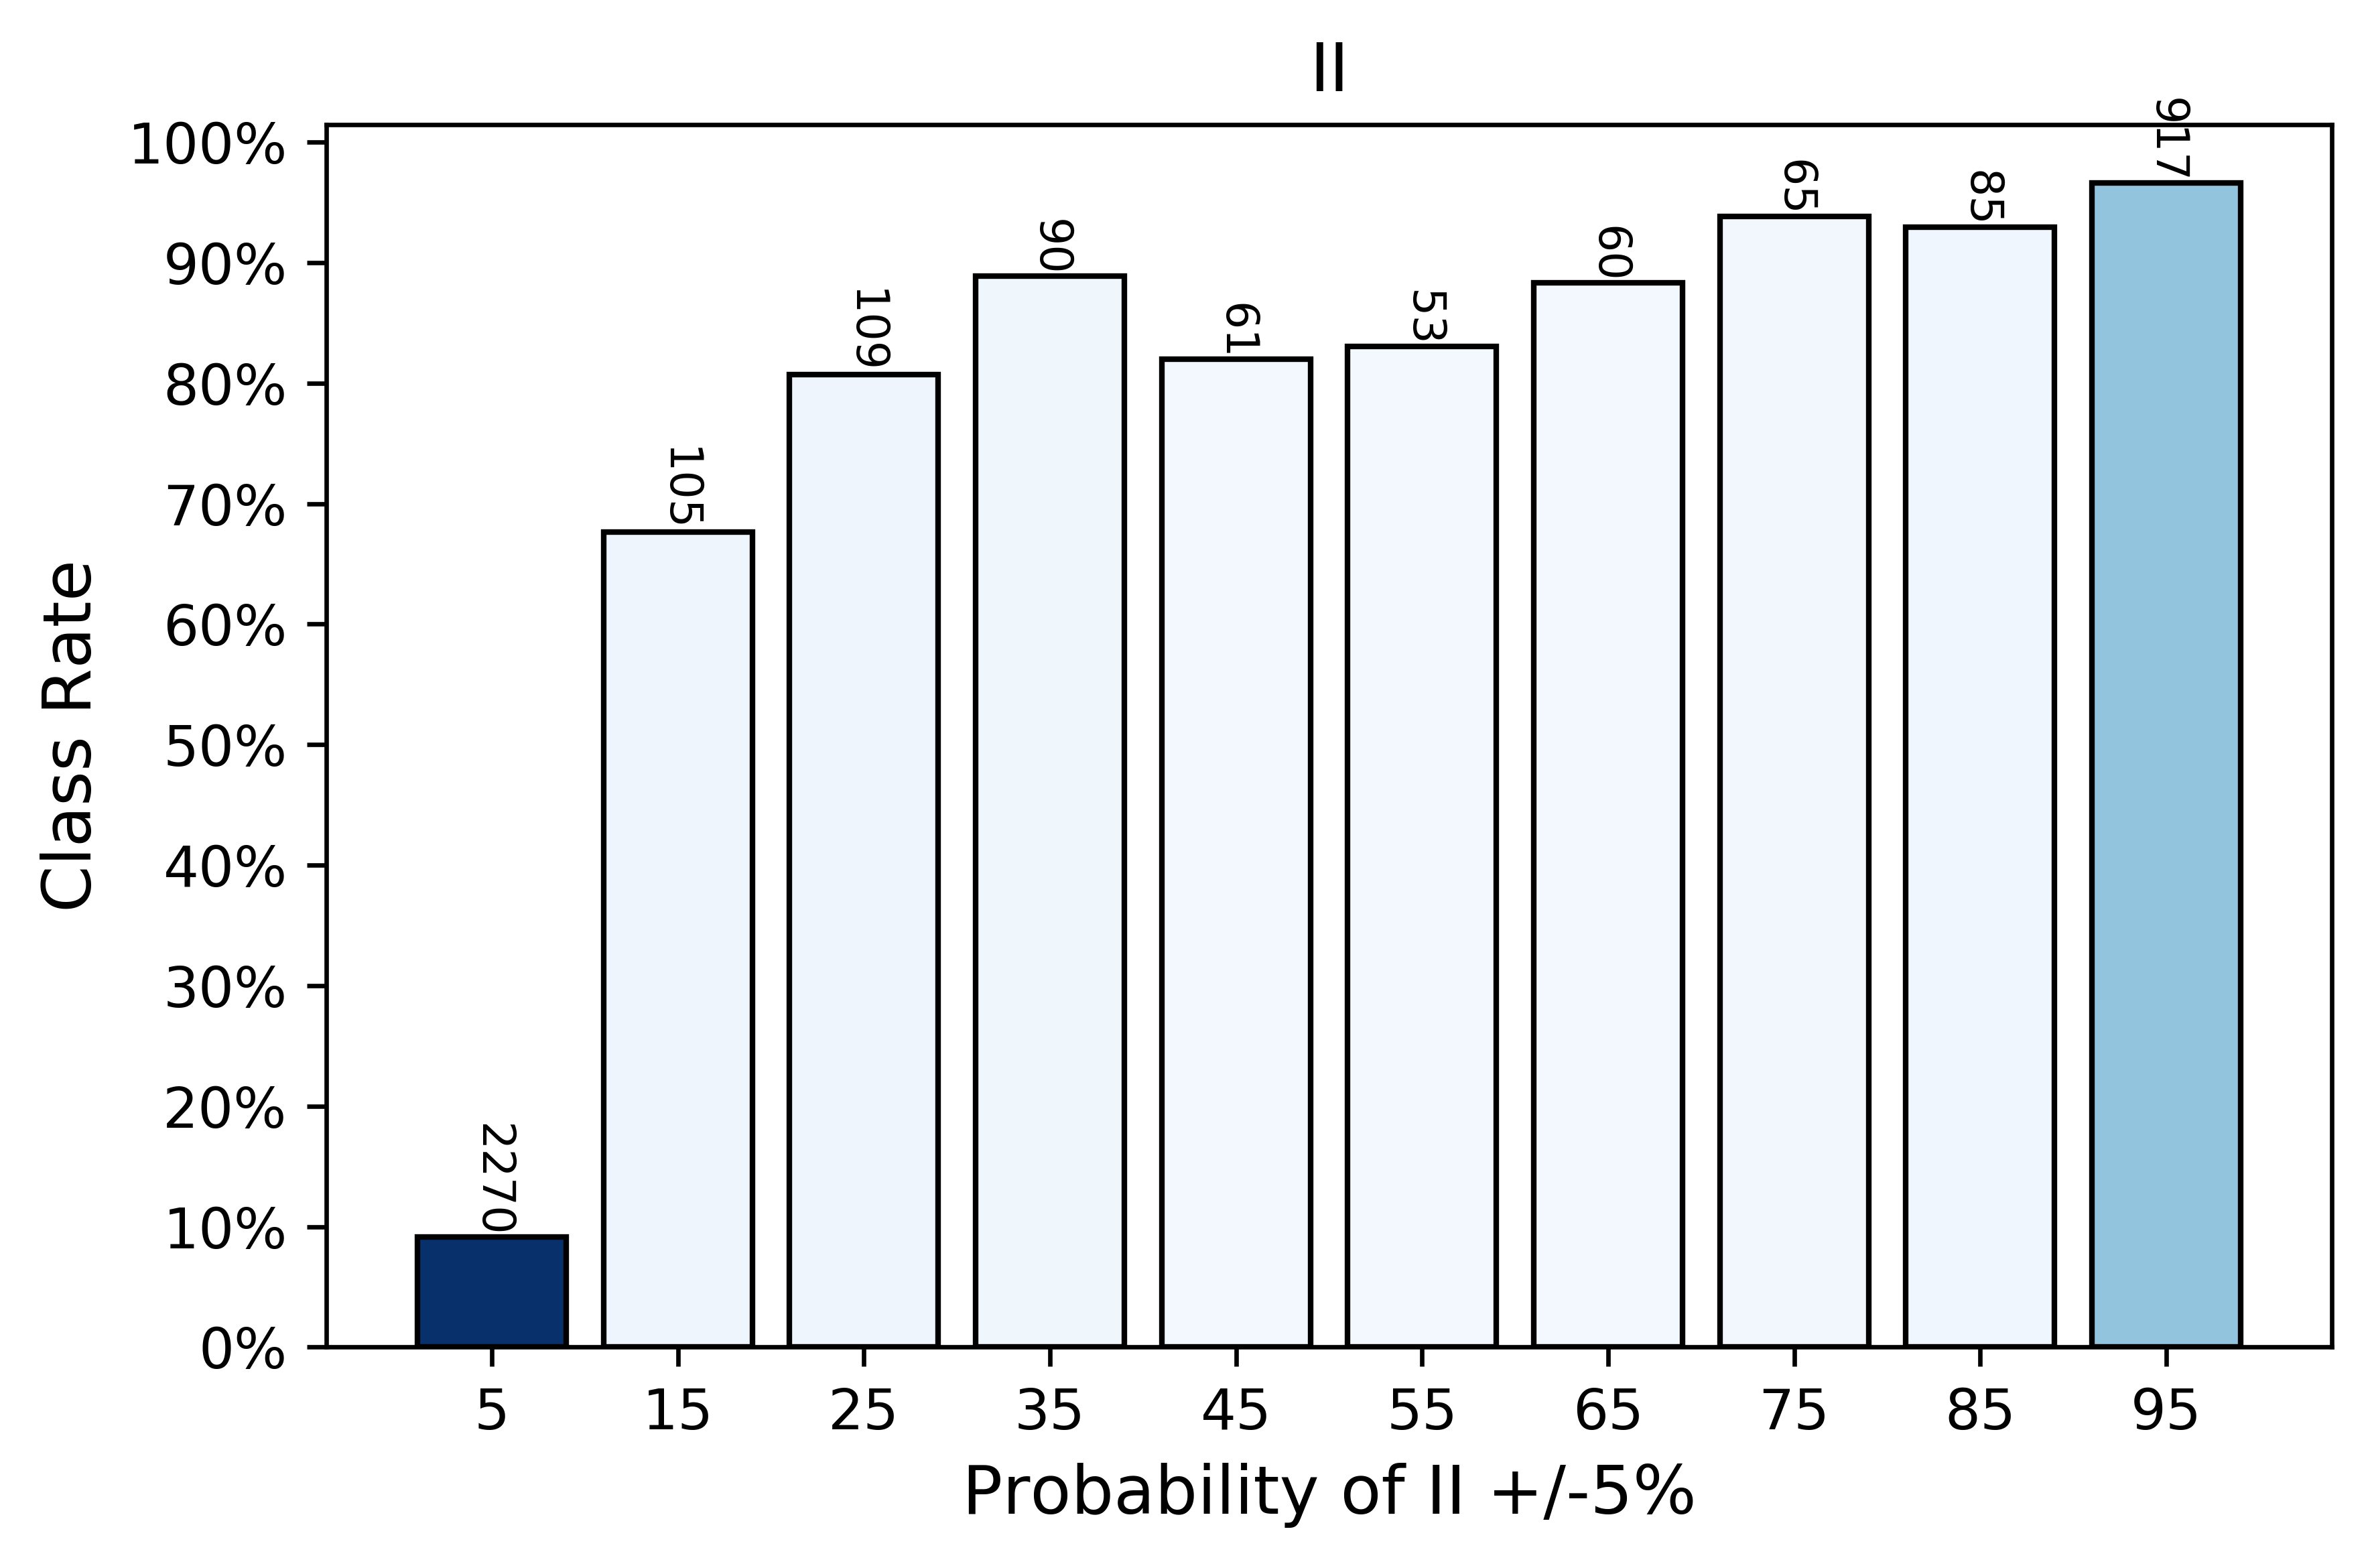

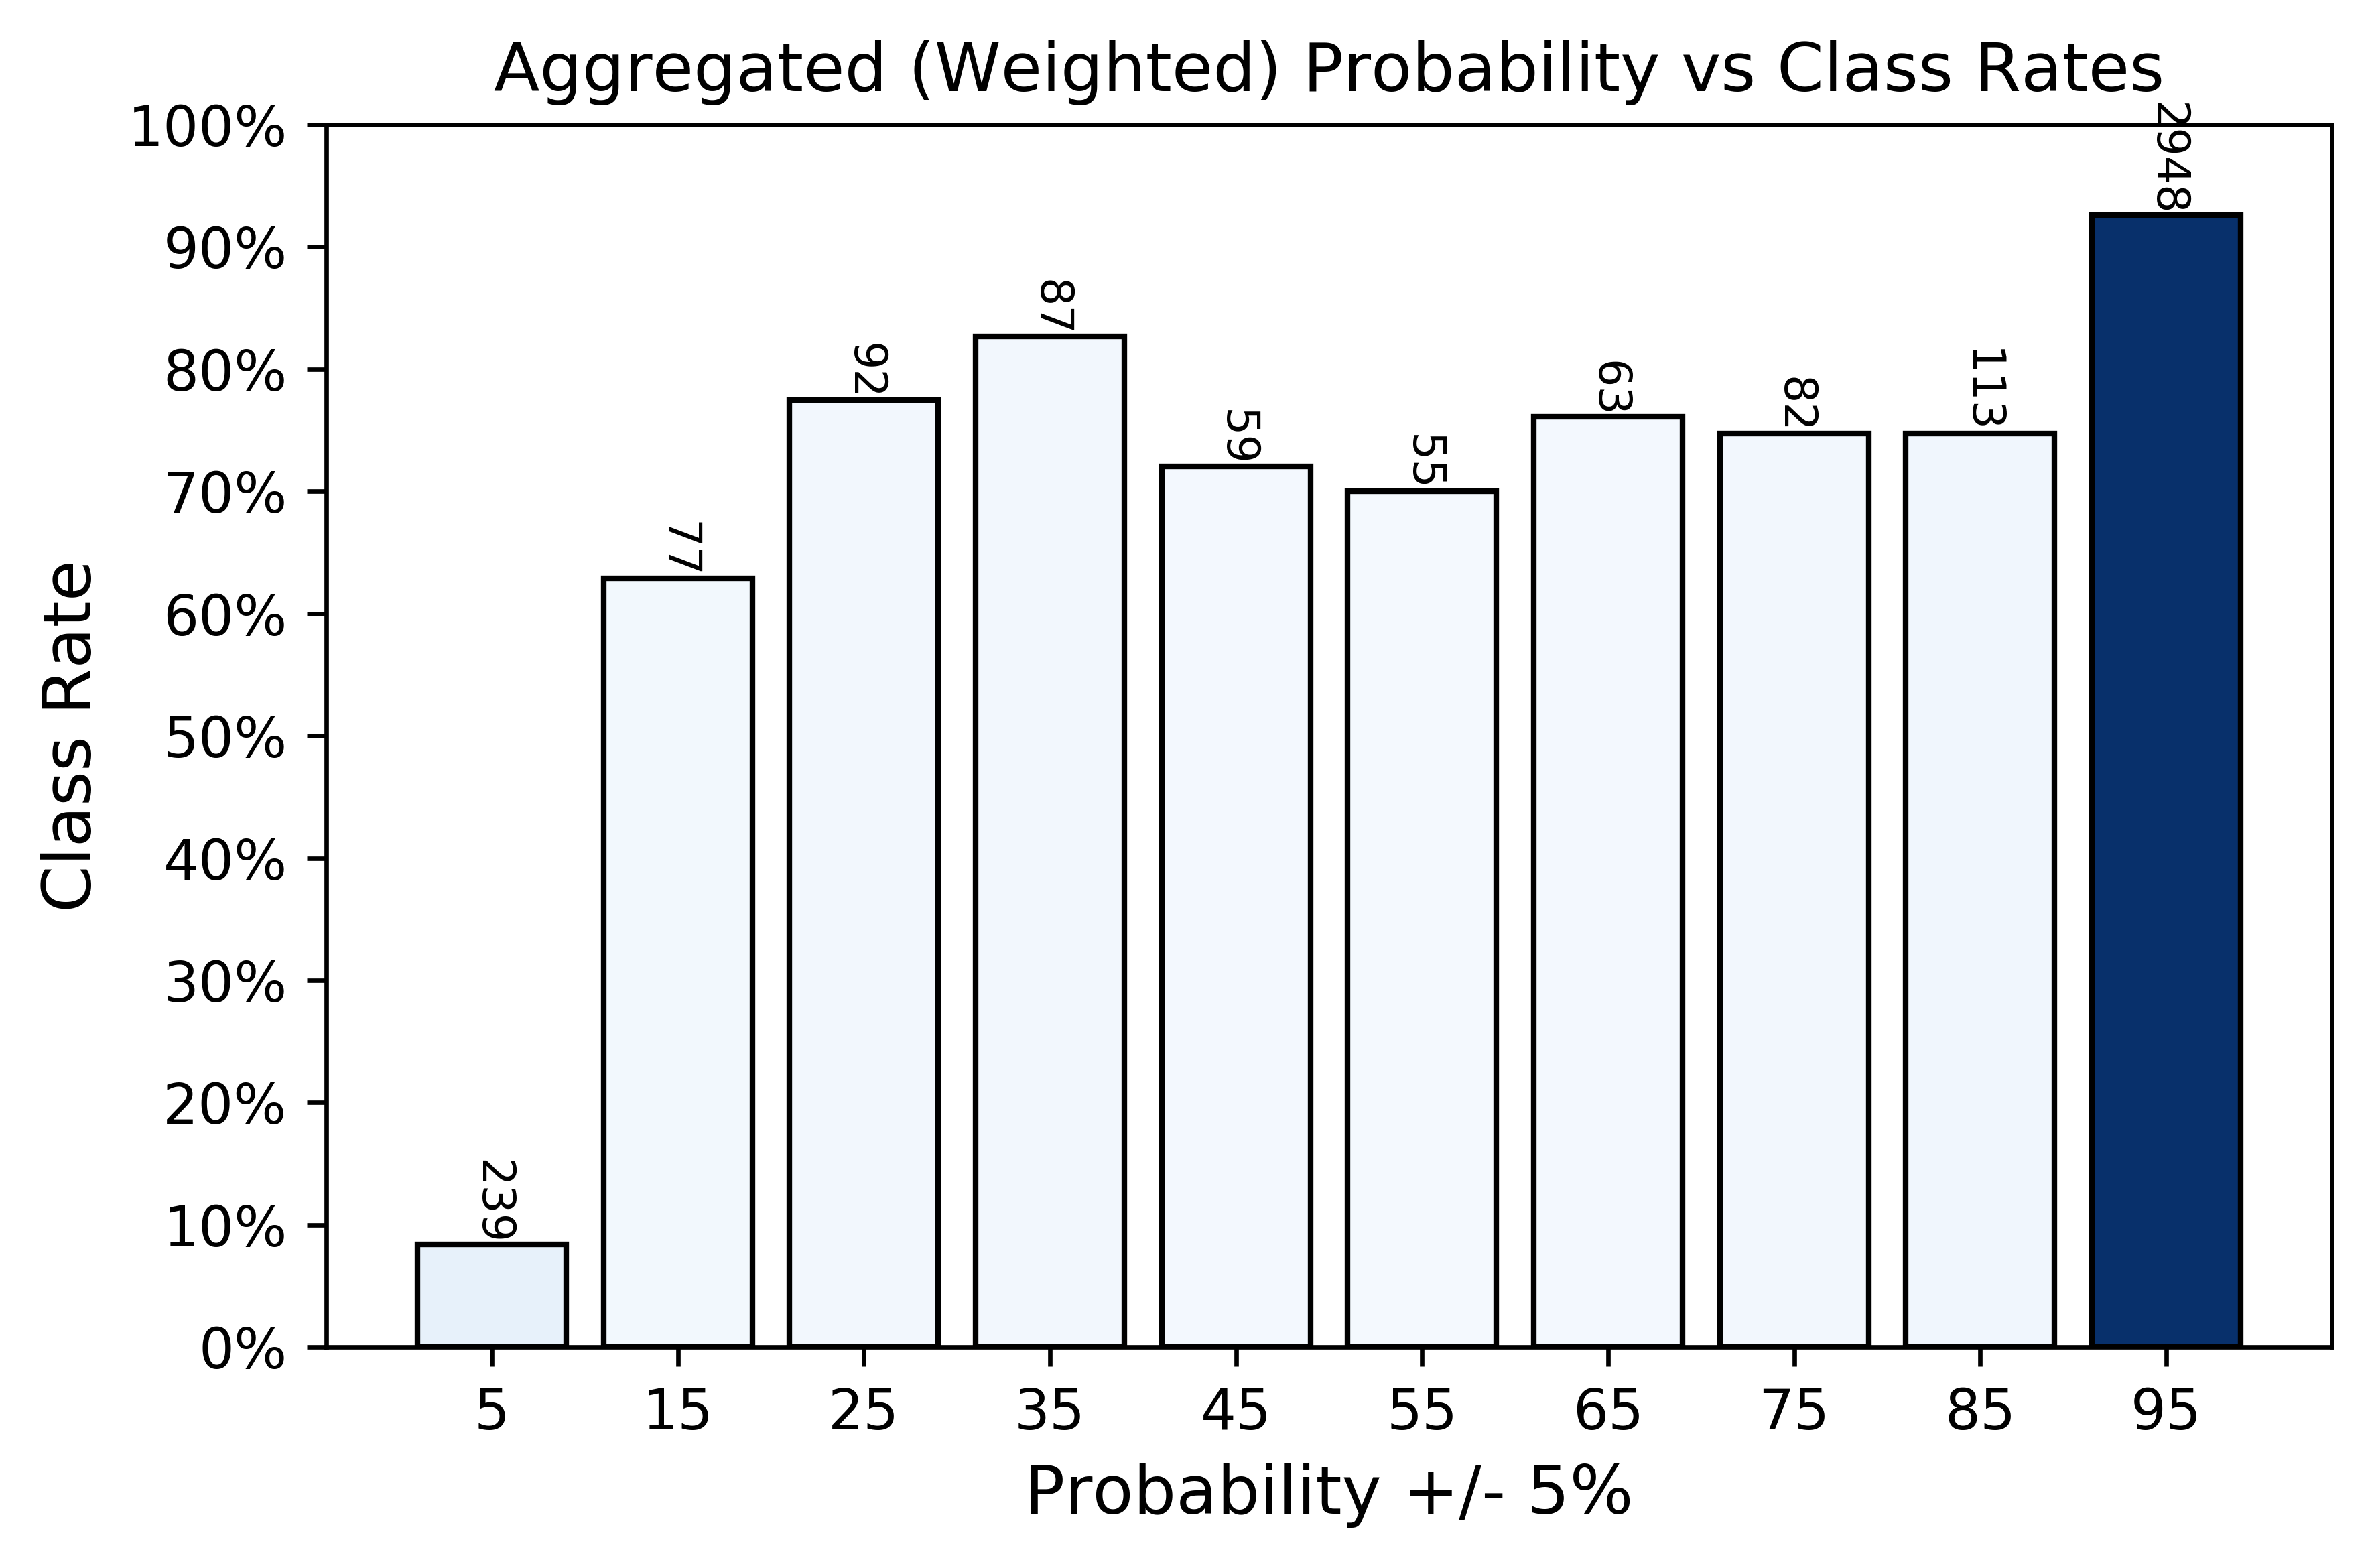

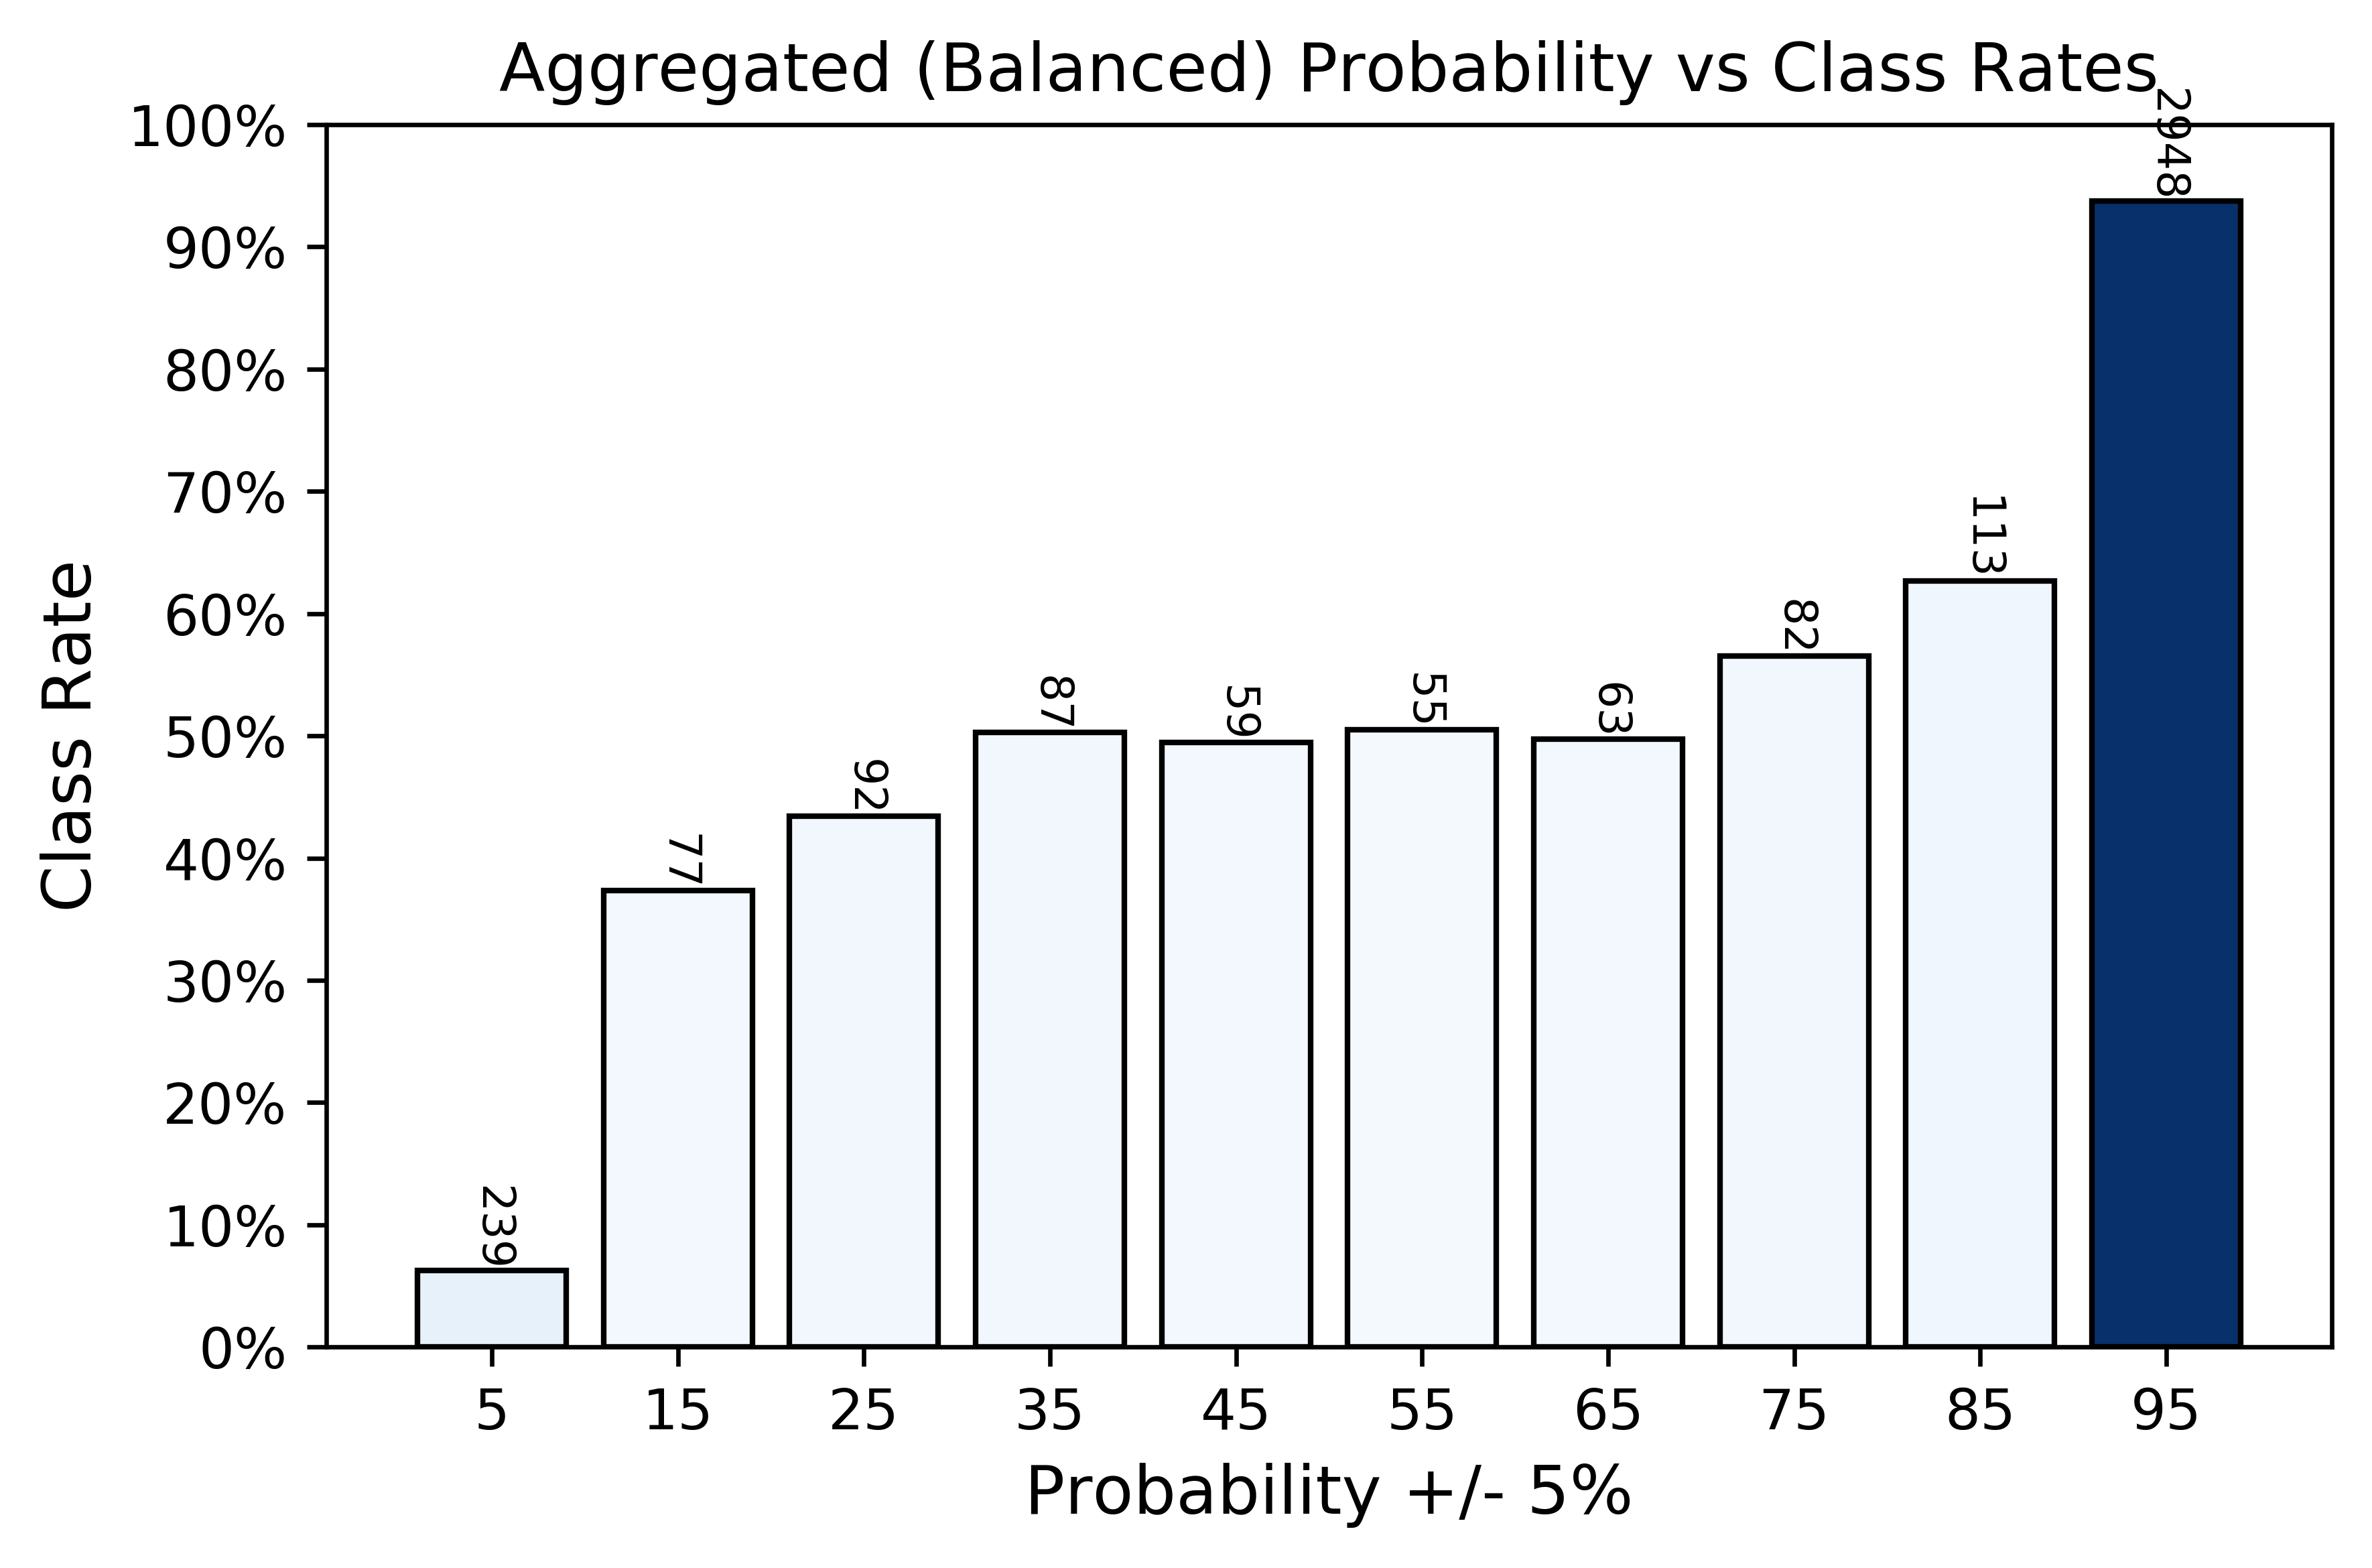

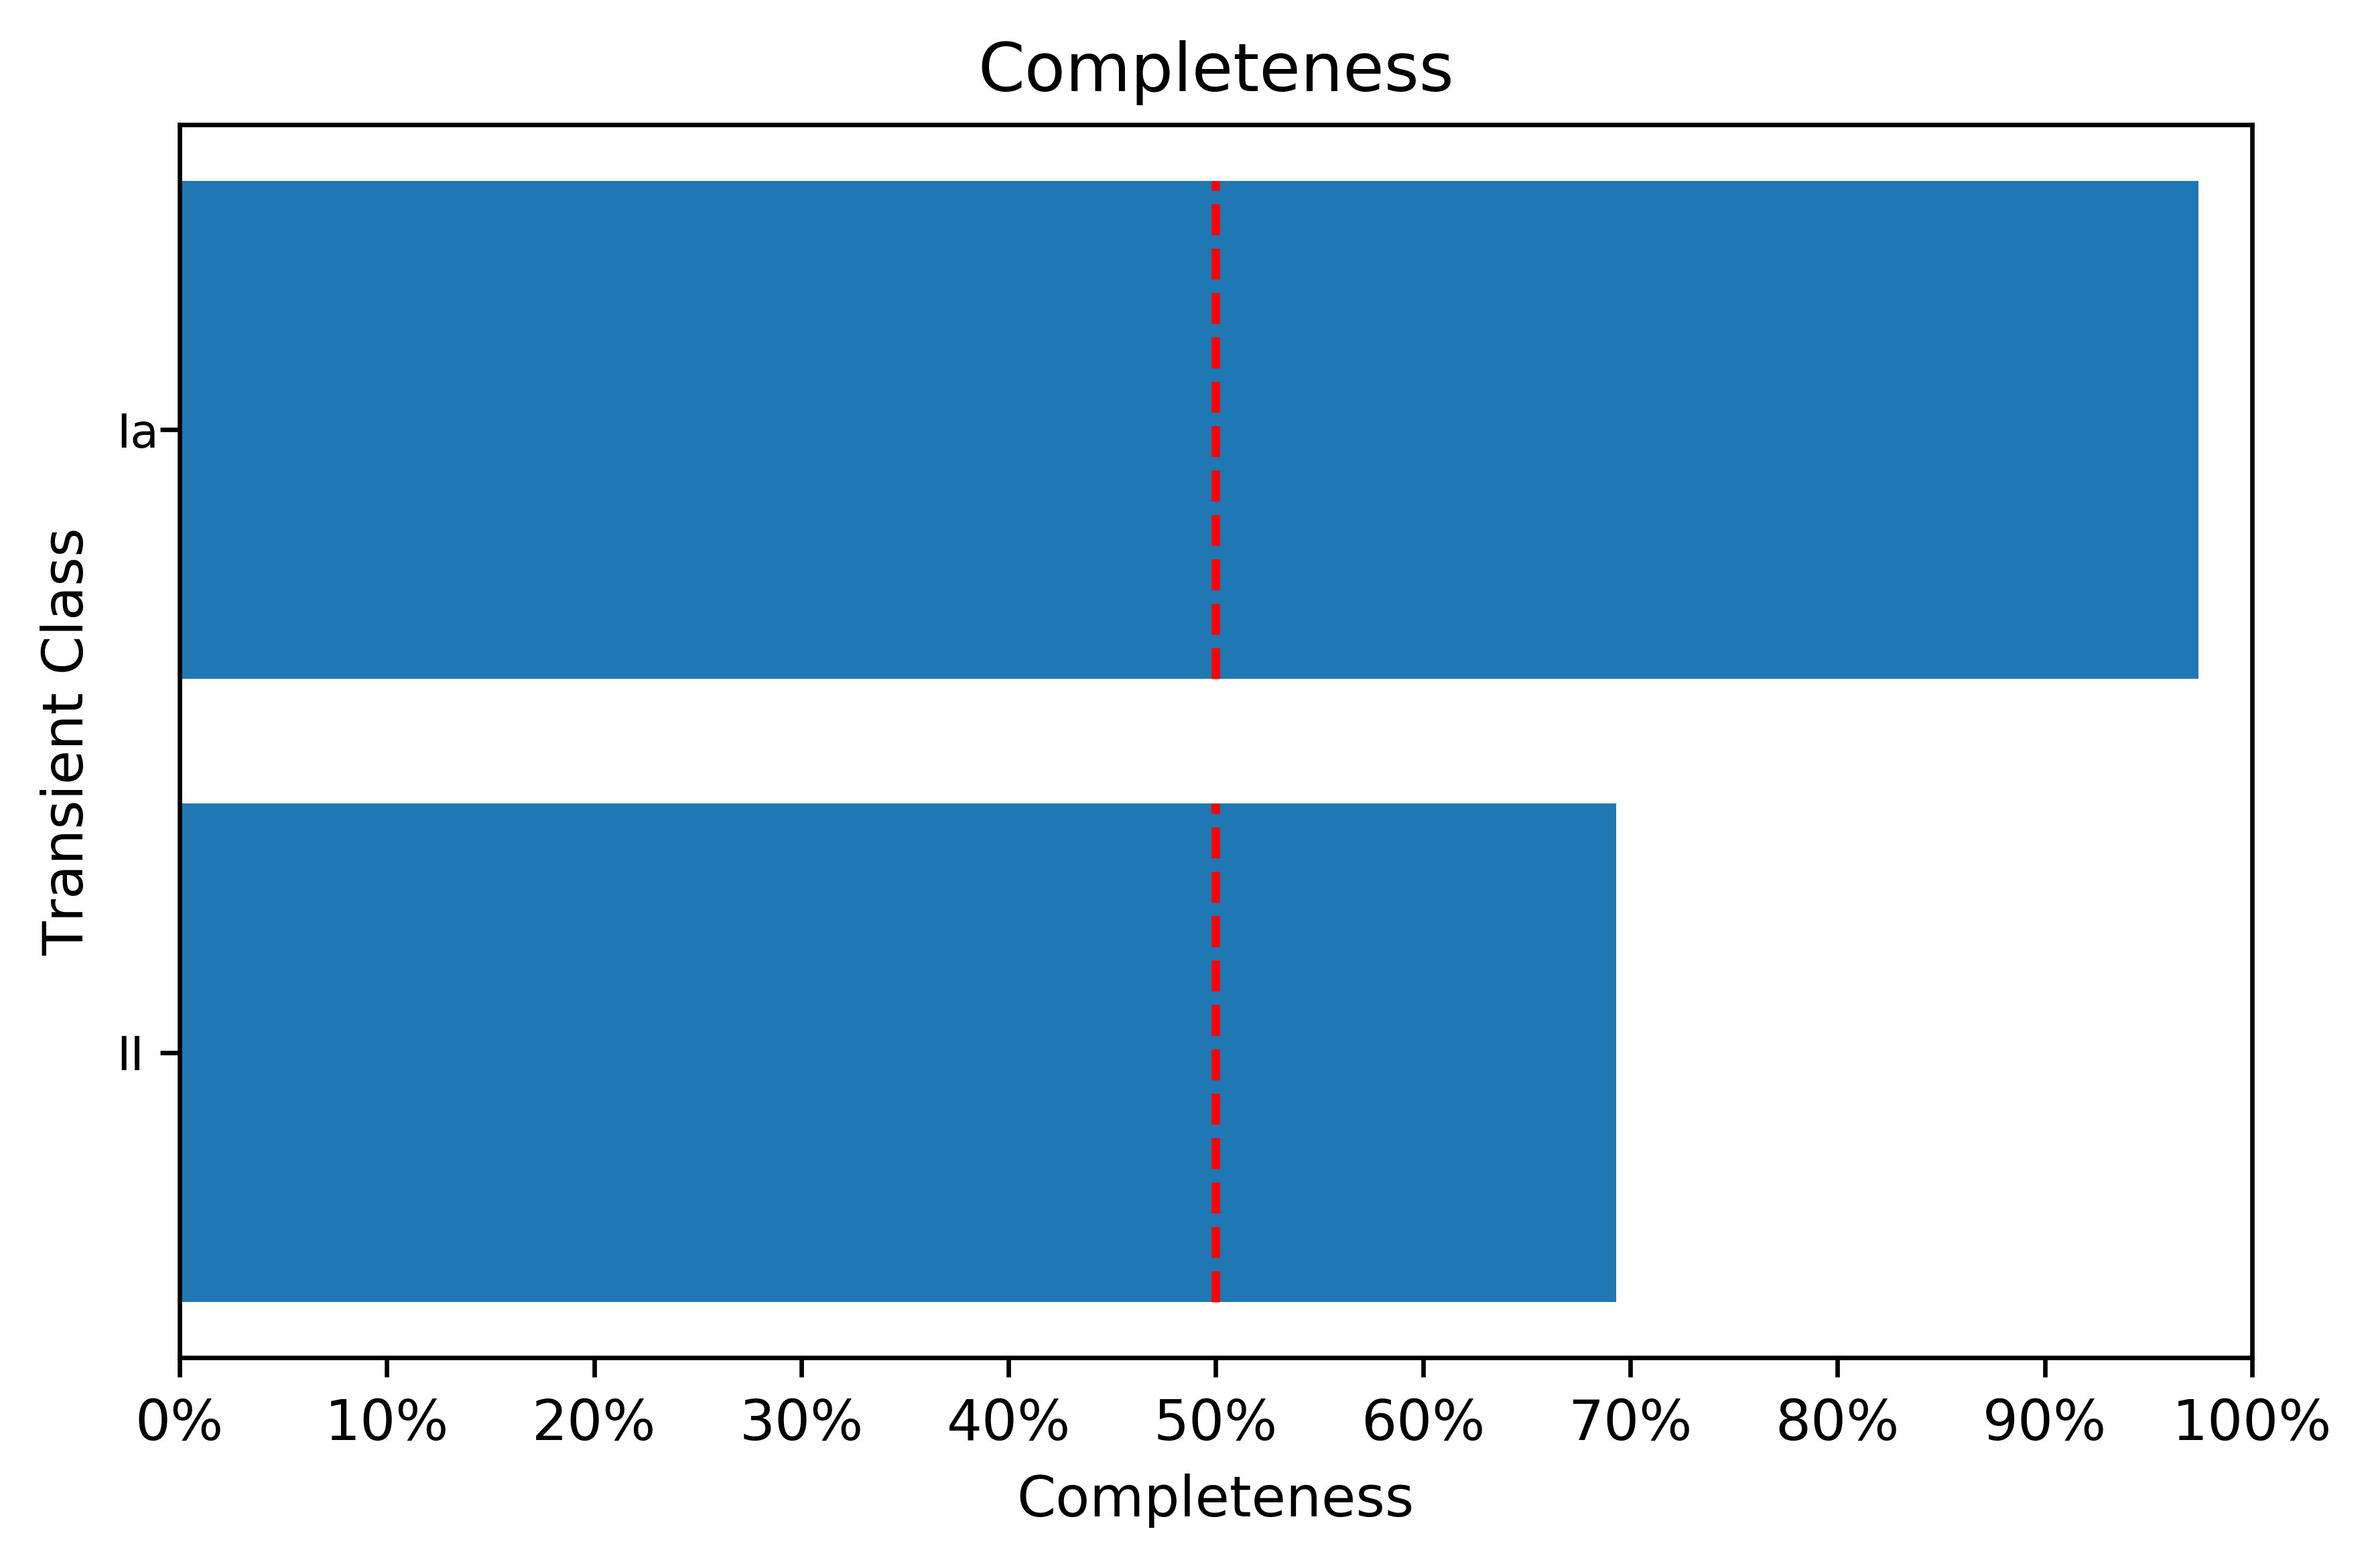

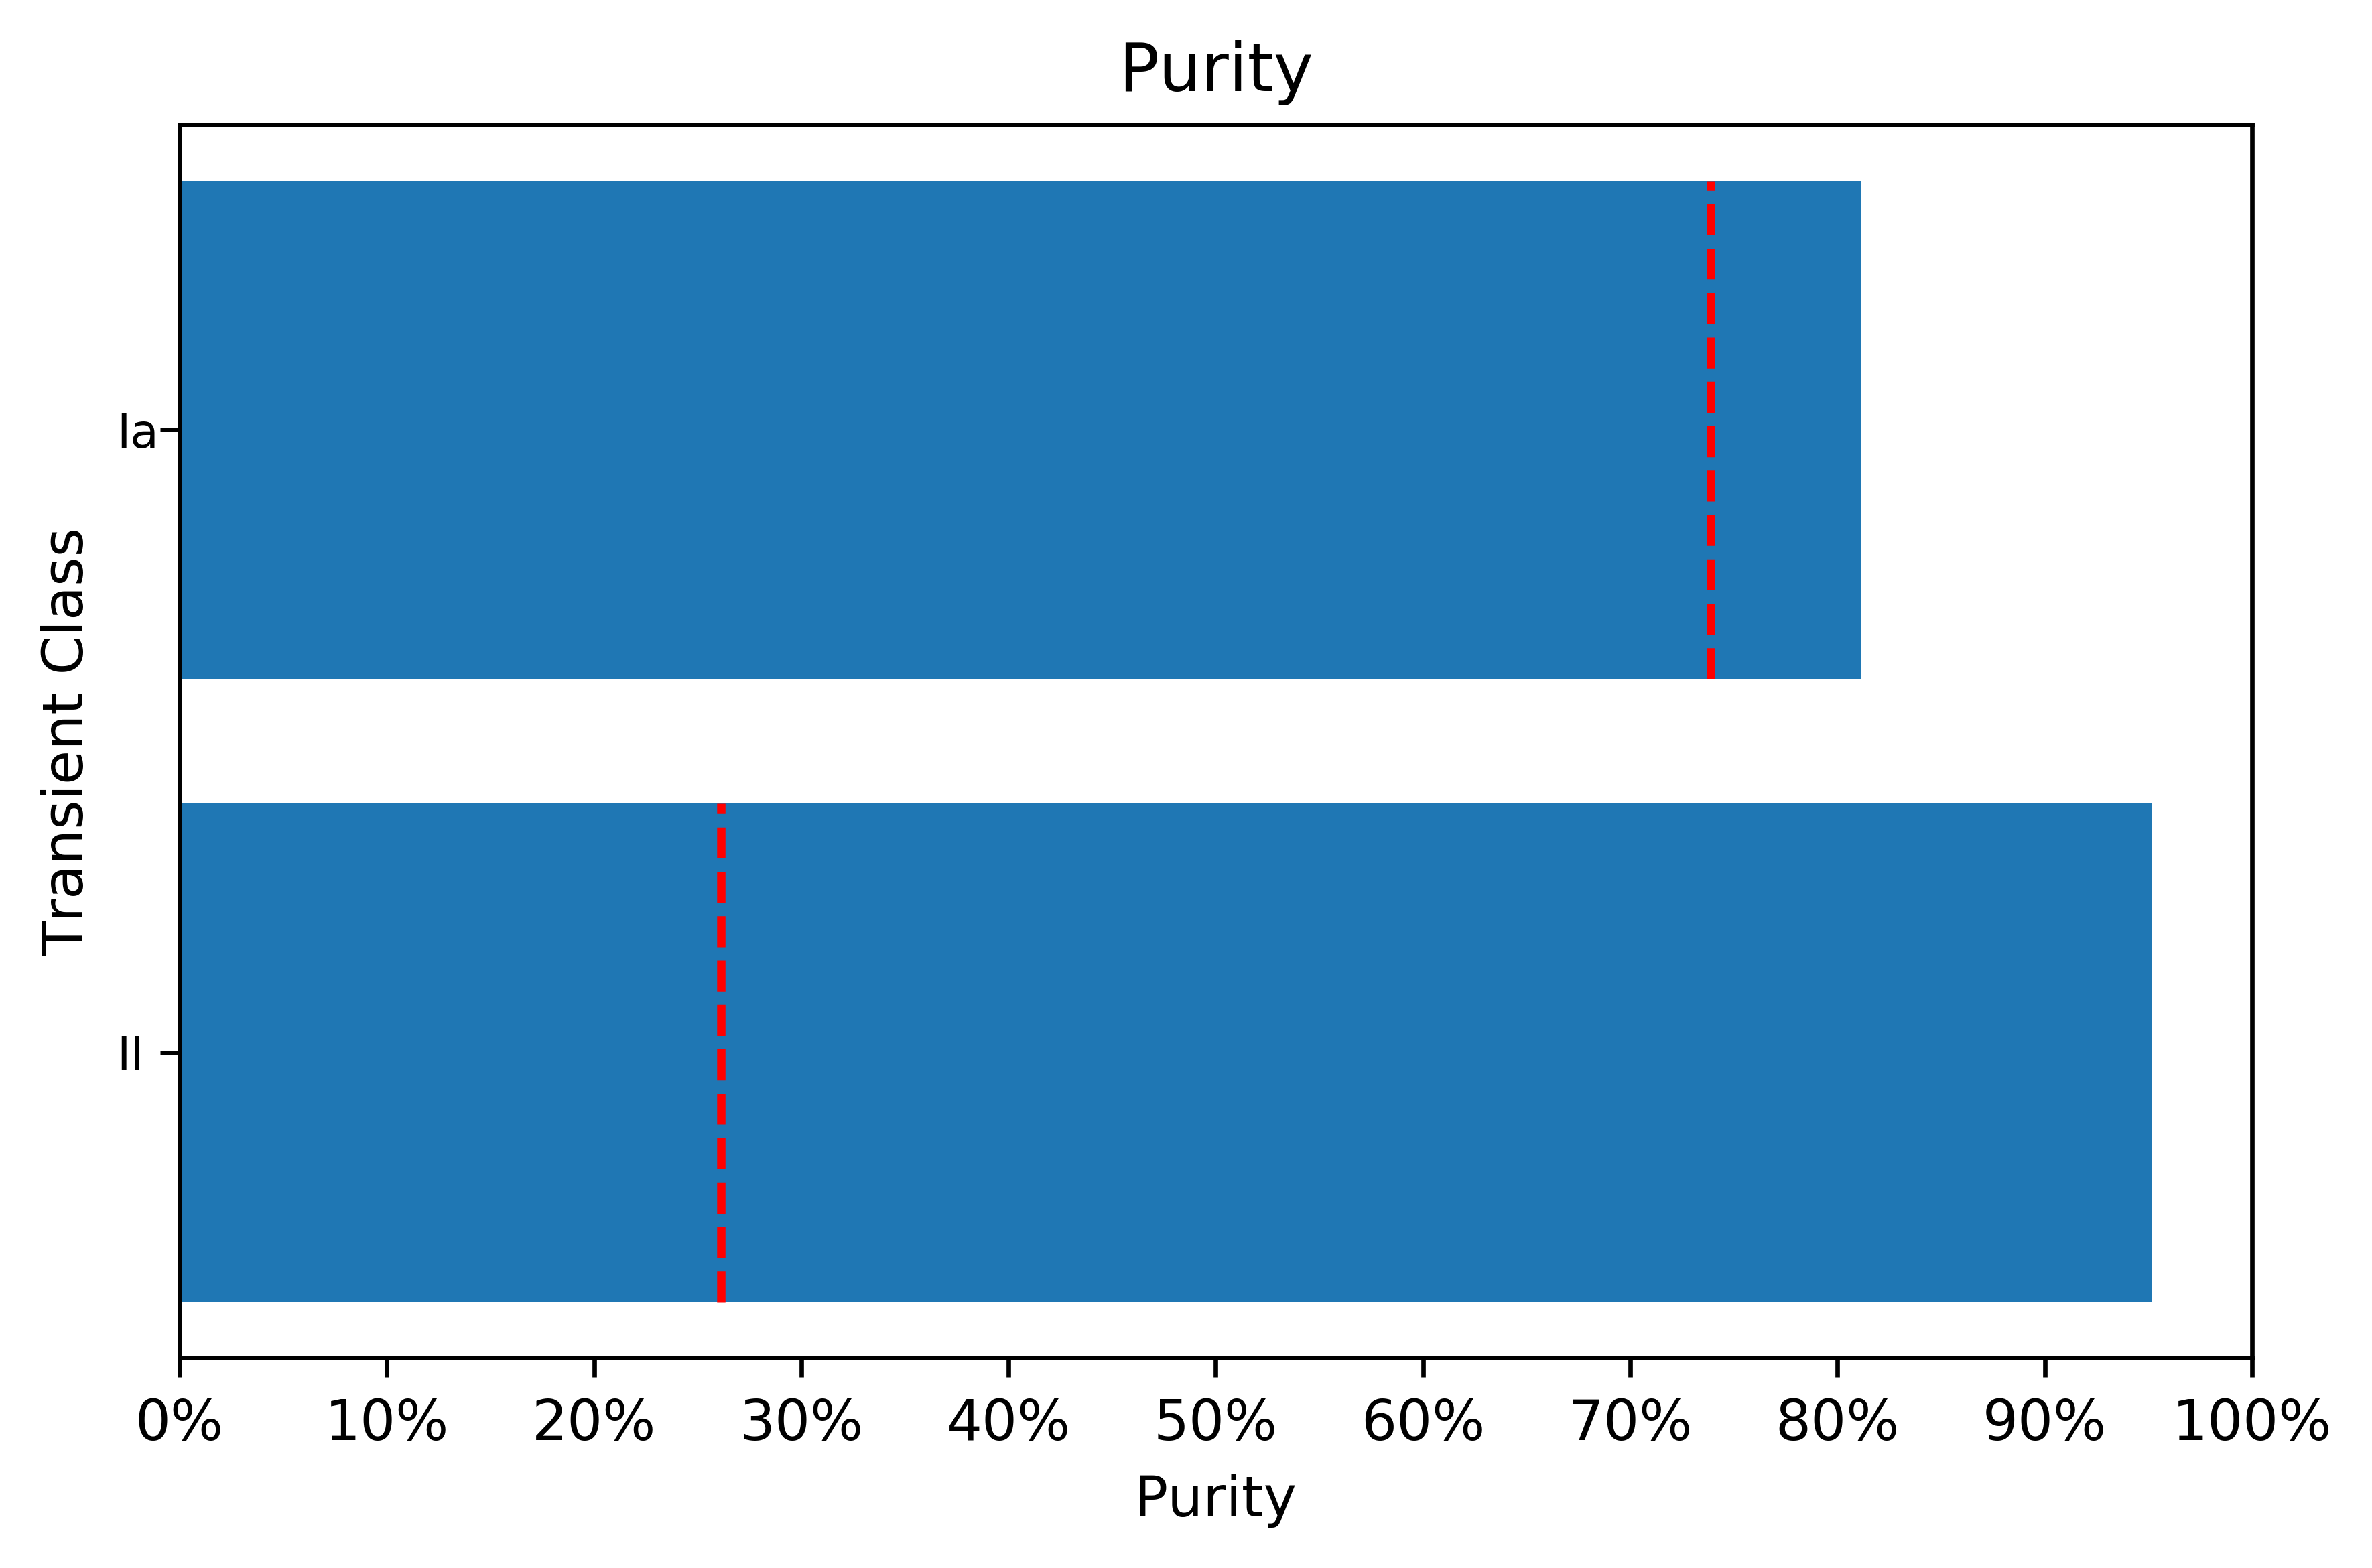

In [32]:
model.results = results
model.visualize_performance()